In [1212]:
import proteomic_funcs
import importlib
importlib.reload(proteomic_funcs)
from proteomic_funcs import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Preprocessing

In [1024]:
#%run /home/eduff/biobank/BIACOB/PreProc.py

## Reading in Proteomics

Proteomics stored in .csv format from assay acquisition, separating Plex4 and Ptau

In [1025]:
os.chdir('/home/eduff/biobank/Proteomics/process')

In [1026]:
# Reading original pre-release raw data, may require different processing from Biobank

Plex4 = pd.read_csv('4plexE_all_plates_eid.csv')
Plex4.loc[Plex4['spike']=='FALSE ','spike']=False
Plex4.loc[Plex4['spike']=='TRUE ','spike']=True

ptau = pd.read_csv('pTau-181_all_plates_eid.csv')
ptau.loc[ptau['spike']=='FALSE ','spike']=False
ptau.loc[ptau['spike']=='TRUE ','spike']=True

In [1027]:
Plex4.loc[Plex4['SampleID'].str[-1:]=='1','Session']='1'
Plex4.loc[Plex4['SampleID'].str[-1:]=='a','Session']='a'

ptau.loc[ptau['SampleID'].str[-1:]=='1','Session']='1'
ptau.loc[ptau['SampleID'].str[-1:]=='a','Session']='a'

Plex4_spike=Plex4[Plex4['spike']==True]
Plex4=Plex4[Plex4['spike']==False]

ptau_spike=ptau[ptau['spike']==True]
ptau=ptau[ptau['spike']==False]

In [ ]:
# remove singletons
for a in Plex4['eid']:
    if len(Plex4[(Plex4['eid']==a) & (Plex4['spike']==False)])!=2:
        
        Plex4=Plex4[Plex4['eid']!=a]
        ptau=ptau[ptau['eid']!=a]
for a in ptau['eid']:
    if len(ptau[(ptau['eid']==a) & (ptau['spike']==False)])!=2:
        Plex4=Plex4[Plex4['eid']!=a]
        ptau=ptau[ptau['eid']!=a]
        
# remove potentially mislabelled samples
for a in [339983033,339983037]:
    Plex4=Plex4[Plex4['VacutainerID']!=a]
    ptau=ptau[ptau['VacutainerID']!=a]
    

1143054
5655812
1777711
5385993


In [1029]:
# combine proteins
all_prot=pd.concat([ptau,Plex4],axis=1)
all_prot = all_prot.loc[:,~all_prot.columns.duplicated()]

# rename proteins
all_prot =all_prot.rename(columns={'Neurology 4plexE AB42 pg/ml Replicate 1':'Ab42','Neurology 4plexE AB40 pg/ml Replicate 1':'Ab40','Neurology 4plexE NFL pg/ml Replicate 1' : 'NfL' , 'Neurology 4plexE GFAP pg/ml Replicate 1' : 'GFAP', 'pTau-181 pg/ml Replicate 1' : 'pTau-181' })


### Preprocess Proteomics: log, regress plateID

In [1030]:
# Non A-beta assays have skewed distributions - taking logs 

for a in ['GFAP','NfL','pTau-181']:
    all_prot.loc[:,a+'_orig'] = all_prot.loc[:,a]
    all_prot.loc[:,a] = np.log(all_prot.loc[:,a] )

# remove outliers 
for a in ['Ab42','Ab40','GFAP','NfL','pTau-181']:
    all_prot.loc[:,a]=remove_outliers(all_prot.loc[:,a])
   
for  a in ['GFAP','NfL','pTau-181']:
    all_prot.loc[all_prot.loc[:,a]==np.nan,a+'orig']=np.nan   
    
    
# regress plate ID
for a in ['Ab42','Ab40','GFAP','NfL','pTau-181']:
    mod=smf.ols(formula="  (Q('"+a+"'))  ~  C(PlateID)   ", data=all_prot).fit()
    all_prot.loc[:,a+'_regPl']=all_prot.loc[:,a]-(mod.fittedvalues-np.mean(mod.fittedvalues))
    all_prot.loc[:,a+'_orig_regPl']=np.exp(all_prot.loc[:,a+'_regPl'])
                 
#for a in ['Ab42','Ab40','GFAP','NfL','pTau-181']
# ratio 
all_prot.loc[:,'Ab42/Ab40']=all_prot['Ab42']/all_prot['Ab40']
all_prot.loc[:,'Ab42/Ab40_regPl']=all_prot['Ab42_regPl']/all_prot['Ab40_regPl']
all_prot_pre=(all_prot[all_prot['Session']=='a']).sort_values('eid').add_suffix('_pre')
all_prot_post=(all_prot[all_prot['Session']=='1']).sort_values('eid').add_suffix('_post')
all_prot_pre=all_prot_pre.set_index('eid_pre')
all_prot_post=all_prot_post.set_index('eid_post')
proteomics=pd.concat([all_prot_pre,all_prot_post],axis=1)

In [1031]:
# bunch of helper variables
prot_els=['Ab40','Ab42','Ab42/Ab40','pTau-181','NfL','GFAP']
prot_els_pre =  [ x+'_pre' for x in prot_els]
prot_els_post = [ x+'_post' for x in prot_els]
prot_els_all = prot_els_pre + prot_els_post
prot_els_regPl =  [ x+'_regPl' for x in prot_els]
prot_els_regPl_pre =  [ x+'_pre' for x in prot_els_regPl]
prot_els_regPl_post = [ x+'_post' for x in prot_els_regPl]
prot_els_regPl_pre_cl =  [ x+'_pre_cl' for x in prot_els_regPl]
prot_els_regPl_post_cl = [ x+'_post_cl' for x in prot_els_regPl]
prot_els_all_regPl = prot_els_regPl_pre + prot_els_regPl_post
#prot_els_regPl = prot_els_regPl_pre + prot_els_regPl_post

## Read in Phenotypic , Genetic Data

In [1032]:
# load phenotypic data
# merged_subjsO.csv is a merged file of all subjects with proteomics data across all baskets for project.
pheno= pd.read_csv('../../phenotype/merged_subjsO.csv',low_memory=False)
pheno = pheno.set_index('eid')
# bbd translates from biobank variables to more readable names
bbd={'AlzPRS':'26206','BP_sys':'4080','BP_dia':'4079','Activity':'22034','Weight':'21002','Alcohol':'1558','BMI':'21001',"gSex":'22001-0.0'}

In [1033]:
## Load in Genetics
# focusing on APOE for this study.
genetics = pd.read_csv('../../genotyping/APOE_genotyping_ED.raw',delimiter='\t')
genetics=genetics.rename(columns={'FID':'eid'})
genetics=genetics.drop(columns={'PAT','MAT','PHENOTYPE','IID'})
genetics = genetics.set_index('eid')

# Some additional Genetic Variants for future analysis
variants = pd.read_csv('../../genotyping/Genes.csv')
variants = variants.rename(columns={"IID":"eid"})
variants=variants.drop('SEX',axis=1)
variants = variants.set_index('eid')
#variants=variants.drop('SEX',axis=1)
variants_cols = list(variants.columns)
LRRK=pd.read_csv('/home/eduff/biobank/genotyping/LRRK_genotyping_ED2.raw',delimiter='\t')
LRRK=LRRK.set_index('FID')
els=variants.index
variants.loc[els,'LRRK']=LRRK.loc[els,'rs76904798_T']
variants.iloc[:,2:].columns



Index(['ABCA7', 'BDNF', 'CLU', 'PICALM', 'SORL1', 'TREM2', 'WWTR1', 'OAS1',
       'CR1', 'PLD3', 'LRRK'],
      dtype='object')

In [1034]:
AD_variants=['APOE_score']+list(variants.iloc[:,2:].columns)

In [1035]:
# tidying up APOE for analysis

genetics.loc[:,'APOE']=np.NaN
genetics.loc[(genetics['rs7412_T']==0) & (genetics['rs429358_C']==0),'APOE']='A3A3'
genetics.loc[(genetics['rs7412_T']==0) & (genetics['rs429358_C']==1),'APOE']='A3A4'
genetics.loc[(genetics['rs7412_T']==0) & (genetics['rs429358_C']==2),'APOE']='A4A4'
genetics.loc[(genetics['rs7412_T']==1) & (genetics['rs429358_C']==0),'APOE']='A3A2'
genetics.loc[(genetics['rs7412_T']==2) & (genetics['rs429358_C']==0),'APOE']='A2A2'

# create an APOE var without 'na'
genetics.loc[:,'APOE_missing']=genetics.loc[:,'APOE']
genetics.loc[genetics.loc[:,'APOE'].isna(),'APOE_missing']='missing'

# counts of A4
genetics.loc[:,'A4']=np.NaN
genetics.loc[genetics.loc[:,'APOE']=='A4A4','A4']=2
genetics.loc[genetics.loc[:,'APOE']=='A3A4','A4']=1
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A4']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A2','A4']=0
genetics.loc[genetics.loc[:,'APOE']=='A2A2','A4']=0
# counts of A2
genetics.loc[:,'A2']=np.NaN
genetics.loc[genetics.loc[:,'APOE']=='A4A4','A2']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A4','A2']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A2']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A2','A2']=1
genetics.loc[genetics.loc[:,'APOE']=='A2A2','A2']=2
genetics.loc[:,'APOE_score']=genetics.loc[:,'A4']-genetics.loc[:,'A2']
genetics.loc[:,'A4_bin']=genetics.loc[:,'A4']>0
genetics.loc[:,'A44_bin']=genetics.loc[:,'A4']>1
genetics.loc[:,'A33vA34']=0
genetics.loc[genetics.loc[:,'APOE']=='A3A4','A33vA34']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA34']=-0.5
genetics.loc[:,'A33vA44']=0
genetics.loc[genetics.loc[:,'APOE']=='A4A4','A33vA44']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA44']=-0.5

genetics['A34']=genetics.loc[:,'APOE']=='A3A4'
genetics.loc[genetics.loc[:,'APOE'].isna(),'A34']=np.nan
genetics['A34']=genetics['A34'].convert_dtypes()
genetics['A44']=genetics.loc[:,'APOE']=='A4A4'
genetics.loc[genetics.loc[:,'APOE'].isna(),'A44']=np.nan
genetics['A44']=genetics['A44'].convert_dtypes()
genetics['A32']=genetics.loc[:,'APOE']=='A3A2'
genetics.loc[genetics.loc[:,'APOE'].isna(),'A32']=np.nan
genetics['A32']=genetics['A32'].convert_dtypes()
genetics['A33']=genetics.loc[:,'APOE']=='A3A3'
genetics.loc[genetics.loc[:,'APOE'].isna(),'A33']=np.nan
genetics['A33']=genetics['A33'].convert_dtypes()

In [1036]:
#  APOE contrasts scores
genetics.loc[:,'A33vA34']=np.nan
genetics.loc[genetics.loc[:,'APOE']=='A3A4','A33vA34']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA34']=-0.5
genetics['A33vA34']=(genetics['A33vA34']-genetics['A33vA34'].mean())
genetics.loc[genetics['A33vA34'].isna(),'A33vA34']=0
genetics.loc[:,'A33vA44']=np.nan
genetics.loc[genetics.loc[:,'APOE']=='A4A4','A33vA44']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA44']=-0.5
genetics['A33vA44']=genetics['A33vA44']-genetics['A33vA44'].mean()
genetics.loc[genetics['A33vA44'].isna(),'A33vA44']=0
genetics.loc[:,'A33vA32']=np.nan
genetics.loc[genetics.loc[:,'APOE']=='A3A2','A33vA32']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA32']=-0.5
genetics['A33vA32']=genetics['A33vA32']-genetics['A33vA32'].mean()
genetics.loc[genetics['A33vA32'].isna(),'A33vA32']=0
genetics.loc[:,'A33vA32']=np.nan
genetics.loc[genetics.loc[:,'APOE']=='A3A2','A33vA32']=0.5
genetics.loc[genetics.loc[:,'APOE']=='A3A3','A33vA32']=-0.5
genetics['A33vA32']=genetics['A33vA32']-genetics['A33vA32'].mean()
genetics.loc[genetics['A33vA32'].isna(),'A33vA32']=0

In [1037]:
# merge proteomics, pheno, genetics
data= pd.merge(proteomics, pheno, how='right',left_index=True, right_index=True)
data= pd.merge(data, variants,how='left', left_index=True, right_index=True,suffixes=("_x",None))
data= pd.merge(data, genetics,how='left', left_index=True, right_index=True,suffixes=("_x",None))
data=data.copy()

In [1038]:
PRS=pd.read_csv('/home/eduff/biobank/genotyping/Enhanced_PRS.csv',index_col=0,header=None) 


## Removing people withdrawn from UK Biobank 

In [1039]:
withdrawals=pd.read_csv('../../withdrawal-76059_2023-04-25.csv',header=None)
np.array([ a in data.index for a in withdrawals[0]]).sum()

0

## Additional data and helper columns from biobank 

In [1040]:
# find_vars fine case / control variable
data_case=data.loc[(np.mod(data.loc[:,'41000-3.0'],10)==1) ,['41000-3.0']]
data_case=data_case-1
data_case=data_case.reset_index()
data_case=data_case.rename(columns={'eid':'case'})
data_control=data.loc[(np.mod(data.loc[:,'41000-3.0'],10)==0) ,['41000-3.0']]
data_control=data_control.reset_index()
data_control=data_control.rename(columns={'eid':'control'})

data.loc[:,'Case']='sars'
data.loc[data_control['control'],'Case']='ctr'

# numeric versions of Case/Ctr
data.loc[data.loc[:,'Case']=='sars','Case_bin']=1
data.loc[data.loc[:,'Case']=='ctr','Case_bin']=0

# Identify matched case/controls

cc_els=pd.merge(data_case,data_control,on='41000-3.0')
data.loc[:,'matched']=False
data.loc[np.concatenate([cc_els['case'].values , cc_els['control'].values]),'matched']=True

#SIMOA_matched=(data.loc[:,'matched']==True) &  )

all_case=data.loc[:,'Case']=='sars'
all_control=data.loc[:,'Case']=='ctr'

# matched excluding missing data for each assay

matched={}

for a in ['Ab42/Ab40','pTau-181','NfL','GFAP','Ab42','Ab40']:
    case_present=data.loc[cc_els['case'],[a+'_pre',a+'_post']].notnull().all(axis=1).values
    control_present=data.loc[cc_els['control'],[a+'_pre',a+'_post']].notnull().all(axis=1).values
    matched[a]=(case_present & control_present)
    # print(a + ' ' + str(np.sum(matched[a])))
    data.loc[:,a+'_matched']=False
    data.loc[pd.concat([cc_els.loc[matched[a],'case'],cc_els.loc[matched[a],'control']]),a+'_matched']=True

data['all_prot_matched']=data.loc[:,[ a + '_matched' for a in ['Ab42/Ab40','pTau-181','NfL','GFAP']]].all(axis=1)
all_matched=data.loc[:,[ a + '_matched' for a in ['Ab42/Ab40','pTau-181','NfL','GFAP']]].any(axis=1)
matched_case=all_matched & all_case

# matched case/controls available
data.loc[cc_els['case'],'matched_eid']=cc_els['control'].values.astype(int)
data.loc[cc_els['control'],'matched_eid']=cc_els['case'].values.astype(int)

groupby = 'Case'
group='sars'
dd=data.loc[all_matched,['matched_eid','Gender_pre','Case']]
ids_case = dd[dd[groupby]==group].index
ids_ctr = dd.loc[ids_case,'matched_eid']

In [1041]:

# Date information

data.loc[:,'date_post']=pd.to_datetime(data.loc[:,'53-3.0'])
data.loc[:,'date_pre']=pd.to_datetime(data.loc[:,'53-2.0']) 
data.loc[:,'date_1']=pd.to_datetime(data.loc[:,'53-1.0']) 
data.loc[:,'date_0']=pd.to_datetime(data.loc[:,'53-0.0'])                                    
data.loc[:,'assessment_sep_d']=(data.loc[:,'date_post'] - data.loc[:,'date_pre'])#/ np.timedelta64(1, 'M')
data.loc[:,'assessment_sep']=data.loc[:,'assessment_sep_d'].dt.days
data.loc[:,'assessment_sep_m']=((data.loc[:,'date_post'] - data.loc[:,'date_pre'])/ np.timedelta64(1, 'M')).astype(int)
data.loc[:,'assessment_sep^2']=data.loc[:,'assessment_sep']**2

data.loc[:,'DOB'] = pd.to_datetime(data.loc[:,'52-0.0'].astype('int').astype('str')+'/'+data.loc[:,'34-0.0'].astype('int').astype('str'))
data.loc[:,'Age-3.0_d']=(data.loc[:,'date_post'] - data.loc[:,'DOB'])
data.loc[:,'Age-2.0_d']=(data.loc[:,'date_pre'] - data.loc[:,'DOB'])
data.loc[:,'Age-1.0_d']=(data.loc[:,'date_1'] - data.loc[:,'DOB'])
data.loc[:,'Age-0.0_d']=(data.loc[:,'date_0'] - data.loc[:,'DOB'])
data.loc[:,'Age-3.0']=data.loc[:,'Age-3.0_d'].dt.days/365
data.loc[:,'Age-2.0']=data.loc[:,'Age-2.0_d'].dt.days/365
data.loc[:,'Age-1.0']=data.loc[:,'Age-1.0_d'].dt.days/365
data.loc[:,'Age-0.0']=data.loc[:,'Age-0.0_d'].dt.days/365
data.loc[:,'Age-3.0^2']=(data.loc[:,'Age-3.0']-50)**2
data.loc[:,'Age-2.0^2']=data.loc[:,'Age-2.0']**2

# Age-dependent vulnerability  regressor
data.loc[:,'Age-2.0_fc']=10**(data.loc[:,'Age-2.0']*0.0524-3.27)*data['Case_bin']/(10**(data.loc[:,'Age-3.0']*0.0524-3.27)).max()
data.loc[:,'Age-3.0_fc']=10**(data.loc[:,'Age-3.0']*0.0524-3.27)*data['Case_bin']/(10**(data.loc[:,'Age-3.0']*0.0524-3.27)).max()

# Mean age-matched
data.loc[data.loc[cc_els['case'],'matched_eid'],'matched_age_mean']= 0.5*(data.loc[data.loc[cc_els['case'],'matched_eid'],'Age-3.0'].values + data.loc[cc_els['case'],'Age-3.0'].values)
data.loc[cc_els['case'],'matched_age_mean']= 0.5*(data.loc[data.loc[cc_els['case'],'matched_eid'],'Age-3.0'].values + data.loc[cc_els['case'],'Age-3.0'].values)

# COVID vulnerability modulated regressor
dm=10**(data.loc[:,'Age-2.0']*0.0524-3.27)
data.loc[:,'Age-2.0_f']=dm/np.mean(dm)
dm=10**(data.loc[:,'Age-3.0']*0.0524-3.27)
data.loc[:,'Age-3.0_f']=dm/np.mean(dm)

# Health data

data.loc[:,'Hip/Waist-2.0']=data.loc[:,'49-2.0'] / data.loc[:,'48-2.0']
data.loc[:,'Hip/Waist-3.0']=data.loc[:,'49-3.0'] / data.loc[:,'48-3.0']
data.loc[:,'Smoking-2.0']=data.loc[:,'1239-2.0']
data.loc[:,'Smoking-3.0']=data.loc[:,'1239-3.0']

data['Smoking_bin-2.0']=data['Smoking-2.0']>0
data['Smoking_bin-3.0']=data['Smoking-3.0']>0

data.loc[data.loc[:,'Smoking-2.0']==-3,'Smoking-2.0']=np.nan
data.loc[data.loc[:,'Smoking-3.0']==-3,'Smoking-3.0']=np.nan

data.loc[:,'Alcohol-2.0']=data['1558-2.0']
data.loc[data.loc[:,'Alcohol-2.0']<0,'Alcohol-2.0']=np.nan
data.loc[:,'Alcohol-2.0']=   6-data.loc[:,'Alcohol-2.0']
data.loc[:,'Alcohol-3.0']=data['1558-3.0']
data.loc[data.loc[:,'Alcohol-3.0']<0,'Alcohol-3.0']=np.nan
data.loc[:,'Alcohol-3.0']=   6-data.loc[:,'Alcohol-3.0']
data.loc[:,'Obesity-2.0'] = data['21001-2.0']>30
data.loc[:,'Obesity-3.0'] = data['21001-3.0']>30                                             
                                                 
data.loc[:,'Deprivation'] = data.loc[:,'26410-0.0'].fillna(data.loc[:,'26427-0.0']).fillna(data.loc[:,'26426-0.0'])

data.loc[:,'Ethnicity(White)']=(np.mod(data.loc[:,'21000-0.0'],1000)==1.0).astype(int)


data.loc[:,'KeyWorker'] = ~data.loc[:,'28063-0.0'].isnull()
data.loc[:,'WorkingThroughCOVID'] = ((data.loc[:,'28057-0.0'] == 1) | (data.loc[:,'28057-0.0'] == 1) | (data.loc[:,'28057-0.0'] == 8) )
data.loc[:,'Diabetes'] = np.logical_or.reduce(data.loc[:,find_vars(data,'^2443-')]==1,axis=1)
# Cholestoral and BP 
data.loc[:,'Chol_meds']=np.logical_or.reduce(data.loc[:,find_vars(data,'^6153-')]==1,axis=1)
data.loc[:,'BP_meds']=np.logical_or.reduce(data.loc[:,find_vars(data,'^6153-')]==2,axis=1)
data.loc[:,'Insulin_meds']=np.logical_or.reduce(data.loc[:,find_vars(data,'^6153-')]==3,axis=1)
data.loc[:,'Heart_Cond']=np.logical_or.reduce(data.loc[:,find_vars(data,'^6150-')]>0,axis=1)
data.loc[:,'COPD']=np.logical_or.reduce(data.loc[:,find_vars(data,'^22130-')]>0,axis=1)


data['Wheeze-2.0']=data['2316-2.0']==1
data.loc[data['2316-2.0']<0,'Wheeze-2.0']=np.nan
data['Wheeze-2.0']=data['Wheeze-2.0'].convert_dtypes()
data['Wheeze_bin-2.0']=data['Wheeze-2.0'].astype(float)
data['Wheeze-3.0']=data['2316-3.0']==1
data.loc[data['2316-3.0']<0,'Wheeze-3.0']=np.nan
data['Wheeze_bin-3.0']=data['Wheeze-3.0'].astype(float)

data['HandGrip-2.0']=(data['46-2.0']+data['47-2.0'])/2
data['HandGrip-3.0']=(data['46-3.0']+data['47-3.0'])/2

data['GeneralHealth-2.0']=5-data['2178-2.0']
data.loc[data['2178-2.0']<0,'GeneralHealth-2.0']=np.nan
data['GeneralHealth-3.0']=5-data['2178-3.0']
data.loc[data['2178-3.0']<0,'GeneralHealth-3.0']=np.nan
data['GeneralHealth_pre_cl']=data['GeneralHealth-2.0']
data['GeneralHealth_post_cl']=data['GeneralHealth-3.0']
data['GeneralHealth_diff_cl']=data['GeneralHealth-3.0']-data['GeneralHealth-2.0']

data['Activity-2.0']=data['894-2.0']
data.loc[data['894-2.0']<0,'Activity-2.0']=np.nan
data.loc[data['894-2.0']>400,'Activity-2.0']=np.nan

data['Activity_days-2.0']=data['884-2.0']
data.loc[data['884-2.0']<0,'Activity_days-2.0']=np.nan
#data.loc[data['884-2.0']>400,'Activity_days-2.0']=np.nan

data['Activity_vig-2.0']=data['914-2.0']
data.loc[data['914-2.0']<0,'Activity_vig-2.0']=np.nan
#data.loc[data['914-2.0']>400,'Activity-2.0']=np.nan

data['Activity_vig_days-2.0']=data['904-2.0']
data.loc[data['904-2.0']<0,'Activity_vig-2.0']=np.nan

data['Activity_vig-3.0']=data['914-3.0']
data.loc[data['914-3.0']<0,'Activity_vig-3.0']=np.nan
#data.loc[data['914-2.0']>400,'Activity-2.0']=np.nan


data['TV-2.0']=data['1070-2.0']
data.loc[data['1070-2.0']<0,'TV-2.0']=np.nan
#data.loc[data['914-2.0']>400,'Activity-2.0']=np.nan

data.loc[:,'Education_age']=data.loc[:,find_vars(data,'^845-')].max(axis=1)

data['Activity-3.0']=data['894-3.0']
data.loc[data['894-3.0']<0,'Activity-3.0']=np.nan
data.loc[data['894-3.0']>400,'Activity-3.0']=np.nan


data['Activity-2.0']=data['894-2.0']
data.loc[data['894-2.0']<0,'Activity_levels-2.0']=np.nan
data.loc[data['894-2.0']>0,'Activity_levels-2.0']='Low'
data.loc[data['894-2.0']>40,'Activity_levels-2.0']='Medium'
data.loc[data['894-2.0']>100,'Activity_levels-2.0']='High'

data['Activity-3.0']=data['894-3.0']
data.loc[data['894-3.0']<0,'Activity-3.0']=np.nan
data.loc[data['894-3.0']>400,'Activity-3.0']=np.nan


In [1042]:
# Smoking 

data.loc[data['1239-3.0']>0,'Smoking-3.0']=True
data.loc[data['1239-3.0']==0,'Smoking-3.0']=False
data.loc[data['1239-3.0']<0,'Smoking-3.0']=np.nan
data['Smoking-3.0']=data['Smoking-3.0'].convert_dtypes()
data['Smoking_bin-3.0']=data['Smoking-3.0'].astype(float)

    
data.loc[data['1239-2.0']>0,'Smoking-2.0']=True
data.loc[data['1239-2.0']==0,'Smoking-2.0']=False
data.loc[data['1239-2.0']<0,'Smoking-2.0']=np.nan
data['Smoking-2.0']=data['Smoking-2.0'].convert_dtypes()
data['Smoking_bin-2.0']=data['Smoking-2.0'].astype(float)

data['Wheeze-3.0']=data['2316-3.0']==1
data.loc[data['2316-3.0']<0,'Wheeze-3.0']=np.nan



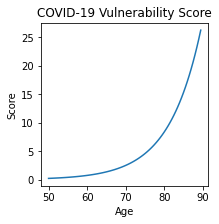

In [1043]:
# Plot of Vulnerability score
fig, ax = plt.subplots(figsize=(3,3))
rr=np.arange(50,90,0.5)
sns.lineplot(x=rr,y=10**(rr*0.0524-3.27))
ax=plt.gca()
ax.set_ylabel('Score')
ax.set_xlabel('Age')
ax.set_title('COVID-19 Vulnerability Score')
fig.savefig('Vulnerability.svg',dpi=300, bbox_inches = "tight")

In [1044]:
# apply cleaning to proteomics 

prot_els_cl=[ a + '_regPl_diff_cl' for a in prot_els]

for a in prot_els_regPl:
    out = remove_conf(data,a,[],flatten=True,suf_pre=True,remove_out=True,suf=False)
    data.loc[:,a+'_pre_cl'] = out[a+'_pre_cl']
    data.loc[:,a+'_post_cl'] = out[a+'_post_cl']

    data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
    data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']



## Reported Disease codes

In [1045]:
# Self reported
disease_codes=(data[(find_vars(data,'20002-2'))].values.flatten())
disease_codes=disease_codes[~pd.isnull(disease_codes)]
codes_counts=(pd.Series((disease_codes))).value_counts()
codes_counts=codes_counts[codes_counts>20].drop(99999.0)
codes_counts.index=codes_counts.index.astype(int)
for a in codes_counts.index:
    data.loc[:,'dc_'+str(int(a))]=(data[find_vars(data,'20002-2')]==a).any(axis=1)

disease_codes_names=pd.read_csv('/home/eduff/biobank/phenotype/disease_codes.tsv',sep='\t',header=None)
disease_codes_names.set_index(0,inplace=True)
disease_codes_names.rename(columns={1:'name'},inplace=True)

data=data.copy()    


In [1046]:
# Self reported

data['Diabetes2']=(data[(find_vars(data,'20002-'))]==1223).any(axis=1)
data['cardiovascular']=(data[(find_vars(data,'20002-'))]==1071).any(axis=1)
data['hypertension']=(data[(find_vars(data,'20002-'))]==1065).any(axis=1)
data['heart_cond']=(data[(find_vars(data,'20002-'))]==1066).any(axis=1)
data['depression']=(data[(find_vars(data,'20002-'))]==1312).any(axis=1)
data['cholesterol']=(data[(find_vars(data,'20002-'))]==1536).any(axis=1)
data['headinjury']=(data[(find_vars(data,'20002-'))]==1292).any(axis=1)
data['renal']=(data[(find_vars(data,'20002-'))]==1074).any(axis=1)
data['IBS']=(data[(find_vars(data,'20002-'))]==1154).any(axis=1)
data['COPD_ICD']=(data[(find_vars(data,'20002-'))]==1112).any(axis=1)
data['Bronc']=(data[(find_vars(data,'20002-'))]==1113).any(axis=1)

data['hearing-2.0']=data['2247-2.0']>0
data['hearing-3.0']=data['2247-3.0']>0


data['loneliness-2.0']=data['2020-2.0']>0
data['loneliness-3.0']=data['2020-3.0']>0

data['confide-2.0']=(data['2110-2.0']>-1)&(data['2110-2.0']<2)
data['confide-3.0']=(data['2110-3.0']>-1)&(data['2110-3.0']<2)

data['social_visits-2.0']=(data['1031-2.0']>3)
data['social_visits-3.0']=(data['1031-3.0']>3)

data['isolation-2.0']=data['confide-2.0']&data['social_visits-2.0']
data['isolation-2.0']=data['confide-3.0']&data['social_visits-3.0']

# define hypertension

data['hypertension_emp-2.0']=(data['4080-2.0']>130) & (data['4079-2.0']>80)
data['hypertension_emp-3.0']=(data['4080-3.0']>130) & (data['4079-3.0']>80)

## COVID reports

In [1047]:
# process records of COVID

data.loc[:,'GP']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==2).any(axis=1)
data.loc[:,'HES']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==1).any(axis=1)
data.loc[:,'PCR']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==3).any(axis=1)
data.loc[:,'Lateral']=((data.loc[all_case,['41001-3.0','41001-3.1','41001-3.2','41001-3.3']])==4).any(axis=1)
data.loc[:,'PublicHealthRecord']=(data.loc[:,'HES'])|(data.loc[:,'GP'])

# characterise individuals only identified by antibody test (no reported symptoms)

data.loc[:,'COVID'] = np.nan
els = all_matched & all_case & (data.loc[:,['HES','PCR','GP']].sum(axis=1)==0)  & (data.loc[:,'Lateral']==True)
data.loc[els,'COVID'] = 'SARS'
data.loc[data.loc[els,'matched_eid'].dropna(),'COVID'] = 'SARS_ctr'
els = all_case & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0)  
data.loc[els,'COVID'] = 'COVID'
data.loc[data.loc[els,'matched_eid'].dropna(),'COVID'] = 'COVID_ctr'

# load up reginal  COVID reports
England = pd.read_csv('/home/eduff/biobank/phenotype/covid19_result_england.txt', sep='\t')
Scotland = pd.read_csv('/home/eduff/biobank/phenotype/covid19_result_scotland.txt', sep='\t')
Wales = pd.read_csv('/home/eduff/biobank/phenotype/covid19_result_wales.txt', sep='\t')

print(England[England.eid.isin(data.index)].shape)
print(Scotland[Scotland.eid.isin(data.index)].shape)
print(Wales[Wales.eid.isin(data.index)].shape)

# remove subjects not in dataset
del Wales
England=England[England.eid.isin(data.index)]
Scotland=Scotland[Scotland.eid.isin(data.index)]               

Scotland.loc[:,'spectype']=np.nan
Scotland.loc[:,'origin']=np.nan
Scotland.loc[:,'acute']=np.nan
Scotland.loc[:,'hosaq']=np.nan
England.loc[:,'site']=np.nan

COVIDreports=pd.concat([England,Scotland])
COVIDreports.loc[:,'specdate']=pd.to_datetime(COVIDreports['specdate'],infer_datetime_format=True)

# convert to lists for each id

COVIDreports=COVIDreports.groupby(['eid']).agg(list)

# calculate time since first and most recent +ve test when available

for a in COVIDreports.index:
    
    # calculate first and last positive test before 3rd assessment
    results_pos=np.array(COVIDreports.loc[a,'result'])==1
    dates_pos=np.array(COVIDreports.loc[a,'specdate'])[results_pos]
    dates_pos=dates_pos[dates_pos < pd.to_datetime(data.loc[a,'53-3.0'])]
    if len(dates_pos)>0:
        COVIDreports.loc[a,'firstpos']=dates_pos.min()
        COVIDreports.loc[a,'lastpos']=dates_pos.max()
        COVIDreports.loc[a,'time_since_pos_d']=(pd.to_datetime(data.loc[a,'53-3.0']) - dates_pos.max())
        
        COVIDreports.loc[a,'time_since_first_pos_d']=(pd.to_datetime(data.loc[a,'53-3.0'])  - dates_pos.min())
        
    results_neg=np.array(COVIDreports.loc[a,'result'])==0
    dates_neg=np.array(COVIDreports.loc[a,'specdate'])[results_neg]  
    dates_neg=dates_neg[dates_neg < pd.to_datetime(data.loc[a,'53-3.0'])]
    
    if len(dates_neg) > len(dates_pos):
        COVIDreports.loc[a,'neg_reports']=True

COVIDreports.loc[:,'time_since_pos']=COVIDreports.loc[:,'time_since_pos_d'].dt.days
COVIDreports.loc[:,'time_since_first_pos']=COVIDreports.loc[:,'time_since_first_pos_d'].dt.days


(3413, 9)
(186, 6)
(0, 7)


In [1048]:
data=pd.merge(data, COVIDreports, left_index=True, right_index=True,how='left',suffixes=("_x",None))

## Define case / control variables and helper vars

In [1049]:
# hospitalisation and non-COVID

hosp=np.sum(np.max(data.loc[all_case,find_vars(data,'41270')]=='U071',axis=1))
main_hosp=(data.loc[:,find_vars(data,'41202')]=='U071').any(axis=1)
secondary_hosp=(data.loc[:,find_vars(data,'41204')]=='U071').any(axis=1)&~main_hosp
data.loc[:,'main_hosp']=np.max(data.loc[:,find_vars(data,'41202')]=='U071',axis=1)

# hospitalisation dates
vars_h=(find_vars(data,'41270'))

[rws,cls] = np.where(data.loc[:,vars_h]=='U071')
for el in range(len(cls)):
    eid=data.index[rws[el]]
    col= '41280-0.'+ vars_h[cls[el]][8:]
    date_pos = pd.to_datetime(data.loc[eid,col])
    if date_pos < pd.to_datetime(data.loc[eid,'53-3.0']):
        if pd.isnull(data.loc[eid,'firstpos']):
            
            data.loc[eid,'firstpos']=date_pos
            data.loc[eid,'lastpos']=date_pos
        else:
            if date_pos < data.loc[eid,'firstpos']:
                
                data.loc[eid,'firstpos']=date_pos
            if date_pos > data.loc[eid,'lastpos']:
                
                data.loc[eid,'lastpos']=date_pos
      
# hospitalisation    
data.loc[data['Case']=='ctr','Case_hosp'] = 'ctr'
data.loc[data['Case']=='sars','Case_hosp'] = 'sars'
data.loc[data['main_hosp'],'Case_hosp'] = 'sars_hosp'

data.loc[:,'Case_hosp_matched']=np.nan
data.loc[data['Case']=='sars','Case_hosp_matched'] = 'sars'
data.loc[data['main_hosp'],'Case_hosp_matched'] = 'sars_hosp'
data.loc[data.loc[data['Case_hosp']=='sars','matched_eid'].dropna(),'Case_hosp_matched'] = 'ctr_sars' 
data.loc[data.loc[data['Case_hosp']=='sars_hosp','matched_eid'].dropna(),'Case_hosp_matched'] = 'ctr_sars_hosp' 

data.loc[:,'Case_hosp_bin']=0
data.loc[data.loc[:,'Case_hosp_matched']=='sars_hosp','Case_hosp_bin']=0.5
data.loc[data.loc[:,'Case_hosp_matched']=='ctr_sars_hosp','Case_hosp_bin']=-0.5

data.loc[:,'Case_hosp_bin_only']=0
data.loc[data.loc[:,'Case_hosp_matched']=='sars_hosp','Case_hosp_bin_only']=0.5
data.loc[data.loc[:,'Case_hosp_matched']=='ctr_sars_hosp','Case_hosp_bin_only']=-0.5

data.loc[:,'Case_nohosp_bin_only']=0
data.loc[data.loc[:,'Case_hosp_matched']=='sars','Case_nohosp_bin_only']=0.5
data.loc[data.loc[:,'Case_hosp_matched']=='ctr_sars','Case_nohosp_bin_only']=-0.5
    
data['Case_hosp_bin_neg']=data['Case_hosp_bin']
els=data['Case_hosp_bin']>0
data.loc[data.loc[els,'matched_eid'].dropna(),'Case_hosp_bin_neg']=-1


data.loc[:,'COVID_bin']=0
data.loc[data['COVID']=='COVID_ctr','COVID_bin']=-1
data.loc[data['COVID']=='COVID','COVID_bin']=1
    
# COVID death (0)
np.sum(np.max(data.loc[all_case,find_vars(data,'40002')]=='U071',axis=1))
np.sum(np.max(data.loc[all_case,find_vars(data,'40001')]=='U071',axis=1))
np.sum(np.max(data.loc[all_case,find_vars(data,'40007')],axis=1))

# Wave 1-6 Hospitalisation report
np.sum(data.loc[:,find_vars(data,'28029')]=='1')

# first vacination prior to pos
data.loc[:,'vac_prior_first_pos']=np.nan  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - COVIDreports.loc[:,'firstpos']).dt.days
data.loc[diff<0,'vac_prior_first_pos']='prior'
data.loc[diff>0,'vac_prior_first_pos']='post'

# first vaccination prior to assessment 
data.loc[:,'vac_prior_assess']=np.nan  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - pd.to_datetime(data.loc[:,'53-3.0'])).dt.days
data.loc[diff<0,'vac_prior_assess']=True
data.loc[diff>0,'vac_prior_assess']=False

# first vaccination prior to pos
data.loc[:,'vac_prior_first_pos']=np.nan  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - COVIDreports.loc[:,'firstpos']).dt.days
data.loc[diff<0,'vac_prior_first_pos']=True
data.loc[diff>0,'vac_prior_first_pos']=False


# vaccination
data.loc[:,'Case_vax_prior_bin']=0
data.loc[data['vac_prior_first_pos']=='prior','Case_vax_prior_bin']=1
els=data['Case_vax_prior_bin']>0
#data.loc[data.loc[els,'matched_eid'].dropna(),'Case_vax_prior_bin']=-1
data.loc[data['vac_prior_first_pos']=='post','Case_vax_prior_bin']=-1

data['Case_vax']=data['Case']
data.loc[data['vac_prior_first_pos']=='prior','Case_vax']='vax'


In [1050]:
# first vaccination prior to assessment 
data.loc[:,'vac_prior_assess']=np.nan  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - pd.to_datetime(data.loc[:,'53-3.0'])).dt.days
data.loc[diff<0,'vac_prior_assess']=True
data.loc[diff>0,'vac_prior_assess']=False

# first vaccination prior to pos
data.loc[:,'vac_prior_first_pos']=np.nan  
diff=(pd.to_datetime(data.loc[:,'27984-0.0']) - COVIDreports.loc[:,'firstpos']).dt.days
data.loc[diff<0,'vac_prior_first_pos']=True
data.loc[diff>0,'vac_prior_first_pos']=False

In [1051]:
# vaccinations
print(data.loc[all_matched,'vac_prior_first_pos'].sum())
print(data.loc[all_matched,'vac_prior_first_pos'].notna().sum())

40
289


In [1052]:
# CHECK THRIVA
## THRIVA - followup antibody test
THRIVA_ids=data.loc[(data.loc[:,'27990-0.0']==1) & (data.loc[:,'Case']=='sars'),'matched_eid'].dropna().index
THRIVA_ctr_ids=data.loc[THRIVA_ids,'matched_eid']
THRIVA_ids=data.loc[(data.loc[:,'27990-0.0']==1) & (data.loc[:,'Case']=='sars'),'matched_eid'].dropna().index

data.loc[:,'THRIVA_pos']=np.NaN
data.loc[THRIVA_ids,'THRIVA_pos']='THRIVA_pos'
data.loc[THRIVA_ctr_ids,'THRIVA_pos']='ctr_THRIVA_pos'

In [1053]:
# self tests:  27981, 27990, 28140
data.loc[((data.loc[:,'27990-0.0']!=1) | (data.loc[:,'27981-0.0']!=1) | (data.loc[:,'28140-0.0']!=1) ) & (data.loc[:,'Case']=='ctr')]

print(len(data.loc[(data.loc[:,'27981-0.0']==0) & (data.loc[:,'Case']=='ctr')]))

print(len(data.loc[(data.loc[:,'28140-0.0']==0) & (data.loc[:,'Case']=='ctr')]))

439
40


In [1054]:
# calculate post - pre differences and percentage change for a variety of variables

prot_els_diff=[]    
for IDP in prot_els + prot_els_regPl:
    name=IDP+'_diff'
    prot_els_diff.append(name)
    data.loc[:,name]=(data.loc[:,IDP+'_post']) - (data.loc[:,IDP+'_pre'])
    
# also adjust original verions of proteins log normalised   
for IDP in ['pTau-181','GFAP','NfL']:
    IDP=IDP+'_orig'
    name=IDP+'_diff'
    prot_els_diff.append(name)
    data.loc[:,name]=(data.loc[:,IDP+'_post']) - (data.loc[:,IDP+'_pre'])

for IDP in ['27183-2.0','27004-2.0','26593-2.0','6350-2.0','6348-2.0','27163-2.0','27202-2.0','27200-2.0','27293-2.0','6350-2.0','Age-2.0','4080-2.0','4079-2.0','21002-2.0','21001-2.0','Alcohol-2.0','738-2.0','709-2.0','6350-2.0','20018-2.0','2178-2.0','25781-2.0']:
    IDP=IDP[:-4]
    data.loc[:,IDP+'_diff']=(data.loc[:,IDP+'-3.0']) - (data.loc[:,IDP+'-2.0'])
    
IDP='27183' # lOBC (thick)
IDP='27004'  # lpHg (cont)
IDP='26593' # hipp volume

for IDP in ['27183-2.0','27004-2.0','26593-2.0','6350-2.0','6348-2.0','27163-2.0','27202-2.0','27200-2.0','27293-2.0','6350-2.0','Age-2.0','4080-2.0','4079-2.0','21002-2.0','21001-2.0','Alcohol-2.0','738-2.0','709-2.0','6350-2.0','20018-2.0','2178-2.0','25781-2.0']:
    IDP=IDP[:-4]
    data.loc[:,IDP+'-pc']=100*(data.loc[:,IDP+'-3.0']-data.loc[:,IDP+'-2.0'])/data.loc[:,IDP+'-2.0']


# percentage change
prot_els_pc=[]    
for IDP in prot_els + prot_els_regPl:
    name=IDP+'-pc'
    prot_els_pc.append(name)
    data.loc[:,name]=100*(data.loc[:,IDP+'_post']-data.loc[:,IDP+'_pre'])/data.loc[:,IDP+'_pre']
    
for IDP in ['pTau-181','GFAP','NfL']:
    IDP=IDP+'_orig'
    name=IDP+'-pc'
    prot_els_pc.append(name)
    data.loc[:,name]=100*(data.loc[:,IDP+'_post']-data.loc[:,IDP+'_pre'])/data.loc[:,IDP+'_pre']
    
for IDP in ['pTau-181','GFAP','NfL']:
    IDP=IDP+'_orig_regPl'
    name=IDP+'-pc'
    prot_els_pc.append(name)
    data.loc[:,name]=100*(data.loc[:,IDP+'_post']-data.loc[:,IDP+'_pre'])/data.loc[:,IDP+'_pre']
    
data=data.copy()

In [1055]:
# employment information
for a in ['2','3']:
    data['paid_employ-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==1).sum(axis=1)>0
    data.loc[:,'retired-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==2).sum(axis=1)>0
    data.loc[:,'caring-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==3).sum(axis=1)>0
    data.loc[:,'no_employ-sick-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==4).sum(axis=1)>0
    data.loc[:,'unemployed-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==4).sum(axis=1)>0
    data.loc[:,'voluntary-'+a+'.0']=(data.loc[:,find_vars(data,'^6142-'+a+'.')]==6).sum(axis=1)>0
    negs=((data.loc[:,find_vars(data,'^6142-'+a+'.')]).sum(axis=1)<0)
    data.loc[negs,'paid_employ-'+a+'.0']=np.nan
    data.loc[negs,'retired-'+a+'.0']=np.nan
    data.loc[negs,'caring-'+a+'.0']=np.nan
    data.loc[negs,'no_employ-sick-'+a+'.0']=np.nan
    data.loc[negs,'unemployed-'+a+'.0']=np.nan
    data.loc[negs,'voluntary-'+a+'.0']=np.nan
 
    # not converting paid_emply to not flip in table alg
    data['paid_employ-'+a+'.0']=data['paid_employ-'+a+'.0'].convert_dtypes()
    data['paid_employ_bin-'+a+'.0']=data['paid_employ-'+a+'.0'].astype(float)
    data['retired-'+a+'.0']=data['retired-'+a+'.0'].convert_dtypes()
    data['retired_bin-'+a+'.0']=data['retired-'+a+'.0'].astype(float)
    data['caring-'+a+'.0']=data['caring-'+a+'.0'].convert_dtypes()
    data['no_employ-sick-'+a+'.0']=data['no_employ-sick-'+a+'.0'].convert_dtypes()
    data['unemployed-'+a+'.0']=data['unemployed-'+a+'.0'].convert_dtypes()
    data['voluntary-'+a+'.0']=data['voluntary-'+a+'.0'].convert_dtypes()


# Preprocess Imaging and Cognitive vars


In [1056]:

# Imaging variables for AD brain phenotypes
#26562	Volume of Hippocampus (left hemisphere)	Freesurfer ASEG  
#26593	Volume of Hippocampus (right hemisphere)	Freesurfer ASEG  
#26641	Volume of Whole-hippocampus (left hemisphere)	Freesurfer subsegmentation  
#26663	Volume of Whole-hippocampus (right hemisphere)	Freesurfer subsegmentation  
#25886	Volume of grey matter in Hippocampus (left)	Regional grey matter volumes (FAST)  
#25887	Volume of grey matter in Hippocampus (right)	Regional grey matter volumes (FAST)  
#25019	Volume of hippocampus (left)	Subcortical volumes (FIRST)  
#5020	Volume of hippocampus (right)
    
#27432	Mean thickness of G-precuneus (left hemisphere)	Freesurfer a2009s  
#27654	Mean thickness of G-precuneus (right hemisphere)	Freesurfer a2009s  
#26779	Mean thickness of precuneus (left hemisphere)	Freesurfer desikan white  
#27196	Mean thickness of precuneus (left hemisphere)	Freesurfer DKT  
#26880	Mean thickness of precuneus (right hemisphere)	Freesurfer desikan white  
#27289	Mean thickness of precuneus (right hemisphere)	Freesurfer DKT  
# WM hyperintensities 
np.sum(data.loc[all_matched & (data['Case']=='sars'),'25781-2.0']<1000)

class Cols:
    Weight = "21002"
    Hip = "48"
    BMI = "49"
    Alcohol = "1558"
    BP_sys = "4080"
    BP_dia = "4079"
    lOBC='27183' # lOBC (thick)
    lpHg='27004'  # lpHg (cont)
    HippVol='26593' # hipp volume
    EntL_DKT_mt='27177'
    EntR_DKT_mt='27270'


#  RSNs 
RSNs=np.array(['DMN1','Vis1','SMot1','DMN2','Att1','Att2','DMN3','Vis2','Vis3','SMot2','SMot3','SMot4','Temp1','Front1','Cb1','DMN4','Front2','BG1','Vis4','DMN5','Temp2'])
DMNs=['DMN' in a for a in RSNs]
Viss=['Vis' in a for a in RSNs]
SMots=['SMot' in a for a in RSNs]
Atts=['Att' in a for a in RSNs]
Cbs=['Cb' in a for a in RSNs]
BGs=['BG' in a for a in RSNs]
Fronts=['Front' in a for a in RSNs]
Temps=['Temp'in a for a in RSNs]
RSN_groups=[DMNs,Viss,SMots,Atts,Cbs,BGs,Fronts,Temps]
RSN_group_names=['DMN','Vis','SMot','Att','Cb','BG','Front','Temp']

# core confound variables
# imaging vars 

# trail making
for a in ['6350','6348']:
    out=(remove_conf(data,a,pos=True,remove_out=True,log=True,flatten=True))
    data.loc[:,[a+'_cl-2.0',a+'_cl-3.0']]=out.loc[:,[a+'-2.0_cl',a+'-3.0_cl']].values
# RT
data.loc[:,'RT-2.0']=np.log(data.loc[:,'20023-2.0'])
data.loc[:,'RT-3.0']=np.log(data.loc[:,'20023-3.0'])

# pairs matching
data.loc[:,'Pairs-2.0']=np.log(1+data.loc[:,'399-2.2'])
data.loc[:,'Pairs-3.0']=np.log(1+data.loc[:,'399-3.2'])
      
# Prospective memory 20018
data.loc[:,'ProsMem-2.0']=np.mod(data.loc[:,'20018-2.0'],2)
data.loc[:,'ProsMem-3.0']=np.mod(data.loc[:,'20018-3.0'],2)

# Fluid Intell 20016
                 
# Numeric memory 4282
data.loc[:,'NumMem-2.0'] = data.loc[:,'4282-2.0'] 
data.loc[data.loc[:,'NumMem-2.0']==-1,'4282-2.0'] = np.nan
data.loc[:,'NumMem-3.0'] = data.loc[:,'4282-3.0'] 
data.loc[data.loc[:,'NumMem-3.0']==-1,'4282-3.0'] = np.nan

# digit substitution 23324

# trail making b, pairs(2), Reaction Time Test ,

# picture vocab 6364

# paired associate 20197

# tower rearranging 21004

# matrix pattern completion 6373

cog_vars=['6350','6348','4282','20018']
cog_vars_gi=['Pairs','RT','ProsMem','20016','NumMem','6350_cl','23324','6364','20197','21004','6373']
cog_vars_gi_weights=np.array([-0.49,-0.41,0.54,0.66,0.58,-0.79,0.73,0.19,0.49,0.65,0.66])
cog_vars_alz_weights=np.array([0,0,0,0.66,0.58,0,0,0,0,0,0.66])

for a in ['-2.0','-3.0']:
    cols=[col+a for col in cog_vars_gi]
    df=data.loc[:,[]]
    for id in data.index:
        if np.sum(data.loc[id,cols].notna())==11:
            df.loc[id,'cog_vars_gi'+a]=np.dot(data.loc[id,cols],cog_vars_gi_weights)
            df.loc[id,'cog_vars_alz'+a]=np.dot(data.loc[id,cols],cog_vars_alz_weights)
        else:
            df.loc[id,'cog_vars_gi'+a]=np.nan
            df.loc[id,'cog_vars_alz'+a]=np.nan         

    data.loc[:,'cog_vars_gi'+a]=df.loc[:,'cog_vars_gi'+a]
    data.loc[:,'cog_vars_alz'+a]=df.loc[:,'cog_vars_alz'+a]

data.loc[:,'cog_vars_gi_diff'] = data.loc[:,'cog_vars_gi-3.0'] - data.loc[:,'cog_vars_gi-2.0']
data.loc[:,'cog_vars_gi_diff_cl'] = data.loc[:,'cog_vars_gi_diff']
data.loc[:,'cog_vars_alz_diff'] = data.loc[:,'cog_vars_alz-3.0'] - data.loc[:,'cog_vars_alz-2.0']
data.loc[:,'cog_vars_alz_diff_cl'] = data.loc[:,'cog_vars_alz_diff'] 

data.loc[:,'cog_vars_gi_post_cl'] = data.loc[:,'cog_vars_gi-3.0'] 
data.loc[:,'cog_vars_gi_pre_cl']= data.loc[:,'cog_vars_gi-2.0']
data.loc[:,'cog_vars_alz_post_cl'] = data.loc[:,'cog_vars_alz-3.0'] 
data.loc[:,'cog_vars_alz_pre_cl']= data.loc[:,'cog_vars_alz-2.0']

# UKB Pairs Matching Test -0.49 
# UKB Reaction Time Test -0.41
# UKB Prospective Memory Test 0.54 
# UKB Fluid Intelligence Test 0.66
# UKB Numeric Memory Test 0.58 
# UKB Trail Making Test part B -0.79 
# UKB Symbol Digit Test 0.73 
# UKB Picture Vocabulary Test 0.19 
# UKB Paired Associate Learning Test 0.49
# UKB Tower Test 0.65 
# UKB Matrix Pattern Test 0.66 
    
IDP_info=pd.read_excel('/home/eduff/biobank/imaging/media-2.xlsx')
    
imaging_vars= ['26593','27177','27004','27183','25093','25494','26562','25793','27202','27200','27293','27146','27239']
hipp_vars=['26562','26593', '26641', '26663', '25886', '25887', '25019', '25020']
prec_vars=['27432' , '27654'  , '26779', '27196', '26880' , '27289']
ent_vars=['27177','27270']
RSN_ampvars=[a + '_Amp' for a in RSNs ]
RSN_corrvars=['DMN_'+a + '_Corr' for a in RSN_group_names[1:] ]
imaging_vars=imaging_vars+hipp_vars+prec_vars+ent_vars # +RSN_ampvars+RSN_corrvars
#imaging_vars_ro_norm = [ a + '_norm' for a in imaging_vars]

#[head_size_scaling conf_TablePos_COG_Table conf_TablePos_COG_Z conf_YTRANS age];
CONF1_vars = ['25000', '25759',  '25758', '25757', 'Age']
#CONF1_vars_ro = [a +'_ro' for a in ['25000', '25759',  '25758', '25757', 'Age']]

# second set of confound IDPs
# Weight, Waist Circ, Hip Circ, BMI, BPdia, BPsys, SMOKING, Alcohol, Diabetes, Chol_med, BP_meds,'Deprivation'
CONF2_vars = ['21002','48','49','21001','4079', '4080', 'Smoking','Alcohol','Diabetes','Chol_meds','BP_meds','Deprivation']

# remove outliers conf vars
#data.loc[:,CONF1_vars_ro]=remove_outliers(data.loc[all_matched,CONF1_vars],15,repl=0,visits=False).values
#data.loc[:,imaging_vars_ro]=remove_outliers(data.loc[:,imaging_vars],8).values


for a in imaging_vars: 
    # deconfound headsize etc
    data.loc[:,[a+'-2.0_cl',a+'-3.0_cl']]=remove_conf(data,a,CONF1_vars[:-1],remove_out=True)

    # remove difference outliers 
    CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','Gender_pre']
    naels=remove_outliers(remove_conf(data,a+'-3.0_cl',CONF+[a+'-2.0_cl'],flatten=False,suf=False)).isna()

    for pref in ['-3.0_cl','-2.0_cl']:
        data.loc[naels.squeeze(),a+pref]=np.nan
    
    data.loc[:,a+'_diff_cl'] = data[a+'-3.0_cl']-data[a+'-2.0_cl']
    data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'-2.0_cl']
    

    

In [1057]:
#os.chdir('/home/eduff/biobank/'
# names of IDPs
IDP_info=pd.read_excel('/home/eduff/biobank/imaging/media-2.xlsx',)
IDP_info.set_index('UKB ID')
IDP_info['IDP short name']=IDP_info['IDP short name'].str.replace(" ","_")
IDP_info['IDP short name'][IDP_info['IDP short name'].str.contains('bankssts')]

343        aparc-Desikan_lh_volume_bankssts
376        aparc-Desikan_rh_volume_bankssts
648          aparc-Desikan_lh_area_bankssts
682          aparc-Desikan_rh_area_bankssts
716             aparc-pial_lh_area_bankssts
749             aparc-pial_rh_area_bankssts
1020    aparc-Desikan_lh_thickness_bankssts
1054    aparc-Desikan_rh_thickness_bankssts
1367      wg_lh_intensity-contrast_bankssts
1402      wg_rh_intensity-contrast_bankssts
Name: IDP short name, dtype: object

### Extract ADNI AD signature 

In [1058]:
features_cort = ['thickness_bankssts_lh',  'thickness_caudalanteriorcingulate_lh', 'thickness_caudalmiddlefrontal_lh',  'thickness_cuneus_lh',  'thickness_entorhinal_lh',  'thickness_fusiform_lh',  'thickness_inferiorparietal_lh',  'thickness_inferiortemporal_lh',  'thickness_isthmuscingulate_lh',  'thickness_lateraloccipital_lh',  'thickness_lateralorbitofrontal_lh',  'thickness_lingual_lh',  'thickness_medialorbitofrontal_lh',  'thickness_middletemporal_lh',  'thickness_parahippocampal_lh',  'thickness_paracentral_lh',  'thickness_parsopercularis_lh',  'thickness_parsorbitalis_lh',  'thickness_parstriangularis_lh',  'thickness_pericalcarine_lh',  'thickness_postcentral_lh',  'thickness_posteriorcingulate_lh',  'thickness_precentral_lh',  'thickness_precuneus_lh',  'thickness_rostralanteriorcingulate_lh', 'thickness_rostralmiddlefrontal_lh',  'thickness_superiorfrontal_lh',  'thickness_superiorparietal_lh',  'thickness_superiortemporal_lh',  'thickness_supramarginal_lh',  'thickness_frontalpole_lh',  'thickness_temporalpole_lh',  'thickness_transversetemporal_lh',  'thickness_insula_lh',  'thickness_bankssts_rh',  'thickness_caudalanteriorcingulate_rh', 'thickness_caudalmiddlefrontal_rh',  'thickness_cuneus_rh',  'thickness_entorhinal_rh',  'thickness_fusiform_rh',  'thickness_inferiorparietal_rh',  'thickness_inferiortemporal_rh',  'thickness_isthmuscingulate_rh',  'thickness_lateraloccipital_rh',  'thickness_lateralorbitofrontal_rh',  'thickness_lingual_rh',  'thickness_medialorbitofrontal_rh',  'thickness_middletemporal_rh',  'thickness_parahippocampal_rh',  'thickness_paracentral_rh',  'thickness_parsopercularis_rh',  'thickness_parsorbitalis_rh',  'thickness_parstriangularis_rh',  'thickness_pericalcarine_rh',  'thickness_postcentral_rh',  'thickness_posteriorcingulate_rh',  'thickness_precentral_rh',  'thickness_precuneus_rh',  'thickness_rostralanteriorcingulate_rh', 'thickness_rostralmiddlefrontal_rh',  'thickness_superiorfrontal_rh',  'thickness_superiorparietal_rh',  'thickness_superiortemporal_rh',  'thickness_supramarginal_rh',  'thickness_frontalpole_rh',  'thickness_temporalpole_rh',  'thickness_transversetemporal_rh',  'thickness_insula_rh']
missing_feats=[]
features_cort_ids=[]
for a in features_cort:
    names=IDP_info['IDP short name'][IDP_info['IDP short name'].str.contains(a[:-3])]
    ukb_name=([s for s in names.values if re.search('Desikan*'+a[-3:],s)])
    if ukb_name == []:
        missing_feats.append(a)
        print(a)
    else:
        features_cort_ids.append(int(IDP_info.loc[IDP_info['IDP short name']==ukb_name[0],'UKB ID']))

features_vol = [ a.replace('thickness','volume') for a in features_cort]
features_vol_ids=[]
for a in features_vol:
    names=IDP_info['IDP short name'][IDP_info['IDP short name'].str.contains(a[:-3])]
    ukb_name=([s for s in names.values if re.search('Desikan*'+a[-3:],s)])
    if ukb_name == []:
        missing_feats.append(a)
        print(names)
        print(a)
    else:
        features_vol_ids.append(int(IDP_info.loc[IDP_info['IDP short name']==ukb_name[0],'UKB ID']))



thickness_temporalpole_lh
thickness_temporalpole_rh
Series([], Name: IDP short name, dtype: object)
volume_temporalpole_lh
Series([], Name: IDP short name, dtype: object)
volume_temporalpole_rh


In [1059]:
features_vol_extra = ['volume_Left-Cerebellum-White-Matter', 'volume_Left-Cerebellum-Cortex',
                          'volume_Left-Thalamus-Proper', 'volume_Left-Caudate', 'volume_Left-Putamen',
                          'volume_Left-Pallidum','volume_Brain-Stem', 'volume_Left-Hippocampus', 
                          'volume_Left-Amygdala', 'volume_Left-Accumbens-area', 'volume_Right-Cerebellum-White-Matter',
                          'volume_Right-Cerebellum-Cortex', 'volume_Right-Thalamus-Proper', 'volume_Right-Caudate',
                          'volume_Right-Putamen', 'volume_Right-Pallidum', 'volume_Right-Hippocampus', 
                          'volume_Right-Amygdala', 'volume_Right-Accumbens-area']
print(len(features_vol_extra))
features_vol_extra_ids = [26556,26557,26558,26559,26560,26561,26526,26562,26563,26564, 26587,26588,26559,26590,26591,26592,26593,26594,26595]
len(features_vol_extra_ids) 

19


19

In [1060]:
df_ml = pd.DataFrame(columns=features_cort+features_vol+features_vol_extra)
all_ni_ad_feats=features_cort+features_vol+features_vol_extra
pres_ni_ad_feats_ids=features_cort_ids+features_vol_ids+features_vol_extra_ids
pres_ni_ad_feats=([a for a in all_ni_ad_feats if a not in missing_feats ])


In [1061]:
ad_feats={}
for session in ['2','3']:
    sess_str='-'+session+'.0'
    ad_feats[session]=data.loc[:,[str(a)+sess_str for a in pres_ni_ad_feats_ids]]
    ad_feats[session]=ad_feats[session].set_axis(pres_ni_ad_feats,axis=1)
    for a in missing_feats:
        ad_feats[session].loc[:,a]=0

    ad_feats[session].loc[:,'gender'] = data.loc[:,'Gender_pre']
    ad_feats[session].loc[:,'age'] = data.loc[:,'Age'+sess_str]
    ad_feats[session].loc[:,'eTIV'] = data.loc[:,'26521'+sess_str]
 

In [1062]:
# Preprocess ADNI data

import pandas as pd
import statsmodels.api as smfapi

from sklearn.preprocessing import StandardScaler
import joblib 

def calculate_residuals(data, columns, name_regress):
    for c in columns:
        lin_model = smfapi.load(f'../../imaging/adni_phenotypes/regress_models/{name_regress}_{c}.pkl')
        
        data[c] = data[c] - lin_model.predict(data)
    return data

In [1063]:
# Calculate residuals and scale for ukb data (load model and calculate from previously fitted adni data)
scaler = joblib.load('../../imaging/adni_phenotypes/data/adni_train_scaler.joblib')
scaler.mean_

ad_feats_scaled={}

for session in ['2','3']:
    ad_feats[session]=calculate_residuals(data=ad_feats[session], columns=features_cort, name_regress='adni')
    ad_feats[session]=calculate_residuals(data=ad_feats[session], columns=features_vol+features_vol_extra, name_regress='adni')

# Removing demographic columns and putting in the right order for scaler
    ad_feats[session]=ad_feats[session][features_cort + features_vol + features_vol_extra]
    ad_feats_scaled[session] = pd.DataFrame(scaler.transform(ad_feats[session]), columns=ad_feats[session].columns, index=ad_feats[session].index)

    ad_feats_scaled[session].to_csv('ukb_scaled_corrected_'+session+'.csv')

In [1064]:
ad_results={}
for session in ['2','3']:
    ad_results[session]=pd.read_csv('../../imaging/adni_phenotypes/results/adni_results_'+session+'.csv')
    ad_results[session]=ad_results[session].set_index('ukb_id')
    for b in ['mean','std']:
        data.loc[:,'adni_'+b+'-'+session+'.0']=ad_results[session][b]

In [1065]:
#data.loc[:,'adni-3.0']=
for a in ['adni_mean']:
    out=(remove_conf(data,a,pos=True,remove_out=True,log=True,flatten=True))
    data.loc[:,[a+'_cl-2.0',a+'_cl-3.0']]=out.loc[:,[a+'-2.0_cl',a+'-3.0_cl']].values
data.loc[:,'adni_mean_cl_diff']=data.loc[:,'adni_mean_cl-3.0']-data.loc[:,'adni_mean_cl-2.0']
data.loc[:,'adni_mean_diff']=data.loc[:,'adni_mean-3.0']-data.loc[:,'adni_mean-2.0']
data['adni_mean_pre_cl']=data['adni_mean_cl-2.0']
data['adni_mean_post_cl']=data['adni_mean_cl-3.0']
data['adni_mean_diff_cl']=data['adni_mean_cl_diff']
os.chdir('/home/eduff/biobank/')

In [1066]:
# # Data for Liz
# liz_vars=[]
# for a in ['21001','4079','4080','102','6152','6150','2443','2453','6142','709','738','1558','20116',
# '21022','31','20118','22189','21000','6138','54']:
#     liz_vars=liz_vars+find_vars(data,"^"+a+"-")
# with open('liz_vars.txt', 'w') as f:
#     for line in liz_vars:
#         f.write(f"{line}\n")
# f.close()
# data.loc[:,liz_vars].to_csv('liz_vars.csv')

# OLINK

In [1067]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin
import sklearn.model_selection
from  sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier 


#warnings.filterwarnings("ignore", category=DeprecationWarning).simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [1068]:
os.chdir('/home/eduff/biobank/Proteomics/OLINK')

In [1069]:
os.chdir('/home/eduff/biobank/Proteomics/OLINK')
# OLINK_data=pd.read_csv('olink_data2.txt',sep='\t')

# eids_OLINK=OLINK_data[OLINK_data['ins_index']==2]['eid'].unique()
# eids_SIMOA=data.index.unique()
# common_eids = np.union1d(eids_OLINK,data.index)
# np.savetxt('subjects_OLINK.txt',common_eids),fmt='%10.0f')

# OLINK=pd.DataFrame(index=np.unique(OLINK_data['eid']))
# Plists={}
# Plists[0]=[]
# Plists[2]=[]
# Plists[3]=[]

# Plists['all'] = OLINK_data['protein_id'].unique()

# for a in Plists['all']:
#     for b in [0,2,3]:
#         Plists[b].append('P_' + str(a) + '-' + str(b))
#         els=(OLINK_data['protein_id']==a)&(OLINK_data['ins_index']==b)
#         outsuff='0'
#         if b==2:
#             outsuff='pre'
#         elif b==3:
#             outsuff='post'
#         OLINK.loc[OLINK_data.loc[els,'eid'],'P_' + str(a) + '_' + outsuff] = OLINK_data.loc[els,'result'].values
        
OLINK_meta=pd.read_csv('ukb672393.csv')
OLINK_meta=OLINK_meta.set_index('eid')
OLINK_meta=OLINK_meta.loc[data.index,:]

In [1070]:
# Plists['all'] = list(OLINK_data['protein_id'].unique())
# #  participants with too many missing vals
# parts_t0=(OLINK.loc[:,Plists[0]].notnull().sum(axis=1)>500)
# parts_t23=(OLINK.loc[:,Plists[2]].notnull().sum(axis=1)>500) & (OLINK.loc[:,Plists[3]].notnull().sum(axis=1)>500)

# common_eids=np.array([ a in data.index for a in OLINK.index])
# remain_eids = (~common_eids & parts_t0)
# common_eids = (common_eids & parts_t23 & parts_t0)
# common_eids_0 = (common_eids & parts_t23 )

In [1071]:
# coding = pd.read_csv('coding143.tsv',sep='\t',index_col=0)
# coding.loc[:,'Protein']=np.nan
# coding.loc[:,'Protein']=coding['meaning'].str.extract('(.*);').values

# OLINK.columns=[a.replace('-post','_post') for a in OLINK.columns]
# OLINK.columns=[a.replace('-pre','_pre') for a in OLINK.columns]

# repl={}
# for a in coding.index:
#     cols=OLINK.columns[OLINK.columns.str.contains('_'+str(a)+'-')]
    
#     for col in cols:
#         repl[col]=col.replace('_'+str(a)+'-','_'+coding.loc[a,'Protein']+'_')
# OLINK=OLINK.rename(columns=repl)
# OLINK.columns=[a.replace('_2','_pre') for a in OLINK.columns]
# OLINK.columns=[a.replace('_3','_post') for a in OLINK.columns]
# OLINK.to_csv('OLINK_data.csv')



In [1072]:

# OLINK=pd.read_csv('/home/eduff/biobank/Proteomics/OLINK/OLINK_data.csv',index_col=0)
# OLINK.columns=[a.replace('_3','_post') for a in OLINK.columns]
# OLINK.columns=[a.replace('_2','_pre') for a in OLINK.columns]
# cols=(OLINK.loc[:,OLINK.columns.str.contains('_pre')].notna().sum()>20)
# cols=list(cols[cols].index.values)

# all_OLINK=(OLINK[cols].notna().sum(axis=1))>0
# OLINK_matched=(data.loc[:,'matched']==True) & all_OLINK)
# eids_OLINK=eids_OLINK[eids_OLINK].index.values

# common_eids = np.union1d(eids_OLINK,data.index)

# #eids_OLINK=OLINK_data[OLINK_data['ins_index']==2]['eid'].unique()

In [1073]:
OLINK=pd.read_csv('/home/eduff/biobank/Proteomics/OLINK/OLINK_data_COVID.csv',index_col=0)

eids_OLINK=OLINK.index.values # (OLINK[cols].notna().sum(axis=1))>0

In [1074]:
# estimate number of available samples

data.loc[:,'OLINK']=False
data.loc[eids_OLINK,'OLINK']=True
((data.loc[eids_OLINK,'matched'] & (data.loc[eids_OLINK,'matched_eid'].notna())).sum())

873

In [1076]:
((data.loc[eids_OLINK,'matched'] & (data.loc[eids_OLINK,'matched_eid'].notna())&all_case&all_matched).sum())
data.loc[eids_OLINK,OLINK.columns]=OLINK.loc[eids_OLINK,:]

In [1077]:
SIMOA_assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']
OLINK_assays_red=['P_NEFL','P_GFAP' ,'P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C1QTNF1','P_C1QL2','P_C4BPB','P_IL6','P_IL18']
OLINK_assays=['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_IL6','P_IL18','P_VWF','P_TNF','P_IL1A','P_IL1B','P_IFNG','P_PTX3','P_CALCA','P_GZMB','P_GDNF','P_NGF','P_GDF15', 'P_TNFSF10','P_TNFRSF10A','P_TNFRSF10B', 'P_BCAN', 'P_GFAP', 'P_NEFL','P_PIGR','P_CHI3L1','P_L1CAM','P_NCAM1','Alzheimers_dementia','Vascular_dementia']
OLINK_assays_final=['P_IL1A','P_IL1B','P_IL6','P_IL18','P_IFNG','P_TNF','P_TNFSF10','P_C1QA', 'P_C4BPB','P_CHI3L1','P_MIF','P_PTX3','P_CALCA',]# 'P_TINAGL1','P_GDF15','P_ICA1','P_CDON','P_BCAN','P_ADGRG1','P_INPPL1','P_EDA2R','P_KDR','P_ADAMTS8','P_P4HB','P_ODAM','P_ATF2']
,'P_C1QA', 'P_C4BPB'
#extra_vars=['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18','P_VWF','P_FGA','P_NRGN','P_C5','P_C8','P_TNF','P_IL12','P_IL1A','P_IL1B','P_IFNG','P_CSF2','P_OCLN','P_PTX3','P_IFNL2','P_CALCA','P_GZMB','P_C1QTNF9','P_CFH','P_APOE','P_BDNF','P_GDNF','P_NGF']

OLINK_assays_all=[a[:-4] for a in find_vars(data,'^P_.*pre$')]



In [1078]:
OLINK_meta.loc[:,find_vars(OLINK_meta,'30901')]-8.9e+11

,30901-0.0,30901-1.0,30901-2.0,30901-3.0
eid,,,,
1001193,580.0,NaN,646.0,666.0
1005523,638.0,NaN,665.0,641.0
1014449,624.0,NaN,NaN,668.0
1024229,NaN,NaN,639.0,659.0
1037025,623.0,NaN,649.0,665.0
...,...,...,...,...
6015180,651.0,NaN,669.0,642.0
6016344,84.0,NaN,662.0,643.0
6018823,NaN,NaN,NaN,NaN


(array([ 15.,  26.,  20.,  21.,  20.,  17.,  25.,  15., 260., 787.]),
 array([  7. ,  73.5, 140. , 206.5, 273. , 339.5, 406. , 472.5, 539. ,
        605.5, 672. ]),
 <BarContainer object of 10 artists>)

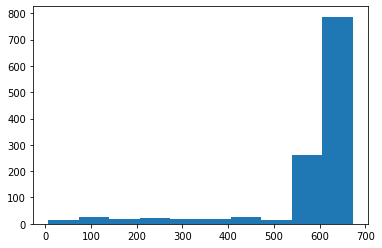

In [1079]:
plt.hist(OLINK_meta.loc[:,find_vars(OLINK_meta,'30901')[0]]-8.9e+11)

In [1080]:
prots_avail=(data[(find_vars(data,'^P_.*pre$'))].notna().sum(axis=0)>500)


In [1081]:
# apply neuroimaging cleaning to OLINK proteomics 
CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','22001-0.0']
for a in OLINK_assays_all:
    out = remove_conf(data,a,[],flatten=True,suf_pre=True,remove_out=True,suf=False,int=True)
    data.loc[:,a+'_pre_cl'] = out[a+'_pre_cl']
    data.loc[:,a+'_post_cl'] = out[a+'_post_cl']
    data.loc[:,a+'_0_cl'] = remove_conf(data,a+'_0',[],flatten=False,suf_pre=True,remove_out=True,suf=False,int=True)

    data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
    data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']
    

In [1082]:

disease_weights= pd.read_csv('/home/eduff/biobank/Proteomics/OLINK/supp_13_disease_weights.csv',header=3)
disease_weights.loc[:,'Protein']=disease_weights['Protein'].str.extract('([^\.]*)\.').values
disease_weights.loc[177,'Protein']='HLA-E'

for a in disease_weights['ProteinScore'].unique():
    astr=a.replace(' ','_')
    astr=astr.replace("'","")
    weights=disease_weights.loc[disease_weights['ProteinScore'].str.contains(a),['Protein','Coefficient']]
    for b in ['0','pre_cl','post_cl']:
        score=(data.loc[eids_OLINK,'P_'+weights['Protein'].values+'_'+b]*weights.loc[:,'Coefficient'].values).sum(axis=1)
        data.loc[score.index,astr+'_'+b]=score.values
        #tmp=score.values
    data.loc[score.index,astr+'_'+'diff_cl']=data.loc[score.index,astr+'_post_cl']-data.loc[score.index,astr+'_pre_cl']
diseases=[a.replace(' ','_') for a in disease_weights['ProteinScore'].unique()]        
diseases_orig=diseases
diseases[9]="Alzheimers_dementia"
diseases[12]="Parkinsons_disease"

data.loc[eids_OLINK,'OLINK']=True

#for a in [
#data=data.rename(columns={"Alzheimer's_dementia":"Alzheimers_dementia","Parkinson's_disease":'Parkinsons_disease'})

In [1083]:
a='Alz'
b='pre_cl'
weights=disease_weights.loc[disease_weights['ProteinScore'].str.contains(a),['Protein','Coefficient']]
(data.loc[eids_OLINK,'P_'+weights['Protein'].values+'_'+b]*weights.loc[:,'Coefficient'].values).var()
'P_GDF15', 'P_TNFSF10', 'P_BCAN', 'P_GFAP', 'P_NEFL'


('P_GDF15', 'P_TNFSF10', 'P_BCAN', 'P_GFAP', 'P_NEFL')

In [1084]:
[a+'_pre_cl' for a in OLINK_assays_all]+['Ab40_pre']

['P_EIF4EBP1_pre_cl',
 'P_EIF4G1_pre_cl',
 'P_EIF5A_pre_cl',
 'P_ENAH_pre_cl',
 'P_ENG_pre_cl',
 'P_ENPP2_pre_cl',
 'P_ENPP5_pre_cl',
 'P_ENPP7_pre_cl',
 'P_ENTPD5_pre_cl',
 'P_EGLN1_pre_cl',
 'P_EGFR_pre_cl',
 'P_EGF_pre_cl',
 'P_EFEMP1_pre_cl',
 'P_EDIL3_pre_cl',
 'P_EDAR_pre_cl',
 'P_DUOX2_pre_cl',
 'P_DPT_pre_cl',
 'P_DPP7_pre_cl',
 'P_DPP4_pre_cl',
 'P_DPP10_pre_cl',
 'P_DOK2_pre_cl',
 'P_ENTPD6_pre_cl',
 'P_EPCAM_pre_cl',
 'P_FABP1_pre_cl',
 'P_FBP1_pre_cl',
 'P_FASLG_pre_cl',
 'P_FAS_pre_cl',
 'P_FAP_pre_cl',
 'P_FAM3C_pre_cl',
 'P_FADD_pre_cl',
 'P_FABP9_pre_cl',
 'P_FABP6_pre_cl',
 'P_FABP4_pre_cl',
 'P_FABP2_pre_cl',
 'P_EPHA1_pre_cl',
 'P_F9_pre_cl',
 'P_F7_pre_cl',
 'P_F2R_pre_cl',
 'P_ESM1_pre_cl',
 'P_ESAM_pre_cl',
 'P_ERBB3_pre_cl',
 'P_EPO_pre_cl',
 'P_EPHX2_pre_cl',
 'P_EPHB4_pre_cl',
 'P_FCAR_pre_cl',
 'P_DNPH1_pre_cl',
 'P_AMY2A_pre_cl',
 'P_AGRN_pre_cl',
 'P_AGRP_pre_cl',
 'P_AGXT_pre_cl',
 'P_AHCY_pre_cl',
 'P_AK1_pre_cl',
 'P_AKR1C4_pre_cl',
 'P_ALCAM_pre_cl',
 'P

In [1085]:
find_vars(data,'P_EIF4G1')

['P_EIF4G1_pre',
 'P_EIF4G1_post',
 'P_EIF4G1_0',
 'P_EIF4G1_pre_cl',
 'P_EIF4G1_post_cl',
 'P_EIF4G1_0_cl',
 'P_EIF4G1_diff_cl',
 'P_EIF4G1_pc_cl']

In [1086]:
compare_prots[-5:]

['P_CHGB_pre_cl',
 'P_KLK1_pre_cl',
 'P_WFDC2_pre_cl',
 'Ab40_regPl_pre_cl',
 'Ab42_regPl_pre_cl']

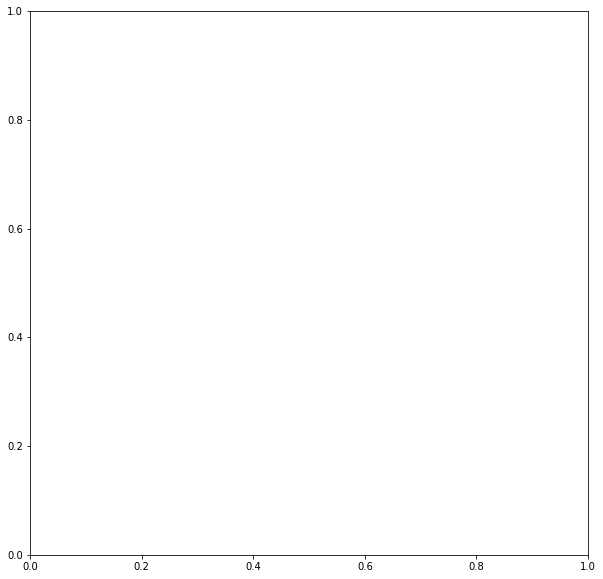

In [1087]:
# check
compare_prots=['P_MMP9_pre','P_MMP8_pre','NfL_post','P_NEFL_post','P_PTX3_post','pTau-181_pre','pTau-181_post','Ab40_pre','Ab40_post','Ab42_pre','Ab42_post']
# 'GFAP_pre','P_GFAP_pre','GFAP_post','P_GFAP_post','NfL_pre',
compare_prots=[a+'_pre_cl' for a in OLINK_assays_all]+['Ab40_regPl_pre_cl','Ab42_regPl_pre_cl']
fig, ax = plt.subplots(figsize=(10,10))
corr_map_OLINK = data.loc[:,compare_prots].corr()
#mask_m = np.tril(corr_map_OLINK,k=-1)
#ax=sns.heatmap(corr_map_OLINK,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True,ax=ax)
#ax.invert_yaxis()

In [1088]:
corr_map_OLINK.loc['Ab40_regPl_pre_cl',:].sort_values()

P_PARK7_pre_cl      -0.373181
P_PDGFB_pre_cl      -0.373034
P_SERPINE1_pre_cl   -0.369017
P_CD63_pre_cl       -0.368478
P_MIF_pre_cl        -0.368465
                       ...   
P_ADM_pre_cl         0.284001
P_OGN_pre_cl         0.287092
P_HLA-E_pre_cl       0.300205
Ab42_regPl_pre_cl    0.668696
Ab40_regPl_pre_cl    1.000000
Name: Ab40_regPl_pre_cl, Length: 1463, dtype: float64

In [1089]:
# corr of OLINK with Ab42/Ab40
Abcorrs=data[['Ab42/Ab40_regPl_diff_cl']+[a+'_diff_cl' for a in OLINK_assays_all]].corr()['Ab42/Ab40_regPl_diff_cl']
Abcorrs.sort_values().iloc[-20:]

P_MCFD2_diff_cl            0.219103
P_ENO1_diff_cl             0.219160
P_BACH1_diff_cl            0.219588
P_IKBKG_diff_cl            0.219644
P_NUB1_diff_cl             0.219675
P_DFFA_diff_cl             0.219919
P_TXLNA_diff_cl            0.220681
P_GOPC_diff_cl             0.221113
P_CRADD_diff_cl            0.221905
P_ANXA4_diff_cl            0.221925
P_FADD_diff_cl             0.222059
P_PFKFB2_diff_cl           0.222580
P_PLPBP_diff_cl            0.224661
P_TNFSF14_diff_cl          0.224885
P_FKBP4_diff_cl            0.224943
P_TMSB10_diff_cl           0.226809
P_ANXA3_diff_cl            0.226947
P_ARHGAP25_diff_cl         0.234134
P_KYAT1_diff_cl            0.251146
Ab42/Ab40_regPl_diff_cl    1.000000
Name: Ab42/Ab40_regPl_diff_cl, dtype: float64

In [1090]:
for a in ['NTRK3', 'NTRK2', 'BLMH', 'CBLN4', 'PTPRN2', 'PTPRS']:
    print(len(data.loc[:,'P_'+a+'_pre_cl'].dropna()))

1164
1165
1173
1150
1145
1173


In [1091]:
aa=data.loc[:,'P_MCFD2_post'].dropna().index.intersection(data.loc[:,'Ab42_post'].dropna().index)
bb=data.loc[:,'P_MCFD2_pre'].dropna().index.intersection(data.loc[:,'Ab42_pre'].dropna().index)
aa.intersection(bb)

Index([1001193, 1005523, 1024229, 1037025, 1037373, 1040749, 1060006, 1066102,
       1074220, 1078615,
       ...
       5973525, 5986418, 5987833, 5995025, 5996549, 5997608, 5999901, 6015180,
       6022672, 6023438],
      dtype='int64', name='eid', length=765)

In [1092]:
prot_els_regPl_pre_cl
Abcorrs=data[prot_els_regPl_pre_cl +[a+'_pre_cl' for a in diseases]].corr()[prot_els_regPl_pre_cl ]
Abcorrs['Ab42_regPl_pre_cl'].sort_values()

Liver_disease_pre_cl                   -0.063748
Inflammatory_bowel_disease_pre_cl      -0.038020
Breast_cancer_pre_cl                   -0.037158
Type_2_diabetes_pre_cl                 -0.036633
pTau-181_regPl_pre_cl                  -0.032825
Ischaemic_stroke_pre_cl                -0.003945
Endometriosis_pre_cl                    0.006175
Parkinsons_disease_pre_cl               0.014750
Gynaecological_cancer_pre_cl            0.036120
Ischaemic_heart_disease_pre_cl          0.049496
COPD_pre_cl                             0.062009
Death_pre_cl                            0.070412
Rheumatoid_arthritis_pre_cl             0.070666
Alzheimers_dementia_pre_cl              0.072574
Amyotrophic_lateral_sclerosis_pre_cl    0.088186
Prostate_cancer_pre_cl                  0.090956
GFAP_regPl_pre_cl                       0.099439
Vascular_dementia_pre_cl                0.111171
Cystitis_pre_cl                         0.133284
Lung_cancer_pre_cl                      0.136930
Colorectal_cancer_pr

In [1093]:
os.chdir('/home/eduff/biobank/')

In [1094]:
#data.to_csv('/home/eduff/biobank/all_data.csv')

# Proteomic Correlation plots  


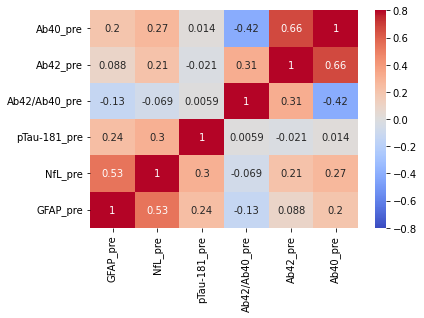

In [1095]:


corr_map_post= data.loc[all_matched,prot_els_post[::-1]].corr()
corr_map_pre= data.loc[all_matched,prot_els_pre[::-1]].corr()
np.fill_diagonal(corr_map_post.values,1)
np.fill_diagonal(corr_map_pre.values,1)
mask_m = np.tril(corr_map_post,k=-1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8,annot=True)
ax.invert_yaxis()


In [1096]:
prot_els_diff[:6]

['Ab40_diff',
 'Ab42_diff',
 'Ab42/Ab40_diff',
 'pTau-181_diff',
 'NfL_diff',
 'GFAP_diff']

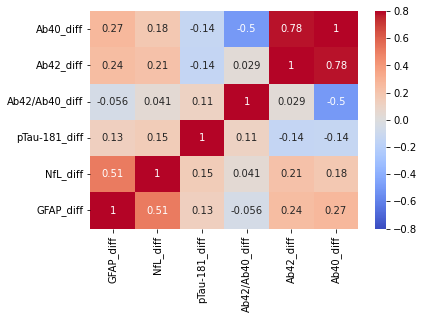

In [1097]:

#corr_map_post= data.loc[all_matched,prot_els_diff[::-1]].corr()
#corr_map_pre= data.loc[all_matched,prot_els_pre[::-1]].corr()
corr_map_diff= data.loc[all_matched,prot_els_diff[:6][::-1]].corr()

np.fill_diagonal(corr_map_diff.values,1)
#mask_m = np.tril(corr_map_diff,k=-1)
ax=sns.heatmap(corr_map_diff,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True)
ax.invert_yaxis()


In [1098]:
data.loc[:,'hydration-2.0']=data.loc[:,'23102-2.0']/data.loc[:,'21002-2.0']
data.loc[:,prot_els_pre[::-1]+['21001-2.0']].corr()

,GFAP_pre,NfL_pre,pTau-181_pre,Ab42/Ab40_pre,Ab42_pre,Ab40_pre,21001-2.0
GFAP_pre,1.000000,0.535448,0.236306,-0.131408,0.089359,0.201030,-0.143716
NfL_pre,0.535448,1.000000,0.306282,-0.070248,0.209237,0.270011,-0.186095
pTau-181_pre,0.236306,0.306282,1.000000,0.004928,-0.022089,0.013399,-0.018132
Ab42/Ab40_pre,-0.131408,-0.070248,0.004928,1.000000,0.311849,-0.418391,-0.073551
Ab42_pre,0.089359,0.209237,-0.022089,0.311849,1.000000,0.664666,-0.030415
Ab40_pre,0.201030,0.270011,0.013399,-0.418391,0.664666,1.000000,0.032654
21001-2.0,-0.143716,-0.186095,-0.018132,-0.073551,-0.030415,0.032654,1.000000


<Axes: xlabel='21002-2.0', ylabel='23102-2.0'>

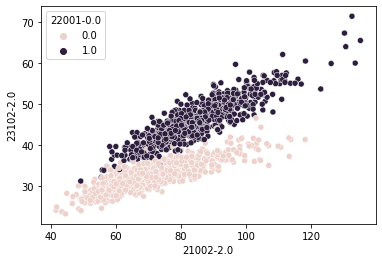

In [1099]:

sns.scatterplot(data=data,x='21002-2.0',y='23102-2.0',hue='22001-0.0')

In [1100]:
vars=['Ab42_regPl_pre','Ab40_regPl_pre','Ab42/Ab40_regPl_pre','pTau-181_regPl_pre','NfL_regPl_pre','GFAP_regPl_pre']

In [1101]:

# mask_m = np.tril(corr_map_post,k=-1)
# ax=sns.heatmap(corr_map_pre.loc[:,vars],cmap="coolwarm",vmin=-.8,vmax=.8,mask=mask_m, annot=True)
# ax.invert_yaxis()

In [1102]:
np.array(prot_els_regPl_pre)[[5,4,0,1,2,3]]

array(['GFAP_regPl_pre', 'NfL_regPl_pre', 'Ab40_regPl_pre',
       'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre', 'pTau-181_regPl_pre'],
      dtype='<U19')

In [1103]:
#els=proteomics.loc[:,'Gender_pre']=='M


proteomics.loc[:,prot_els_pre+prot_els_post+['PlateID_pre']+['PlateID_post']].to_csv('simoa_proteomics.csv')

In [1104]:
vars

['Ab42_regPl_pre',
 'Ab40_regPl_pre',
 'Ab42/Ab40_regPl_pre',
 'pTau-181_regPl_pre',
 'NfL_regPl_pre',
 'GFAP_regPl_pre']

In [1105]:
vars=np.array(['Ab40_regPl_pre', 'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre', 'pTau-181_regPl_pre', 'NfL_regPl_pre', 'P_NEFL_pre' ,'GFAP_regPl_pre','P_GFAP_pre'])
vars_names=np.array(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'NfL (OLINK)'),
 Text(6.5, 0, 'GFAP'),
 Text(7.5, 0, 'GFAP (OLINK)')]

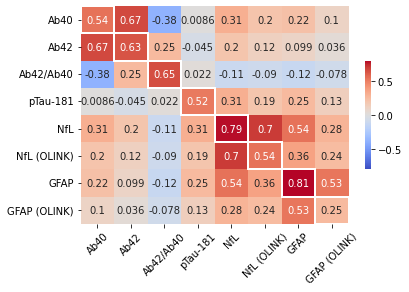

In [1106]:
import matplotlib.pyplot as plt

vars=(['Ab40_regPl_pre', 'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre', 'pTau-181_regPl_pre', 'NfL_regPl_pre', 'P_NEFL_pre' ,'GFAP_regPl_pre','P_GFAP_pre'])
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])
vars_prepost=vars + [a[:-4] + '_post' for a in vars]

corr_map_post= data.loc[:,[a[:-4] + '_post' for a in vars]].corr()
corr_map_pre= data.loc[:,vars].corr()


for a in corr_map_pre.columns:
    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_pre.columns=vars_names
corr_map_pre.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True,cbar_kws={"shrink": 0.5})

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'GFAP')]

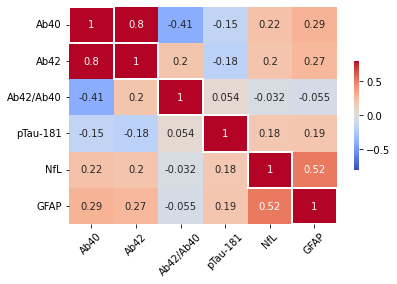

In [1107]:
import matplotlib.pyplot as plt

vars=(['Ab40_regPl_pre', 'Ab42_regPl_pre', 'Ab42/Ab40_regPl_pre', 'pTau-181_regPl_pre', 'NfL_regPl_pre','GFAP_regPl_pre'])
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL', 'GFAP'])
vars_prepost=vars + [a[:-4] + '_post' for a in vars]

corr_map_diff= data.loc[:,[a[:-4] + '_diff_cl' for a in vars]].corr()



#for a in corr_map_pre.columns:
#    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
#    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_diff.columns=vars_names
corr_map_diff.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_diff,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True,cbar_kws={"shrink": 0.5})

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'GFAP')]

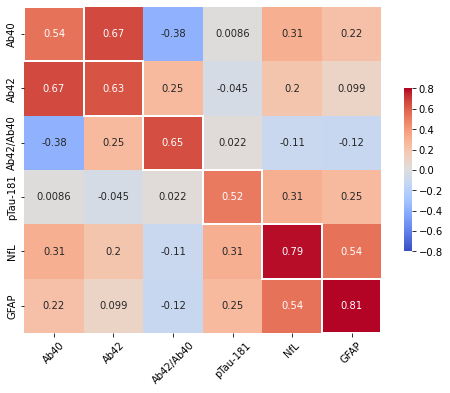

In [1108]:
import matplotlib.pyplot as plt

vars=(['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl'] )
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL', 'GFAP'])
vars_pre=[a + '_pre' for a in vars] 
vars_post= [a + '_post' for a in vars]

corr_map_post= data.loc[:,vars_post].corr()
corr_map_pre= data.loc[:,vars_pre].corr()


for a in corr_map_pre.columns:
    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_pre.columns=vars_names
corr_map_pre.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True, ax=ax,cbar_kws={"shrink": 0.5})

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

In [1109]:
corr_map_pre.to_excel('/home/eduff/biobank/tables/corr_map_pre.xlsx')

[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'NfL (OLINK)'),
 Text(6.5, 0, 'GFAP'),
 Text(7.5, 0, 'GFAP (OLINK)')]

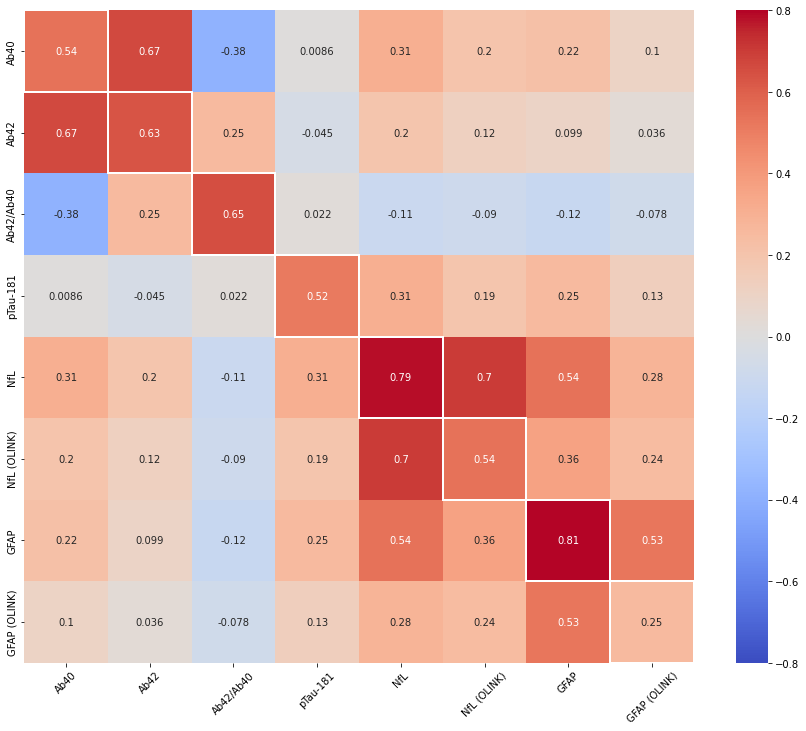

In [1110]:
import matplotlib.pyplot as plt

vars=(['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'P_NEFL' ,'GFAP_regPl','P_GFAP'] )
vars_names=(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])
vars_pre=[a + '_pre' for a in vars] 
vars_post= [a + '_post' for a in vars]

corr_map_post= data.loc[:,vars_post].corr()
corr_map_pre= data.loc[:,vars_pre].corr()


for a in corr_map_pre.columns:
    corr_map_pre.loc[a,a]=data.loc[all_matched,[a,a.replace('pre','post')]].corr().values[0,1]
    corr_map_post.loc[a,a]=corr_map_pre.loc[a,a]


corr_map_pre.columns=vars_names
corr_map_pre.index=vars_names

#mask_m = np.tril(corr_map_regPl_post,k=-1)
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True, ax=ax)

# Highlight diagonal with black outline
for i in range(len(corr_map_pre)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=2))

ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)


[Text(0.5, 0, 'Ab40'),
 Text(1.5, 0, 'Ab42'),
 Text(2.5, 0, 'Ab42/Ab40'),
 Text(3.5, 0, 'pTau-181'),
 Text(4.5, 0, 'NfL'),
 Text(5.5, 0, 'NfL (OLINK)'),
 Text(6.5, 0, 'GFAP'),
 Text(7.5, 0, 'GFAP (OLINK)')]

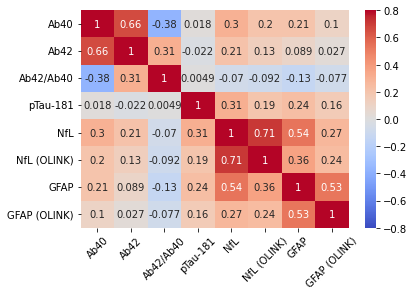

In [1111]:
vars=np.array(['Ab40_regPl_pre_cl', 'Ab42_pre', 'Ab42/Ab40_pre', 'pTau-181_pre', 'NfL_pre', 'P_NEFL_pre' ,'GFAP_pre','P_GFAP_pre'])
vars_names=np.array(['Ab40', 'Ab42', 'Ab42/Ab40','pTau-181', 'NfL','NfL (OLINK)', 'GFAP', 'GFAP (OLINK)'])

corr_map_post= data.loc[:,vars].corr()
corr_map_pre= data.loc[:,vars].corr()
corr_map_pre.columns=vars_names

corr_map_pre.index=vars_names
np.fill_diagonal(corr_map_post.values,1)
np.fill_diagonal(corr_map_pre.values,1)
#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True)
#ax.invert_yaxis()
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

[Text(0.5, 0, 'GFAP'),
 Text(1.5, 0, 'NfL'),
 Text(2.5, 0, 'Ab40'),
 Text(3.5, 0, 'Ab42'),
 Text(4.5, 0, 'Ab42/Ab40'),
 Text(5.5, 0, 'pTau-181')]

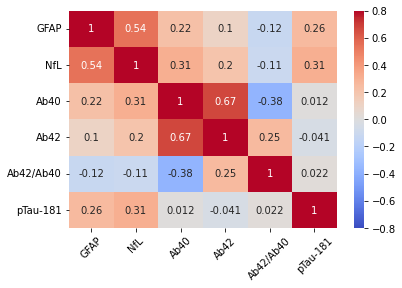

In [1112]:
vars=np.array(prot_els_regPl_pre)[[5,4,0,1,2,3]]
vars_names=np.array([ 'NfL', 'GFAP'])

corr_map_post= proteomics.loc[:,vars].corr()
corr_map_pre= proteomics.loc[:,vars].corr()
corr_map_pre.columns=[a[:-10] for a in corr_map_post.columns]
corr_map_pre.index=[a[:-10] for a in corr_map_post.index]
np.fill_diagonal(corr_map_post.values,1)
np.fill_diagonal(corr_map_pre.values,1)
#mask_m = np.tril(corr_map_regPl_post,k=-1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True)
#ax.invert_yaxis()
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45)

# Demographic histograms

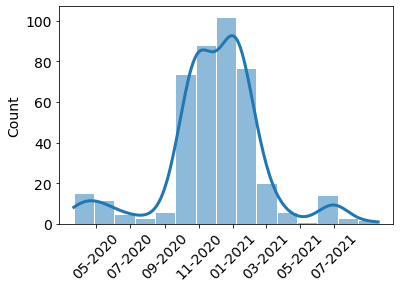

In [1113]:
from matplotlib.dates import DateFormatter
ax=sns.histplot(data=data.loc[all_matched,:],x='firstpos',bins=15,edgecolor="white",kde=True,line_kws={'lw': 3})
out=plt.xticks(rotation=45,fontsize=14)
date_form = DateFormatter("%m-%Y")
ax.xaxis.set_major_formatter(date_form)
plt.ylabel('Count',fontsize=14)
plt.xlabel('')
out=plt.xticks(out[0][1:-1],rotation=45,fontsize=14)
outy=plt.yticks(fontsize=14)
fig=plt.gcf()
fig.savefig('figures/DataCOVID_fig1.svg', bbox_inches = "tight")
#ax.set_title('Estimated dates of symptomatic COVID')
#ax.set_xlabel('Date of first recorded positive')

In [1114]:
out[0][0::2]

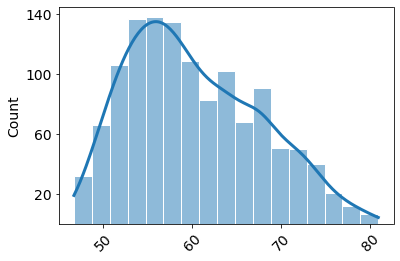

In [1115]:
ax=sns.histplot(data=data.loc[all_matched,:],  x="Age-2.0",edgecolor='white',kde=True,line_kws={'lw': 3})
ax.set_title('Participant ages (pre-pandemic assessment visit)',fontsize=14)
ax.set_title('',fontsize=14)
ax.set_xlabel('Age',fontsize=14)

#date_form = DateFormatter("%m-%Y")
#ax.xaxis.set_major_formatter(date_form)
plt.ylabel('Count',fontsize=14)
plt.xlabel('')
out=plt.xticks([50,60,70,80],rotation=45,fontsize=14)
outy=plt.yticks([20,60,100,140],fontsize=14)
fig=plt.gcf()
fig.savefig('figures/Ages_fig1.svg', bbox_inches = "tight")

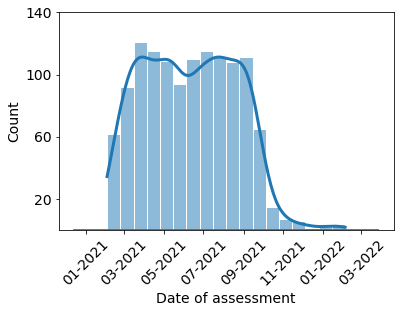

In [1116]:
ax=sns.kdeplot(data=data.loc[all_matched,:],  x='date_post')
ax=sns.histplot(data=data.loc[all_matched,:],  x='date_post',edgecolor='white',bins=18,kde=True,line_kws={'lw': 3})

ax.set_title('Pandemic assessment visit dates ',fontsize=14)
ax.set_title('',fontsize=14)
ax.set_xlabel('Date of assessment',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
date_form = DateFormatter("%m-%Y")
ax.xaxis.set_major_formatter(date_form)
outy=plt.yticks(fontsize=14)
outy=plt.yticks([20,60,100,140],fontsize=14)
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45,fontsize=14)
fig=plt.gcf()
fig.savefig('figures/PandDates_fig1.svg', bbox_inches = "tight")

In [1117]:
data.loc[all_matched&all_case,"assessment_sep_m"].min()

12

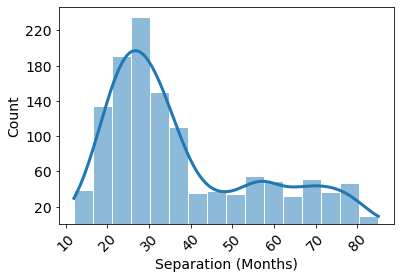

In [1118]:
ax=sns.histplot(data=data.loc[all_matched,:],  x="assessment_sep_m",edgecolor='white',kde=True,line_kws={'lw': 3})
ax.set_title('Separation between assessments',fontsize=14)
ax.set_title('',fontsize=14)
ax.set_xlabel('Separation (Months)',fontsize=14)
ax.set_ylabel('Count',fontsize=14)
outy=plt.yticks([20,60,100,140,180,220],fontsize=14)
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45,fontsize=14)
fig=plt.gcf()
fig.savefig('figures/Seps_fig1.svg', bbox_inches = "tight")

In [1119]:
data.loc[all_matched,"assessment_sep_m"].max()

85

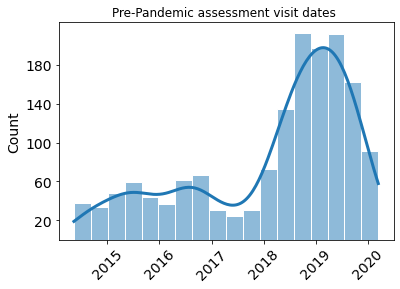

In [1120]:
ax=sns.histplot(data=data,  x='date_pre',edgecolor='white',bins=18,kde=True,line_kws={'lw': 3})
ax.set_title('Pre-Pandemic assessment visit dates ')
ax.set_xlabel('Date of assessment',fontsize=14)
ax.set_ylabel('Count')
outy=plt.yticks([20,60,100,140,180],fontsize=14)
ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=45,fontsize=14)
ax.set_yticklabels(labels=ax.get_yticklabels(),fontsize=14)

plt.ylabel('Count',fontsize=14)
plt.xlabel('')
fig=plt.gcf()
fig.savefig('figures/PrePand_fig1.svg', bbox_inches = "tight")

,HES,PCR,GP,Lateral
eid,,,,
1024229,False,True,True,True
1037373,False,True,True,False
1043160,False,False,False,True
1055982,True,True,True,True
1058801,False,False,False,True
...,...,...,...,...
6004696,False,True,True,True
6013979,False,True,True,False
6016344,False,True,False,True


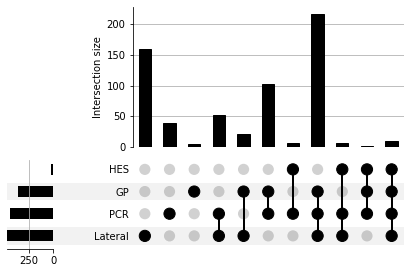

In [1121]:
import upsetplot
upsetdata=upsetplot.from_indicators(data.loc[all_case&all_matched,['HES','PCR','GP','Lateral']])
upsetplot.plot(upsetdata,subset_size="count") 
#data.loc[all_case,['HES','PCR','GP','Lateral']].
data.loc[all_case,['HES','PCR','GP','Lateral']]

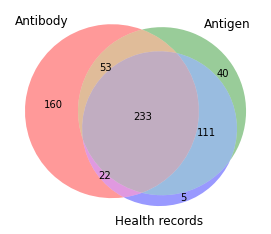

In [1122]:
from matplotlib_venn import venn3
set1=set(data[data.loc[:,'Lateral']&all_case&all_matched].index)
set2=set(data[data.loc[:,'PCR']&all_case&all_matched].index)
set3=set(data[data.loc[:,'PublicHealthRecord']&all_case&all_matched].index)

venn3([set1, set2,set3],['Antibody','Antigen','Health records'])

fig=plt.gcf()
fig.savefig('figures/Venn.svg', bbox_inches = "tight")

In [1123]:
len(np.intersect1d(all_matched[all_matched].index.values,eids_OLINK))

868

## eGFR

In [1124]:
# eGFR only abvailable on 0/1st visist

# CDK-EPI equation for GFR:


# GFR = 141 * min(Scr / k, 1)^a * max(Scr / k, 1)^-1.209 * 0.993^data['Age- * 1.018 

find_vars(data,'30720')
23478
SCr=data.loc[:,'30700-0.0']

kk=0.7+0.2*data['22001-0.0']

alpha=-0.329 - data['22001-0.0']*(0.411-0.329)

sex_mult = 1-.018 * (data['22001-0.0']-1)

eth_mult = 1+ 0.159 * (((data.loc[:,find_vars(data,'^21000-2')]>4000).sum(axis=1))/2)

GFR = 141 * np.minimum(SCr / kk, 1)**alpha * np.maximum(SCr / kk, 1)**-1.209 * 0.993**(data['Age-0.0']) * sex_mult * eth_mult
data.loc[:,'GFR_Cr-0.0']=GFR


In [1125]:
# CDK-EPI Creatinine-Cystatin equation for GFR:  ## Creatinine not available

# eGFRcr-cys = 135 x min(Scr/κ, 1)**α x max(Scr/κ, 1)-0.544 x min(Scys/0.8, 1)-0.323 x max(Scys/0.8, 1)-0.778 x 0.9961Age x 0.963 [if female]

#
# estdata=data.loc[:,['P_CST3_0','30720-0.0','P_CST3_0','30700-0.0']].dropna()

# kde_cys = KernelReg(endog=estdata.loc[:,'30720-0.0'], exog=estdata.loc[:,'P_CST3_0'], var_type='c', bw=[12])
# estimator = kde.fit(estdata.loc[:,'P_CST3_0'])

# SCr=data.loc[:,'30700-0.0']

# kde_cre = KernelReg(endog=estdata.loc[:,'30720-0.0'], exog=estdata.loc[:,'P_CST3_0'], var_type='c', bw=[12])
# estimator = kde.fit(estdata.loc[:,'P_CST3_0'])


# kk=0.7+0.2*data['22001-0.0']

# alpha=-0.219 + data['22001-0.0']*(0.219-0.144)

# sex_mult = 0.963 * (1-data['22001-0.0'])

# #eth_mult = 1+ 0.159 * (((data.loc[:,find_vars(data,'^21000-2')]>4000).sum(axis=1))/2)

# GFR = (135 * np.minimum(SCr / kk, 1)**alpha )* (np.maximum(SCr / kk, 1)**-0.544) * (np.minimum(SCys/0.8,1)**-0.323) * (np.maximum(SCys/0.8,1)**-0.778) * 0.9961**(data['Age-0.0']) * sex_mult 

# data.loc[:,'GFR-0.0']=GFR

In [1126]:
'P_CST3'+a

'P_CST3P_GFAP_pre'

In [1127]:
# # eGFR only abvailable on 0/1st visist
# from statsmodels.nonparametric.kernel_regression import KernelReg
# # CDK-EPI equation for Cys GFR:


# GFR = 133 * min(Scys/0.8, 1)-0.499 x max(Scys/0.8, 1)-1.328 * 0.996**Age x 0.932 [if female]

# generate estimator of standardised CST3 from OLINK levels:
from statsmodels.nonparametric.kernel_regression import KernelReg
estdata=data.loc[:,['P_CST3_0','P_CST3_pre','P_CST3_post','30720-0.0']].dropna()
kde_cys = KernelReg(endog=estdata.loc[:,'30720-0.0'], exog=estdata.loc[:,'P_CST3_0'], var_type='c', bw=[12])
sex_mult = 1 - (1-0.932) * (1-data['22001-0.0'])

for a in ['_0','_pre','_post']:
    if a=='_0':
        age=data.loc[estdata.index,'Age-0.0']
    elif a=='_pre':
        age=data.loc[estdata.index,'Age-2.0']
    elif a=='_post':
        age=data.loc[estdata.index,'Age-3.0']

    SCys= kde_cys.fit(estdata.loc[:,'P_CST3'+a])[0]
    data.loc[estdata.index,'P_CST3'+a+'_cl']=SCys
    data.loc[estdata.index,'GFR_Cys'+a+'_cl'] = 133 * np.minimum(SCys/0.8, 1)**0.499 * np.maximum(SCys / 0.8, 1)**-1.328 * 0.996**age * sex_mult 
data.loc[estdata.index,'GFR_Cys'+'_diff'+'_cl'] =data.loc[estdata.index,'GFR_Cys'+'_post'+'_cl'] -data.loc[estdata.index,'GFR_Cys'+'_pre'+'_cl'] 

data=data.copy()

# Sample Counts


In [1128]:
all_matched.values.sum()

1248

In [1129]:
data.loc[:,[ a + '_matched' for a in ['Ab42/Ab40','Ab42','Ab40','pTau-181','NfL','GFAP']]].sum()/2

Ab42/Ab40_matched    614.0
Ab42_matched         617.0
Ab40_matched         615.0
pTau-181_matched     610.0
NfL_matched          619.0
GFAP_matched         620.0
dtype: float64

In [1130]:
# hospitalised
(data.loc[:,'Case_hosp_matched']=='sars_hosp').sum()

26

In [1131]:
# vaccinated
print('prior to positive: ' + str((data.loc[all_matched,'vac_prior_first_pos']==True).sum()))
print('following positive: ' + str((data.loc[all_matched,'vac_prior_first_pos']==False).sum()))
# vaccinated assessment
print('prior to assessment (Case): ' + str((data.loc[all_case,'vac_prior_assess']==True).sum()))
print('following assessment (Case): ' + str((data.loc[all_case,'vac_prior_assess']==False).sum()))
print('prior to assessment (Control): ' + str((data.loc[all_control,'vac_prior_assess']==True).sum()))
print('following assessment (Control): ' + str((data.loc[all_control,'vac_prior_assess']==False).sum()))

prior to positive: 40
following positive: 249
prior to assessment (Case): 479
following assessment (Case): 18
prior to assessment (Control): 490
following assessment (Control): 16


In [1132]:
(data.loc[all_matched,'vac_prior_assess']==False).sum()

28

In [1133]:
column='adni_mean_cl-2.0'
df_c=data.loc[all_matched,[column,'matched_eid','Case']]
groupby='Case'
group='sars'
ids_case = df_c.loc[df_c[groupby]==group,column].dropna().index
ids_ctr=df_c.loc[ids_case,'matched_eid'].dropna().values
ids_ctr=df_c.loc[ids_ctr,column].dropna().index
ids_case=df_c.loc[ids_ctr,'matched_eid']
len(ids_ctr)

590

In [1134]:
for a in ['GFR_Cys_diff_cl','adni_mean_cl-2.0']:
    print(a +': '+str(data.loc[data.loc[~data.loc[:,a].isna(),'matched_eid'].dropna(),a].dropna().shape[0]/2))

GFR_Cys_diff_cl: 225.0
adni_mean_cl-2.0: 592.0


In [1135]:
for a in ['GFR_Cys_diff_cl','adni_mean_diff']:
    print(a +': '+str(data.loc[data.loc[~data.loc[:,a].isna(),'matched_eid'].dropna(),a].dropna().shape[0]/2))

GFR_Cys_diff_cl: 225.0
adni_mean_diff: 509.0


In [1136]:
len(data.loc[all_matched,'GFR_Cys_diff_cl'].dropna())/2

347.5

In [1137]:
any_Olink=data.loc[all_matched,find_vars(data,'^P_.*diff_cl')].any(axis=1)
len(np.intersect1d(data[all_matched][any_Olink]['matched_eid'].dropna().values,any_Olink[any_Olink].index))/2

277.0

In [1138]:
os.chdir('/home/eduff/biobank/')

# Demographic Tables

In [1139]:
# human readable names for tables

cols_translate={'31-0.0':'Sex','GeneralHealth-2.0':'Health self-rating','cog_vars_gi-2.0':'Cognitive Ability Score','cog_vars_alz-2.0':'Cognition (AD)',
 '709-2.0':'Number in Household','738-2.0':'Income','6350-2.0':'Trail Making 2','Obesity-2.0':'Obesity','Obesity-3.0':'Obesity',
 'Smoking-2.0':'Smoker','20018-2.0':'Prospective Memory','GFR_Cys_pre_cl':'GFR (pre)','GFR_Cys_post_cl':'GFR (post)','21001-2.0': 'BMI ','21002-2.0': 'Weight','Age-2.0': 'Age (baseline)','Age-3.0': 'Age (pandemic)','adni_mean_cl-2.0': 'AD Neuroimaging Phenotype',
 '4080-2.0': 'BP (sys)','4079-2.0': 'BP (dia)','Hip/Waist-2.0': 'Hip/Waist Ratio','Alcohol-2.0': 'Alcohol Intake Freq',"Case_bin:Q('Age-2.0_f')":"Case (age weighted)","diabetes":'Type II Diabetes',"Diabetes2":'Type II Diabetes',
                "Case_bin:Q('adni_mean_cl-2.0')":'Case weighted NI sig',"Q('adni_mean_cl-2.0')":"Neuroimaging sig" , "vac_prior_assess":"COVID vaccinated","Case_vax_prior_bin":"Vaccinated prior",'Age-3.0_f':'Severity score (Age)','Age-2.0_f':'Severity score (Age)',
 'Case_hosp_bin': 'Hospitalised','Case_bin': 'Case/Control status','Case_bin:':'ARV : Case/Control status','C(Case_hosp)[T.sars]': 'Case/Control','depression':'Depression','Heart_Cond':'Heart Condition','hypertension':'Hypertension',
                'APOE_score':'APOE-e4 count','C(Case_hosp)[T.sars_hosp]': 'Hospitalised','assessment_sep': 'Assessment Interval (d)','A4': 'APOE4','50-0.0':'Height','Activity-2.0':'Moderate activity (min/d)','Activity-3.0':'Vigorous activity (min/d)','Activity_vig-2.0':'Vigorous activity (min/d)','Activity_vig-3.0':'Vigorous activity (min/d)','Wheeze-2.0':'Chest wheeze',
                '26207-0.0': 'AD PRS','Gender_pre': 'Sex','isolation-2.0':'Social Isolation','isolation-3.0':'Social Isolation','Education_age':'Age Education Complete','845-2.0':'Age Eduction Complete','845-3.0':'Age Eduction Complete', 'paid_employ-2.0':'Employed','paid_employ_bin-2.0':'Employed', 'retired-2.0':'Retired','22001-0.0': 'Genetic Sex','HandGrip-2.0':'Hand Grip','Wheeze_bin-2.0':'Chest wheeze',
                'GeneralHealth-3.0': 'Health self-rating', 'cog_vars_gi-2.0': 'Cognitive Ability Score', 'cog_vars_alz-2.0': 'Cognition (AD)','cog_vars_gi-3.0': 'Cognitive Ability Score', 'cog_vars_alz-3.0': 'Cognition (AD)', '709-3.0': 'Number in Household', '738-3.0': 'Income', '6350-3.0': 'Trail Making 2','WorkingThroughCOVID':'Working during COVID',
                'Smoking_bin-2.0':'Smoker','Smoking_bin-3.0': 'Smoker', '20018-3.0': 'Prospective Memory', '21001-3.0': 'BMI ', '21002-3.0': 'Weight', 'adni_mean_cl-3.0': 'AD Neuroimaging Phenotype',
                '4080-3.0': 'BP (sys)', '4079-3.0': 'BP (dia)', 'BP_meds':'Blood pressure medication', 'Chol_meds':'Cholesterol medication','Hip/Waist-3.0': 'Hip/Waist Ratio', 'Alcohol-3.0': 'Alcohol Intake Freq', "Case_bin:Q('Age-3.0_f')": 'Case (age weighted)', "Case_bin:Q('adni_mean_cl-3.0')": 'Case weighted NI sig', "Q('adni_mean_cl-3.0')": 'Neuroimaging sig'
               , 'A34':'APOE-e3e4', 'A33':'APOE-e3e3','Ethnicity(White)':'Ethnicity (white)' ,'30890-1.0':'Vitamin D','hearing-2.0':'Hearing Loss','hearing-3.0':'Hearing Loss','A32':'APOE-e3e2', 'A44':'APOE-e4e4','Insulin_meds':'Diabetes medications','COPD_ICD':'COPD','Bronc':'Emphysema','renal':'Renal condition','pre':'Baseline protein','assessment_sep^2':'Assessment Interval^2'}


cols_translate_type={'31-0.0':'Demographics','GeneralHealth-2.0':'Health measure','cog_vars_gi-2.0':'Cognition','cog_vars_alz-2.0':'Cognition',
 '709-2.0':'Life Status','738-2.0':'Life Status','isolation-2.0':'Life Status','isolation-3.0':'Life Status','6350-2.0':'Cognition','hearing-2.0':'Comorbidity','hearing-3.0':'Comorbidity','Obesity-2.0':'Comorbidity','Obesity-3.0':'Comorbidity','diabetes':'Comorbidity',
 'Smoking-2.0':'Life Status','20018-2.0':'Cognition','GFR_Cys_pre_cl':'Health measure','GFR_Cys_post_cl':'Health measure','21001-2.0': 'Health measure','21002-2.0': 'Demographics','Age-2.0': 'Demographics','adni_mean_cl-2.0': 'Neuroimaging',
 '4080-2.0': 'Health measure','4079-2.0':'Health measure','Hip/Waist-2.0': 'Health measure','30890-1.0':'Health measure','Alcohol-2.0': 'Life Status','Deprivation':'Life Status','50-0.0':'Demographics','Heart_Cond':'Comorbidity',
                "Case_bin:Q('adni_mean_cl-2.0')":'Neuroimaging',"Q('adni_mean_cl-2.0')":"Neuroimaging",'vac_prior_assess':'Medications', "vac_prior_assess":"Medications","Case_vax_prior_bin":"Medications",'Age-3.0_f':'Risk score','Age-2.0_f':'Risk score',
 'Case_hosp_bin': 'Hospitalised','Case_bin': 'Case/Control status','C(Case_hosp)[T.sars]': 'Case/Control','GeneralHealth-2.0':'Health measure','depression':'Comorbidity','heart_cond':'Comorbidity','hypertension':'Comorbidity','Diabetes2':'Comorbidity','Diabetes':'Comorbidity','IBS':'Comorbidity',
                'APOE_score':'Genetics','assessment_sep': 'Experiment','A4': 'Genetic','A33vA34':'Genetic','A33vA44': 'Genetic','Activity_vig-2.0':'Life Status','Activity_vig-3.0':'Life Status','Activity-2.0':'Life Status','Activity-3.0':'Life Status','KeyWorker':'Life Status','WorkingThroughCOVID':'Life Status','738-3.0': 'Life Status',
                '26207-0.0': 'AD PRS','Gender_pre': 'Demographics','Education_age':'Life Status','paid_employ_bin-2.0':'Life Status','paid_employ-2.0':'Life Status', 'retired-2.0':'Life Status','22001-0.0': 'Genetic Sex','BP_meds':'Medications','Chol_meds':'Medications','31-0.0':'Demographics','31-0.0':'Demographics',
                'GeneralHealth-3.0': 'Health measure','Ethnicity(White)':'Demographics',  'cog_vars_gi-2.0': 'Cognition', 'cog_vars_alz-2.0': 'Cognition','cog_vars_gi-3.0': 'Cognition', 'cog_vars_alz-3.0': 'Cognition', '709-3.0': 'Life Status','HandGrip-2.0':'Health measure','Wheeze_bin-2.0':'Health measure','Wheeze-2.0':'Health measure',
                     '738-3.0':'Life Status', '6350-3.0': 'Cognition', 'Smoking_bin-2.0':'Life Status','Smoking_bin-3.0': 'Life Status', '20018-3.0': 'Cognition', '21001-3.0': 'Health Measure', '21002-3.0': 'Demographics', 'Age-3.0': 'Demographics', 'adni_mean_cl-3.0': 'Neuroimaging', '4080-3.0': 'Health Measure', '4079-3.0': 'Health Measure', 'Hip/Waist-3.0': 'Demographics', 'Alcohol-3.0': 'Life Status', "Case_bin:Q('adni_mean_cl-3.0')": 'Neuroimaging', "Q('adni_mean_cl-3.0')": 'Neuroimaging'
                     , 'A34':'Genetics', 'A33':'Genetics', 'A32':'Genetics', 'A44':'Genetics','Insulin_meds':'Medications','COPD_ICD':'Comorbidity','Bronc':'Comorbidity','renal':'Comorbidity'}

In [1140]:
# variables/confounds for which we are assessing associations

vars={}
tables={}

ext='-2.0'

#boolean/discrete
vars['genetics'] = ['A4','ABCA7','APOE', 'BDNF', 'CLU', 'PICALM',  'SORL1', 'TREM2', 'WWTR1', 'OAS1', 'CR1', 'PLD3']#,'26223-0.0','26206-0.0', '26216-0.0','26242-0.0','26260-0.0']

SIMOA_assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']
assays = ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl','GFAP_regPl']#,'P_GFAP']#+ ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']

vars['imaging_vars-2.0']=[a + '-2.0' for a in imaging_vars] 
vars['OLINK_pre']=[ pp+'_pre_cl' for pp in OLINK_assays_final]
vars['OLINK_post']=[ pp+'_post_cl' for pp in OLINK_assays_final]

PRS.index=[str(a) for a in PRS.index]
vars['PRS-2.0']=[a + '-2.0' for a in PRS.index]
vars['PRS']=[a + '-0.0' for a in PRS.index]


In [1141]:
col_names=['Control','SARS-COV-2']
els=(all_matched  )

vars_assoc=['Age-2.0','31-0.0','50-0.0','21002-2.0','APOE_score','Hip/Waist-2.0','21001-2.0','4080-2.0',
           '4079-2.0','HandGrip-2.0','Wheeze_bin-2.0','GFR_Cys_pre_cl','Alcohol-2.0','Smoking_bin-2.0','Deprivation','738-2.0','709-2.0',
           'KeyWorker','paid_employ_bin-2.0','Activity-2.0','Activity_vig-2.0','Diabetes2','Heart_Cond',
           'Obesity-2.0','hypertension','depression','IBS','Bronc','renal','BP_meds','Chol_meds','20018-2.0',
           'GeneralHealth-2.0','adni_mean_cl-2.0']#,'Wheeze-2.0','Activity_days-2.0','Activity_vig_days-2.0','TV-2.0'] 'caring-2.0','no_employ-sick-2.0','unemployed-2.0','voluntary-2.0',

vars['pre']=['Age-2.0','Age-2.0_f','22001-0.0','50-0.0','21002-2.0','APOE_score','Hip/Waist-2.0','21001-2.0','4080-2.0',
           '4079-2.0','HandGrip-2.0','Wheeze_bin-2.0','GFR_Cys_pre_cl','Alcohol-2.0','Smoking_bin-2.0','Deprivation','738-2.0','709-2.0',
           'KeyWorker','paid_employ_bin-2.0','retired_bin-2.0','Activity-2.0','Activity_vig-2.0','Diabetes2','Heart_Cond',
           'Obesity-2.0','hypertension','depression','IBS','COPD_ICD','Bronc','renal','BP_meds','Chol_meds','Insulin_meds','20018-2.0',
           'GeneralHealth-2.0','adni_mean_cl-2.0','6350-2.0','A33vA34','A33vA44','Case_vax_prior_bin',
           'Diabetes','Ethnicity(White)','WorkingThroughCOVID','cog_vars_alz-2.0','cog_vars_gi-2.0','heart_cond','845-2.0', 'isolation-2.0']# ,'Wheeze-2.0','Activity_days-2.0','Activity_vig_days-2.0','TV-2.0'] 'caring-2.0','no_employ-sick-2.0','unemployed-2.0','voluntary-2.0',

vars_show=['Age-2.0','Age-3.0','31-0.0','50-0.0','21002-2.0','Ethnicity(White)','A34','A44','A32','Hip/Waist-2.0','21001-2.0','4080-2.0',
           '4079-2.0','HandGrip-2.0','Wheeze-2.0','GeneralHealth-2.0','GFR_Cys_pre_cl','Age-2.0_f','Alcohol-2.0','Smoking-2.0','Deprivation','738-2.0','709-2.0',
           'KeyWorker','paid_employ-2.0','isolation-2.0','Activity-2.0','Activity_vig-2.0','Diabetes2','Heart_Cond',
           'Obesity-2.0','hypertension','depression','IBS','COPD_ICD','Bronc','BP_meds','Chol_meds','Insulin_meds','vac_prior_assess','cog_vars_gi-2.0',
           'adni_mean_cl-2.0']#,,,'Activity_days-2.0','Activity_vig_days-2.0','TV-2.0'] 'caring-2.0','no_employ-sick-2.0','unemployed-2.0','voluntary-2.0',

vars['pre_comorb']=['Age-2.0_f','22001-0.0','21002-2.0','Ethnicity(White)','APOE_score','Hip/Waist-2.0','21001-2.0','4080-2.0',
           '4079-2.0','GeneralHealth-2.0','GFR_Cys_pre_cl','Alcohol-2.0','Smoking_bin-2.0','845-2.0', 'KeyWorker','Activity-2.0','isolation-2.0','Diabetes2','Heart_Cond',
           'Obesity-2.0','hypertension','depression','IBS','BP_meds','Chol_meds','cog_vars_gi-2.0',
           'adni_mean_cl-2.0']#,'Wheeze-2.0','Activity_days-2.0','50-0.0','Activity_vig_days-2.0','TV-2.0'] 'caring-2.0','no_employ-sick-2.0','paid_employ_bin-2.0','unemployed-2.0','voluntary-2.0','hearing-2.0',


vars['post']=[ a.replace('-2.0','-3.0') for a in vars['pre']]
vars['post_comorb']=[ a.replace('-2.0','-3.0') for a in vars['pre_comorb']]

#vars_show_datafield={'Age-2.0':'32,52,53','Age-3.0':'32,52,53','Gender_pre','50-0.0','21002-2.0','Deprivation','A34','A44','A32','Hip/Waist-2.0','21001-2.0','4080-2.0',
#           '4079-2.0','HandGrip-2.0','Wheeze-2.0','GFR_Cys_pre_cl','Alcohol-2.0','Smoking_bin-2.0','Education_age','738-2.0','709-2.0',
#           'KeyWorker','paid_employ-2.0','retired-2.0','Activity-2.0','Activity_vig-2.0','Diabetes2','Heart_Cond',
#           'Obesity-2.0','hypertension','depression','IBS','COPD_ICD','Bronc','renal','BP_meds','Chol_meds','Insulin_meds','20018-2.0',
#           '2178-2.0','adni_mean_cl-2.0'}#,'Activity_days-2.0','Activity_vig_days-2.0','TV-2.0'] 'caring-2.0','no_employ-sick-2.0','unemployed-2.0','voluntary-2.0',

vars['dev_pre'] = ['P_CA9_pre','P_ATP5IF1_pre']
vars['dev_post'] = ['P_CA9_post','P_ATP5IF1_post']
vars['park'] = ['P_SNCG']
vars['CA9'] = ['P_CA9','P_ATP5IF1']

vars['show']=vars_show

ext='_diff'
vars['diff']=[ a + ext for a in ['4080','4079','21002','Hip/Waist',\
   '21001','Alcohol','738','Smoking_bin','709','Obesity',\
     '6350','20018', '894' ,'adni_mean_cl','cog_vars_alz','cog_vars_gi','GeneralHealth','Activity']]
vars['OLINK_pre']=[ pp+'_pre_cl' for pp in OLINK_assays_final]
vars['OLINK_post']=[ pp+'_post_cl' for pp in OLINK_assays_final]
vars['OLINK_diff']=[ pp+'_diff_cl' for pp in OLINK_assays_final]
vars['diseases_pre']=[a+'_pre_cl' for a in diseases]
vars['diseases_post']=[a+'_post_cl' for a in diseases]
vars['pre_post_age_sex']=['Age-3.0','Gender_pre',]+prot_els_regPl_pre_cl+prot_els_regPl_post_cl
vars['AD_variants']=['APOE_score']+list(variants.iloc[:,2:].columns)
vars['new']=['30680-0.0']

In [1142]:
vars_show=vars['show']
out=table_means_ext(data.loc[els,:],show=vars_show,groupby='Case')

out.loc[:,'type']=type
tuples = list(zip(*[[cols_translate_type[a] for a in vars_show],vars_show]))
index= pd.MultiIndex.from_tuples(tuples, names=["", ""])
out.index=index
out=out.rename(index=cols_translate)
out=out.rename(columns={'ctr':'Matched controls','sars':'Cases','p value (sars)':'p-value','count (sars)':'n'})
out['p-value'][2]='1.000'

table=out[['Cases','Matched controls','p-value','n']].style.format(precision=3)
table.to_excel('tables/Main_Table.xlsx')
out[['Cases','Matched controls','p-value','n']].style.format(precision=3)


In [1143]:
out=table_means_ext(data.loc[els,:],show=vars_show,groupby='Case',statkeys=['sars','ctr'])
out

,ctr,sars,p value (sars),count (sars),p value (ctr),count (ctr)
Age-2.0,60.230 (7.407),60.214 (7.415),0.323542,624,0.323542,624
Age-3.0,63.460 (7.016),63.450 (7.022),0.456341,624,0.456341,624
31-0.0,0.471 (0.500),0.471 (0.500),NaN,624,NaN,624
50-0.0,169.894 (9.083),170.343 (8.819),0.222218,622,0.222218,622
21002-2.0,75.629 (14.541),77.061 (15.018),0.028387,593,0.028387,593
Ethnicity(White),0.915 (0.279),0.926 (0.262),0.437141,624,0.437141,624
A34,110,123,0.868879,423,0.868879,423
A44,9,11,0.787545,423,0.787545,423
A32,62,73,0.547237,423,0.547237,423
Hip/Waist-2.0,1.162 (0.118),1.160 (0.118),0.830504,595,0.830504,595


In [1144]:
# APOE status
print((data.loc[all_case,'APOE']=='A3A4').sum())
print((data.loc[all_control,'APOE']=='A3A4').sum())
print((data.loc[all_case,'APOE']=='A4A4').sum())
print((data.loc[all_control,'APOE']=='A4A4').sum())
print((data.loc[all_case,'APOE']=='A3A2').sum())
print((data.loc[all_control,'APOE']=='A3A2').sum())

125
113
11
9
73
63


## Separating different groups

In [1145]:
# Separating Hospitalised
col_names=['Control','SARS-COV-2']
els=all_matched 

# els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

# ids=data.loc[els,'matched_eid'].dropna().index
# ids2=data.loc[ids,'matched_eid']
# idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
# #data.loc[ids,'Activity-2.0']-data.loc[ids2,'Activity-2.0']
# els[:]=False
# els[ids[idels]]=True
# els[ids2[idels]]=True 

# els=all_case&(data.loc[:,IDP].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
# ids=data.loc[els,'matched_eid'].dropna().values
# ids2=data.loc[ids,'matched_eid'].values
# idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values) # &  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values)  & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
# idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values) # & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #& (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
# idels= (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) &  (data.loc[ids,'Smoking_bin-2.0'].values==data.loc[ids2,'Smoking_bin-2.0'].values)  & (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)& (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #& (np.abs((data.loc[ids,'Hip/Waist-2.0'].values-data.loc[ids2,'Hip/Waist-2.0'].values))<20) #& 
# #idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids,'KeyWorker'].values)
# #idels=(data.loc[ids,'A44_bin'].values==data.loc[ids,'A44_bin'].values)
# els[:]=False
# els[ids[idels]]=True
# els[ids2[idels]]=True 

out=table_means_ext(data.loc[els,:],show=vars['show'],groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])
out[['count (sars)','ctr_sars','sars','p value (sars)','count (sars_hosp)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=2)

out.loc[:,'type']=type
tuples = list(zip(*[[cols_translate_type[a] for a in vars_show],vars_show]))
index= pd.MultiIndex.from_tuples(tuples, names=["", ""])
out.index=index
out=out.rename(index=cols_translate)
#out=out.rename(columns={'ctr':'Matched controls','sars':'Cases','p value (sars)':'p-value','count (sars)':'n'})
#out['p-value'][2]='1.000'
out[['count (sars)','ctr_sars','sars','p value (sars)','count (sars_hosp)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=2)


In [1146]:
# Separating Hospitalised
col_names=['Control','SARS-COV-2']
els=all_matched.copy() 
out=table_means_ext(data.loc[els,:],show=vars['show'],groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)
out

,ctr_sars,ctr_sars_hosp,sars,sars_hosp,p value (sars),count (sars),p value (sars_hosp),count (sars_hosp)
Age-2.0,59.999 (7.256),67.233 (8.633),59.983 (7.268),67.184 (8.574),0.366428,604,0.577511,20
Age-3.0,63.247 (6.888),69.892 (7.975),63.238 (6.899),69.841 (7.879),0.524268,604,0.525119,20
31-0.0,0.460 (0.499),0.800 (0.410),0.460 (0.499),0.800 (0.410),NaN,604,NaN,20
50-0.0,169.850 (9.113),171.250 (8.226),170.229 (8.804),173.775 (8.791),0.314670,602,0.226648,20
21002-2.0,75.510 (14.621),79.125 (11.729),76.742 (15.005),86.470 (12.407),0.059570,573,0.052942,20
Ethnicity(White),0.914 (0.281),0.950 (0.224),0.924 (0.265),1.000 (0.000),0.502786,604,0.329877,20
A34,108,2,119,4,1.000000,409,0.645110,14
A44,9,0,10,1,0.787485,409,1.000000,14
A32,59,3,68,5,0.473127,409,1.000000,14
Hip/Waist-2.0,1.165 (0.118),1.077 (0.092),1.164 (0.118),1.060 (0.073),0.925045,575,0.408534,20


## Genetics

In [1147]:
# Amount of data
print(data.loc[all_matched,'APOE'].notna().sum())
data['APOE'].unique()

1024


array([nan, 'A3A2', 'A3A3', 'A2A2', 'A3A4', 'A4A4'], dtype=object)

In [1148]:


# APOE proportions
els= all_case & all_matched & (data.loc[:,['HES','PCR','GP']].sum(axis=1)>0) 
data.loc[els,'APOE'].value_counts()/np.sum(els)

APOE
A3A3    0.491379
A3A4    0.204741
A3A2    0.112069
A4A4    0.021552
A2A2    0.006466
Name: count, dtype: float64

In [1149]:
# Genetic proportions across groups


col_names=['Control','SARS-COV-2','BMI','HDL']
vars_genetics=['Age-3.0','Gender_pre','assessment_sep','26223-0.0','26206-0.0','26216-0.0','26242-0.0','26260-0.0','APOE']+variants_cols#prot_els_post
var_names=['Age (post)','Sex','Assessment gap (months)','CVD PRS','AD PRS','BMI PRS','HDL PRS','PD PRS','APOE']+variants_cols#prot_els_post
out=table_means_ext(data.loc[all_matched,:],show=vars_genetics,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'])
out[['ctr_sars','sars','p value (sars)','ctr_sars_hosp','sars_hosp','p value (sars_hosp)']].style.format(precision=3)

,ctr_sars,sars,p value (sars),ctr_sars_hosp,sars_hosp,p value (sars_hosp)
Age-3.0,63.247 (6.888),63.238 (6.899),0.524,69.892 (7.975),69.841 (7.879),0.525
Gender_pre,326,326,1.000,16,16,1.000
assessment_sep,1185.707 (552.438),1187.940 (553.857),0.652,970.450 (535.863),969.800 (526.484),0.983
26223-0.0,-0.180 (0.989),-0.120 (0.983),0.282,-0.007 (0.948),-0.215 (0.888),0.381
26206-0.0,0.030 (0.970),0.046 (0.973),0.827,-0.291 (0.891),0.124 (1.028),0.156
26216-0.0,-0.287 (0.898),-0.297 (0.973),0.743,-0.031 (0.974),0.128 (0.863),0.668
26242-0.0,0.007 (1.118),0.057 (0.996),0.421,-0.232 (1.078),0.381 (1.029),0.135
26260-0.0,-0.128 (1.022),-0.079 (0.982),0.371,0.310 (1.007),0.021 (0.944),0.363
APOE,312,299,0.892,9,9,0.630
APOE1,0.278 (0.487),0.301 (0.504),0.781,0.143 (0.363),0.350 (0.587),0.165


##  Pre-COVID proteomic markers


In [1150]:
# IDP='31-0.0'
# col_names=['Control','SARS-COV-2']
# els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

# els=all_case&(data.loc[:,IDP].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
# ids=data.loc[els,'matched_eid'].dropna().values
# ids=data.loc[ids,IDP].notna().index
# ids2=data.loc[ids,'matched_eid'].values
# idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids,'KeyWorker'].values)

# idels=(np.abs(data.loc[ids,'APOE_score'].values-data.loc[ids2,'APOE_score'].values))<2

# els[:]=False
# els[ids[idels]]=True
# els[ids2[idels]]=True 

# vars_pre=['Age-3.0','Gender_pre',]+prot_els_regPl_pre_cl+prot_els_regPl_post_cl
# var_names=['Age (post)','Sex']+prot_els_regPl_pre_cl+prot_els_regPl_post_cl

# #out=table_means_ext(data.loc[els,:],show=vars,groupby='Case',statkeys=['sars'])
# out=table_means_ext(data.loc[els,:],show=vars_pre,groupby='Case_hosp_w                                                                                                                                                                                                                                                                                               wwmatched',statkeys=['sars','sars_hosp'])

# out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
# #out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
# out.style.format(precision=3)


In [1151]:

col_names=['Control','SARS-COV-2']
IDP='Ab42/Ab40_regPl_pre_cl'
els=all_matched

out=table_means_ext(data.loc[els,:],show=prot_els_regPl_pre_cl,groupby='Case',statkeys=['sars'])
out=out.rename(index={'Ab42/Ab40_regPl_pre_cl':'Ab42:Ab40 ratio','Ab40_regPl_pre_cl':'Ab40','Ab42_regPl_pre_cl':'Ab42','pTau-181_regPl_pre_cl':'pTau-181','pTau-181_regPl_pre_cl':'pTau-181','GFAP_regPl_pre_cl':'GFAP','NfL_regPl_pre_cl':'NfL'})
out=out.rename(columns={'ctr':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})

out[['SARS-CoV-19 +ve','Matched control','p-value']].to_excel('tables/Baseline_proteins.xlsx')
out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=4)

,SARS-CoV-19 +ve,Matched control,p-value
Ab40,86.457 (18.608),86.459 (18.212),0.9548
Ab42,6.402 (1.522),6.527 (1.419),0.1329
Ab42:Ab40 ratio,0.075 (0.013),0.076 (0.013),0.0145
pTau-181,0.647 (0.378),0.663 (0.380),0.5693
NfL,2.531 (0.382),2.568 (0.379),0.0614
GFAP,4.375 (0.428),4.395 (0.424),0.3382


In [1152]:

col_names=['Control','SARS-COV-2']
IDP='Ab42/Ab40_regPl_pre_cl'
els=all_matched

out=table_means_ext(data.loc[els,:],show=prot_els_regPl_pre_cl,groupby='Case',statkeys=['sars'])
out=out.rename(index={'Ab42/Ab40_regPl_pre_cl':'Ab42:Ab40 ratio','Ab40_regPl_pre_cl':'Ab40','Ab42_regPl_pre_cl':'Ab42','pTau-181_regPl_pre_cl':'pTau-181','pTau-181_regPl_pre_cl':'pTau-181','GFAP_regPl_pre_cl':'GFAP','NfL_regPl_pre_cl':'NfL'})
out=out.rename(columns={'ctr':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})

out[['SARS-CoV-19 +ve','Matched control','p-value']].to_excel('tables/Baseline_proteins.xlsx')
out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=4)


,SARS-CoV-19 +ve,Matched control,p-value
Ab40,86.457 (18.608),86.459 (18.212),0.9548
Ab42,6.402 (1.522),6.527 (1.419),0.1329
Ab42:Ab40 ratio,0.075 (0.013),0.076 (0.013),0.0145
pTau-181,0.647 (0.378),0.663 (0.380),0.5693
NfL,2.531 (0.382),2.568 (0.379),0.0614
GFAP,4.375 (0.428),4.395 (0.424),0.3382


## OLINK Inflam

In [1153]:

col_names=['Control','SARS-COV-2']
els=all_matched

vars_show=vars['OLINK_pre']
var_names=vars['OLINK_pre']

out=table_means_ext(data.loc[els,:],show=vars_show,groupby='Case',statkeys=['sars'])

out=out.rename(columns={'ctr':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
out=out.rename(index={a:a[2:-7] for a in vars['OLINK_pre']})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)

tables['OLINK_inflam_demo']=out

out=out.style.format(precision=3)
out.to_excel('tables/OLINK_inflam_demog.xlsx')
out
#out=table_means_ext(data.loc[els,:],show=vars,groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'],var_names=var_names)
#out[['ctr_sars','sars','p value (s

,Matched control,SARS-CoV-19 +ve,p-value,count (sars)
IL1A,-0.111 (0.979),-0.066 (1.008),0.976,318
IL1B,0.038 (1.069),-0.021 (1.106),0.781,322
IL6,-0.107 (1.030),0.002 (1.028),0.351,332
IL18,-0.009 (1.018),0.023 (1.056),0.253,341
IFNG,0.001 (0.967),0.062 (1.019),0.313,322
TNF,0.045 (0.973),0.057 (0.968),0.656,330
TNFSF10,0.008 (1.009),0.046 (0.977),0.240,345
C1QA,-0.013 (0.992),-0.011 (1.054),0.713,345
C4BPB,0.030 (0.987),-0.075 (0.985),0.422,346
CHI3L1,-0.107 (1.045),0.015 (0.950),0.260,346


## Baseline disease risk scores

In [1154]:


col_names=['Control','SARS-COV-2']
els=all_matched
# case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

# els=all_case&(data.loc[:,IDP].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
# ids=data.loc[els,'matched_eid'].dropna().values
# ids=data.loc[ids,IDP].notna().index
# ids2=data.loc[ids,'matched_eid'].values
# #idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values) # &  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values)  & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
# #idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values) # & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #& (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
# #idels= (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) &  (data.loc[ids,'Smoking_bin-2.0'].values==data.loc[ids2,'Smoking_bin-2.0'].values)  & (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)& (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) & (np.abs((data.loc[ids,'Hip/Waist-2.0'].values-data.loc[ids2,'Hip/Waist-2.0'].values))<20) #& 
# idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids,'KeyWorker'].values)
# #idels=(data.loc[ids,'APOE_score'].values==data.loc[ids2,'APOE_score'].values)

# #idels=(data.loc[ids,'APOE_score'].values==data.loc[ids2,'APOE_score'].values)
# #idels= (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&(data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  #& 
# #idels=(np.abs(data.loc[ids,'APOE_score'].values-data.loc[ids,'APOE_score'].values))<2
# #
# els[:]=False
# els[ids[idels]]=True
# els[ids2[idels]]=True 

#vars_show=['Age-3.0','Gender_pre',]+prot_els_regPl_pre_cl+prot_els_regPl_post_cl
#var_names=['Age (post)','Sex']+prot_els_regPl_pre_cl+prot_els_regPl_post_cl
vars_show=vars['diseases_pre']
vars_names=vars['diseases_pre']

#out=table_means_ext(data.loc[els,:],show=vars,groupby='Case',statkeys=['sars'])
out=table_means_ext(data.loc[els,:],show=vars_show,groupby='Case',statkeys=['sars'])

out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)
#out=table_means_ext(data.loc[els,:],show=vars['pre_post_age_sex'],groupby='Case_hosp_matched',statkeys=['sars','sars_hosp'],var_names=var_names)
#out[['ctr_sars','sars','p value (s

,ctr,SARS-CoV-19 +ve,p-value,count (sars)
Type_2_diabetes_pre_cl,-0.142 (1.018),-0.048 (1.047),0.061,352
Liver_disease_pre_cl,-0.057 (0.850),0.022 (0.858),0.167,352
COPD_pre_cl,-0.132 (0.819),-0.126 (0.841),0.423,352
Amyotrophic_lateral_sclerosis_pre_cl,0.027 (0.632),-0.111 (0.684),0.041,352
Lung_cancer_pre_cl,-0.062 (0.570),-0.069 (0.592),0.473,352
Death_pre_cl,-0.124 (0.781),-0.182 (0.812),0.825,352
Inflammatory_bowel_disease_pre_cl,-0.002 (0.124),0.006 (0.126),0.401,352
Rheumatoid_arthritis_pre_cl,-0.038 (0.535),-0.026 (0.517),0.544,352
Ischaemic_stroke_pre_cl,-0.027 (0.512),-0.078 (0.540),0.428,352
Alzheimers_dementia_pre_cl,-0.042 (0.580),-0.093 (0.608),0.439,352


In [1155]:
col_names=['Control','SARS-COV-2']
els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)


els=all_case.copy()# & (data.loc[ids,'KeyWorker'].values==data.loc[ids2,'KeyWorker'].values)  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) #&(data['Activity-2.0']<40)

ids=data.loc[els,'matched_eid'].dropna().index
ids2=data.loc[ids,'matched_eid']
idels= (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
idels= (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) &  (data.loc[ids,'Smoking_bin-2.0'].values==data.loc[ids2,'Smoking_bin-2.0'].values)  & (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)& (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values)# & (np.abs((data.loc[ids,'Hip/Waist-2.0'].values-data.loc[ids2,'Hip/Waist-2.0'].values))<20) #& 

#data.loc[ids,'Activity-2.0']-data.loc[ids2,'Activity-2.0']
els[:]=False
els[ids[idels]]=True
els[ids2[idels]]=True 

var_names=['Age (post)','Sex']+prot_els_regPl_pre_cl+prot_els_regPl_post_cl
out=table_means_ext(data.loc[els,:],show=vars['pre_post_age_sex'],groupby='Case',var_names=var_names)
out=out.rename(columns={'ctr':'Matched controls','sars':'Cases','p value (sars)':'p-value'})
out[['Cases','Matched controls','p-value','count (sars)']].style.format(precision=3)

,Cases,Matched controls,p-value,count (sars)
Age (post),62.930 (7.022),62.957 (7.024),0.099,421
Sex,236,235,1.000,419
Ab40_regPl_pre_cl,85.606 (18.764),85.995 (17.841),0.796,418
Ab42_regPl_pre_cl,6.399 (1.494),6.479 (1.442),0.443,418
Ab42/Ab40_regPl_pre_cl,0.075 (0.013),0.076 (0.014),0.454,413
pTau-181_regPl_pre_cl,0.669 (0.381),0.666 (0.369),0.840,411
NfL_regPl_pre_cl,2.518 (0.377),2.556 (0.381),0.118,418
GFAP_regPl_pre_cl,4.373 (0.418),4.378 (0.403),0.842,418
Ab40_regPl_post_cl,88.536 (16.506),87.225 (16.360),0.316,412
Ab42_regPl_post_cl,6.239 (1.455),6.327 (1.429),0.368,415


In [1156]:
col_names=['Control','SARS-COV-2']
els=all_matched 

#vars=['Age-3.0','Gender_pre',]+[a+'_pre_cl' for a in diseases]
var_names=['Age (post)','Sex']+diseases

out=table_means_ext(data.loc[els,:],show=vars['pre_post_age_sex'],groupby='Case',statkeys=['sars'])
out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)


,ctr,SARS-CoV-19 +ve,p-value,count (sars)
Age-3.0,63.460 (7.016),63.450 (7.022),0.456,624
Gender_pre,330,330,1.000,624
Ab40_regPl_pre_cl,86.459 (18.212),86.457 (18.608),0.955,621
Ab42_regPl_pre_cl,6.527 (1.419),6.402 (1.522),0.133,622
Ab42/Ab40_regPl_pre_cl,0.076 (0.013),0.075 (0.013),0.015,614
pTau-181_regPl_pre_cl,0.663 (0.380),0.647 (0.378),0.569,613
NfL_regPl_pre_cl,2.568 (0.379),2.531 (0.382),0.061,622
GFAP_regPl_pre_cl,4.395 (0.424),4.375 (0.428),0.338,623
Ab40_regPl_post_cl,88.506 (17.241),89.284 (17.097),0.487,616
Ab42_regPl_post_cl,6.437 (1.452),6.245 (1.469),0.021,619


In [1157]:

col_names=['Control','SARS-COV-2']
els=all_matched 

#vars=[ a + '_pre_cl' for a in OLINK_assays]
var_names=[ a + '_pre_cl' for a in OLINK_assays]

out=table_means_ext(data.loc[els,:],show=vars['pre_post_age_sex'],groupby='Case_hosp_matched',statkeys=['sars', 'sars_hosp'])
out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)

,Matched control,Control hosp,SARS-CoV-19 +ve,Hospitalised,p-value,count (sars),p value (sars_hosp),count (sars_hosp)
Age-3.0,63.247 (6.888),69.892 (7.975),63.238 (6.899),69.841 (7.879),0.524,604,0.525,20
Gender_pre,326,16,326,16,1.000,604,1.000,20
Ab40_regPl_pre_cl,86.159 (18.163),95.507 (17.797),86.403 (18.660),88.081 (17.338),0.758,601,0.070,20
Ab42_regPl_pre_cl,6.523 (1.411),6.655 (1.692),6.405 (1.524),6.308 (1.500),0.165,602,0.470,20
Ab42/Ab40_regPl_pre_cl,0.077 (0.013),0.071 (0.016),0.075 (0.013),0.072 (0.010),0.011,594,0.830,20
pTau-181_regPl_pre_cl,0.658 (0.380),0.807 (0.361),0.650 (0.376),0.577 (0.452),0.835,593,0.038,20
NfL_regPl_pre_cl,2.561 (0.371),2.787 (0.528),2.526 (0.379),2.694 (0.431),0.078,602,0.516,20
GFAP_regPl_pre_cl,4.389 (0.419),4.581 (0.545),4.369 (0.429),4.556 (0.360),0.349,603,0.841,20
Ab40_regPl_post_cl,88.180 (17.008),98.238 (21.459),89.155 (16.729),93.180 (26.167),0.373,596,0.462,20
Ab42_regPl_post_cl,6.434 (1.442),6.542 (1.759),6.253 (1.453),6.005 (1.917),0.031,599,0.334,20


In [1158]:
ac=data.loc[all_matched&all_case,'Ab42/Ab40_regPl_pre_cl'].mean()
act=data.loc[all_matched&all_control,'Ab42/Ab40_regPl_pre_cl'].mean()
print(100*(ac-act)/act)
ac=data.loc[all_matched&all_case,'Ab42/Ab40_regPl_post_cl'].mean()
act=data.loc[all_matched&all_control,'Ab42/Ab40_regPl_post_cl'].mean()
print(100*(ac-act)/act)

-2.3616577169390593
-3.677679323650455


In [1159]:
col_names=['Control','SARS-COV-2']
els=all_matched 


var_names=['Age (post)','Sex']+prot_els_regPl_post

out=table_means_ext(data.loc[els,:],show=vars['pre_post_age_sex'],groupby='Case_hosp_matched',statkeys=['sars', 'sars_hosp'])
out=out.rename(columns={'ctr_sars':'Matched control','sars':'SARS-CoV-19 +ve','sars_hosp':'Hospitalised','ctr_sars_hosp':'Control hosp','p value (sars)':'p-value'})
#out[['SARS-CoV-19 +ve','Matched control','p-value']].style.format(precision=3)
out.style.format(precision=3)

,Matched control,Control hosp,SARS-CoV-19 +ve,Hospitalised,p-value,count (sars),p value (sars_hosp),count (sars_hosp)
Age-3.0,63.247 (6.888),69.892 (7.975),63.238 (6.899),69.841 (7.879),0.524,604,0.525,20
Gender_pre,326,16,326,16,1.000,604,1.000,20
Ab40_regPl_pre_cl,86.159 (18.163),95.507 (17.797),86.403 (18.660),88.081 (17.338),0.758,601,0.070,20
Ab42_regPl_pre_cl,6.523 (1.411),6.655 (1.692),6.405 (1.524),6.308 (1.500),0.165,602,0.470,20
Ab42/Ab40_regPl_pre_cl,0.077 (0.013),0.071 (0.016),0.075 (0.013),0.072 (0.010),0.011,594,0.830,20
pTau-181_regPl_pre_cl,0.658 (0.380),0.807 (0.361),0.650 (0.376),0.577 (0.452),0.835,593,0.038,20
NfL_regPl_pre_cl,2.561 (0.371),2.787 (0.528),2.526 (0.379),2.694 (0.431),0.078,602,0.516,20
GFAP_regPl_pre_cl,4.389 (0.419),4.581 (0.545),4.369 (0.429),4.556 (0.360),0.349,603,0.841,20
Ab40_regPl_post_cl,88.180 (17.008),98.238 (21.459),89.155 (16.729),93.180 (26.167),0.373,596,0.462,20
Ab42_regPl_post_cl,6.434 (1.442),6.542 (1.759),6.253 (1.453),6.005 (1.917),0.031,599,0.334,20


## Clinical table


In [1160]:
rownames=['Total number of positive cases','Age (years, pandemic assessment)','Sex',\
     'Origin of diagnosis:','GP ','Hospital','Diagnostic antigen test',\
     'Serology testing',\
          '', \
     'Estimate',\
     'Time since last SARS-CoV-2 infection(d)',\
          'Dementia Diagnosis',\
     'Hospitalised: COVID-19 as primary cause','Hospitalised: COVID-19 as secondary cause']#,\
     #'Critical care unit','Invasive ventilation','Continuous positive airway pressure',\
     #'Non-invasive ventilation','Unspecified oxygen therapy']
matched_case=all_matched&all_case
results = [ (matched_case).sum(),'51-82','324 Female','', data.loc[matched_case,'GP'].sum(),data.loc[matched_case,'HES'].sum(),data.loc[matched_case,'PCR'].sum(),data.loc[matched_case,'Lateral'].sum(),'',np.sum(data.loc[matched_case,'time_since_pos'].notnull()),mean_std(data.loc[matched_case,'time_since_pos'],range=True,ext=0),'2 (pre-COVID)',np.sum(matched_case & main_hosp),np.sum(matched_case &secondary_hosp)]#,'3','2','2','2','2' ]

table2=pd.DataFrame({'rows':rownames,'data':results})
table2=table2.set_index('rows')
table2.style.format(precision=2)


,data
rows,
Total number of positive cases,624
"Age (years, pandemic assessment)",51-82
Sex,324 Female
Origin of diagnosis:,
GP,359
Hospital,24
Diagnostic antigen test,437
Serology testing,468
,


In [1161]:
# Coronavirus infection study (THRIVA)'
#((data.loc[all_case,find_vars(data,'27990')]).notnull())
THRIVA_ids=data.loc[(data.loc[:,'27990-0.0']==1) & (data.loc[:,'Case']=='sars'),'matched_eid'].dropna().index
THRIVA_ctr_ids=data.loc[THRIVA_ids,'matched_eid']

data.loc[:,'THRIVA_pos']=np.NaN
data.loc[THRIVA_ids,'THRIVA_pos']='THRIVA_pos'
data.loc[THRIVA_ctr_ids,'THRIVA_pos']='ctr_THRIVA_pos'
# Coronavirus infection study (THRIVA)'
np.sum((data.loc[~all_case,find_vars(data,'27990')]).notnull())

27990-0.0    232
dtype: int64

In [1162]:
# Coronavirus serology study
np.sum(data.loc[all_case,find_vars(data,'28000')].max(axis=1)==1)
np.sum((data.loc[all_case,find_vars(data,'28000')]).notnull().T.any())

55

# Modelling
## Modelling baseline

In [1163]:
outpts={}
outpts_pre={}


In [ ]:

# calculate baseline models of assay associations, using basic model to remove confounds of Age, Sex
# 

for b in  SIMOA_assays:# + diseases +   OLINK_assays_final + ['P_CA9', 'P_ATP5IF1']: #
    for ext in ['-2.0']:# ,'-3.0']:# 
        print(b)
        if (ext=='-2.0'):
            vvs=  vars['pre']#  vars['pre_comorb']
            #vvs=vars['dev_pre']
            #vvs= vars['PRS']
            #vvs= vars['diseases_pre']
            #vvs=vars['AD_variants']
            #vvs=vars['new']
            #vvs=['Activity-2.0']
            IDP=b+'_pre_cl'

            
        elif  (ext=='-3.0'):
            vvs=vars['post']
            IDP=b+'_post_cl'
            #vvs=['Activity-3.0']
            
        elif  (ext=='_diff'):
            vvs=vars['pre']
            IDP=b+'_diff_cl'
            
        IDP_pre=b+'_pre_cl'
        IDP_post=b+'_post_cl'
        IDP_diff=b+'_diff_cl'
        
        
        for a in ['Case_bin']+vvs:# vars['OLINK_pre']:#  ['Case_bin']+vvs : #vvs:#+ vars['pre']:# ['Case_bin']: # vvs: #,'Age-2.0_f']: # vars['OLINK_pre']:#   vars['OLINK_pre']:
            
            for data_in in  ['simp']: # ['case','ctr']: #'simp','red']:
                els=all_matched
                # ensure that matched case and controls exist for IDP
                
                matched=data.loc[:,IDP_diff].dropna().index
                matched=data.loc[data.loc[matched,'matched_eid'].dropna().values,IDP_diff].notna()
                ids=matched[matched].index

                els=all_matched.copy()
                els[:]=False
                els[ids]=True 
                
                if data_in == 'case':
                    els=els&all_case
                if data_in == 'ctr':
                    els=els&all_control

                base_model =  " Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('22001-0.0') " #++ Q('GFR_Cys_pre_cl')"  + Q('assessment_sep')+ Q('assessment_sep^2')  "
                
                if (a!='31-0.0') & (a[:3]!='Age'):
                    if (data[a].dtype==bool)   :
                        base_model=base_model + " +  C(Q('" + a + "'))"
                    else:  
                        base_model=base_model + " +  Q('" + a + "')"
                        
                if (a=='Age-2.0_f') |  (a=='Age-3.0_f'):   
                    base_model =  " Q('"+ IDP + "')   ~   Q('" + a + "') +Q('22001-0.0')   "
                    
                ext_model = base_model + "+ C(Q('APOE')) + C(Q('BP_meds')) + C(Q('hypertension')) + C(Q('Diabetes')) + C(Q('Smoking_bin-2.0')) + Q('Hip/Waist-2.0') + Q('4079-2.0') "
                ext_model2 = base_model + "+ C(Q('BP_meds'))  + C(Q('Diabetes')) + Q('Hip/Waist-2.0') + Q('4079-2.0') "
                ext_model3 = base_model + "+ C(Q('BP_meds')) + C(Q('hypertension')) + C(Q('Diabetes'))  "
                ext_model2 = base_model + "+ C(Q('Diabetes'))+ C(Q('Smoking_bin-2.0')) + C(Q('BP_meds'))+ Q('Hip/Waist-2.0') + Q('hypertension')+C(KeyWorker) + Q('APOE_score') "
                
                if (a=='APOE_score') :
                    APOE_model = base_model + "+ C(Q('Smoking_bin"+ext+"'))   "
                else:  
                    APOE_model = base_model + "+ C(Q('APOE')) + C(Q('Smoking_bin"+ext+"'))   "

                if data[a].dtype==bool :
                    query_var = "C(Q('" + a + "'))[T.True]"
                else:
                    query_var = "Q('" + a + "')"

                outpts_pre[IDP+'_'+a +'_'+data_in]=ols_simp(formula=base_model, data=data[els],pre=IDP,case=query_var ).fit() 
                outpts_pre[IDP+'_'+a +'_'+data_in+'_APOE']=ols_simp(formula=APOE_model, data=data[els],pre=IDP,case=query_var ).fit() 
                
                outpts_pre[IDP+'_'+a +'_'+data_in+'_ext']=ols_simp(formula=ext_model, data=data[els],pre=IDP,case=query_var ).fit() 
                outpts_pre[IDP+'_'+a +'_'+data_in+'_ext3']=ols_simp(formula=ext_model3, data=data[els],pre=IDP,case=query_var ).fit() 
             
        base_model =  " Q('"+ IDP + "')   ~  Q('Age"+ext+"')  +Q('31-0.0')  "
        ext_model2 = base_model + "+ C(Q('Diabetes'))+ C(Q('Smoking_bin-2.0')) + C(Q('BP_meds'))+ Q('Hip/Waist-2.0') + Q('hypertension')+C(KeyWorker) +Case_bin "

        outpts_pre[IDP+'_ext2_'+data_in]=ols_simp(formula=ext_model2, data=data[els],pre=IDP,case='Case_bin' ).fit() 
         
   

Ab40_regPl
Ab42_regPl
Ab42/Ab40_regPl
pTau-181_regPl
NfL_regPl
GFAP_regPl


In [1243]:
assays

['Ab40_regPl',
 'Ab42_regPl',
 'Ab42/Ab40_regPl',
 'pTau-181_regPl',
 'NfL_regPl',
 'GFAP_regPl']

In [ ]:
outpts_pre={}

for assays in [SIMOA_assays , diseases ,  OLINK_assays_final , ['P_CA9', 'P_ATP5IF1']]:
    outpts_pre = calc_pre_models(data,all_matched,test,assays=assays,data_ins=['simp'],inter_vars=vars['pre'],ext='-2.0')

for varss in ['PRS','diseases_pre','AD_variants','OLINK_pre','dev_pre']:
    outpts_pre = calc_pre_models(data,all_matched,test,assays=SIMOA_assays,data_ins=['simp'],inter_vars=vars[varss],ext='-2.0')


Ab40_regPl
Ab42_regPl
Ab42/Ab40_regPl
pTau-181_regPl
NfL_regPl
GFAP_regPl
Type_2_diabetes
Liver_disease
COPD
Amyotrophic_lateral_sclerosis
Lung_cancer
Death
Inflammatory_bowel_disease
Rheumatoid_arthritis
Ischaemic_stroke
Alzheimers_dementia
Vascular_dementia
Ischaemic_heart_disease
Parkinsons_disease
Endometriosis
Breast_cancer
Prostate_cancer
Colorectal_cancer
Gynaecological_cancer
Cystitis
P_IL1A
P_IL1B
P_IL6
P_IL18
P_IFNG
P_TNF
P_TNFSF10
P_C1QA
P_C4BPB
P_CHI3L1
P_MIF
P_PTX3
P_CALCA
P_CA9
P_ATP5IF1


NameError: name 'varrs' is not defined

In [1248]:
#outpts_old=outpts_pre.copy()
#outpts_pre['Ab40_regPl_pre_cl_Case_bin_simp_APOE'].pc

### Case-Control baseline for Ab42/Ab40

In [1249]:

data_in='simp'
IDP='Ab42/Ab40_regPl_pre_cl'
a='Case_bin'
print(a)
print("Modelled % case-control difference basic model:")
print(outpts_pre[IDP+'_'+a +'_'+data_in].pc)
print("Modelled % case-control difference APOE extended model:")
print(outpts_pre[IDP+'_'+a +'_'+data_in+'_APOE'].pc)

Case_bin
Modelled % case-control difference basic model:
-2.317053796219427
Modelled % case-control difference APOE extended model:
-1.2813646401021057


In [1250]:
# Age percentage change per year at baseline.
a='Age-2.0'
IDP='Ab42/Ab40_regPl_pre_cl'
outpts_pre[IDP+'_'+a+'_simp'].pc

-0.5202841806922764

In [1251]:
# APOE  percentage change A33vA34.
a='A33vA34'
IDP='Ab42/Ab40_regPl_pre_cl'
outpts_pre[IDP+'_'+a+'_simp'].pc

-3.8654601656979017

In [1252]:
#   percentage change Smoking
a='Smoking_bin-2.0'
IDP='Ab42/Ab40_regPl_pre_cl'
outpts_pre[IDP+'_'+a+'_simp'].conf_int_norm

,0,1
Intercept,0.000000,0.000000
Q('Age-2.0'),-0.279039,-0.167500
Q('22001-0.0'),-0.086319,0.025164
Q('Smoking_bin-2.0'),-0.124185,-0.013378


In [1253]:
# APOE  percentage change Smoking
a='hypertension'
IDP='Ab42/Ab40_regPl_pre_cl'
outpts_pre[IDP+'_'+a+'_simp'].pc

-1.5475131430977171

### percent change across pre-post calculations 


In [1254]:
# # Signifcant effects for Ab42/Ab40 coviarates comparisons
# pcs=pd.DataFrame()
# IDP='pTau-181_regPl_pre_cl'
# for a in vars['pre']:
#     if data[a].dtype==bool:
#         pcs.loc[a,'param_norm']=outpts_pre[IDP+'_'+a+'_simp'].params_norm["C(Q('" + a + "'))[T.True]"]
#         pcs.loc[a,'pvals']=outpts_pre[IDP+'_'+a+'_simp'].pvalues["C(Q('" + a + "'))[T.True]"]
#     else:
#         pcs.loc[a,'param_norm']=outpts_pre[IDP+'_'+a+'_simp'].params_norm["Q('" + a + "')"]
#         pcs.loc[a,'pvals']=outpts_pre[IDP+'_'+a+'_simp'].pvalues["Q('" + a + "')"]
#     pcs.loc[a,'pc']=outpts_pre[IDP+'_'+a+'_simp'].pc
#     pcs.loc[a,'dof']=outpts_pre[IDP+'_'+a+'_simp'].df_model + outpts_pre[IDP+'_'+a+'_simp'].df_resid
# pcs_pre=pcs

In [1255]:
# percent change across pre-post calculations 
IDPs=['Ab42/Ab40_regPl_pre_cl']


pc_stats=pd.DataFrame()

for IDP_base in SIMOA_assays: 
    # pre-post change
    
    IDP=IDP_base+'_pre_cl'
    IDP_post=IDP_base+'_post_cl'
    IDP_diff=IDP_base+'_diff_cl'
    
    # ensure that matched case and controls exist for IDP
    matched=data.loc[:,IDP_diff].dropna().index
    matched=data.loc[data.loc[matched,'matched_eid'].dropna().values,IDP_diff].notna()
    ids=matched[matched].index
    
    els=all_matched.copy()
    els[:]=False
    els[ids]=True 
    
    ids=(all_case&els)
    ids=ids[ids].index
    ids2=(all_control&els)
    ids2=ids2[ids2].index

    idels=(ids==ids) 
    els[:]=False
    els[ids[idels]]=True
    els[ids2[idels]]=True     
    
    pc_stats.loc[IDP,'pc_comb']=100*(data.loc[els&all_matched,IDP_diff].mean())/data.loc[els&all_matched,IDP].mean()
    result=stats.ttest_rel(data.loc[els&all_matched,IDP_post],data.loc[els&all_matched,IDP],nan_policy='omit')
    pc_stats.loc[IDP,'t_comb']= result.statistic
    pc_stats.loc[IDP,'p_comb']= result.pvalue
    pc_stats.loc[IDP,'dof_comb']= result.df
   

    pc_stats.loc[IDP,'pc_case']=100*(data.loc[els&all_case,IDP_diff].mean())/data.loc[els&all_case,IDP].mean()
    result=stats.ttest_rel(data.loc[els&all_case,IDP_post],data.loc[els&all_case,IDP],nan_policy='omit')
    pc_stats.loc[IDP,'t_case']= result.statistic
    pc_stats.loc[IDP,'p_case']= result.pvalue
    pc_stats.loc[IDP,'dof_case']= result.df

    pc_stats.loc[IDP,'pc_ctr']=100*(data.loc[els&all_control,IDP_diff].mean())/data.loc[els&all_control,IDP].mean()
    result=stats.ttest_rel(data.loc[els&all_control,IDP_post],data.loc[els&all_control,IDP],nan_policy='omit')
    pc_stats.loc[IDP,'t_ctr']= result.statistic
    pc_stats.loc[IDP,'p_ctr']= result.pvalue
    pc_stats.loc[IDP,'dof_ctr']= result.df

pc_stats

,pc_comb,t_comb,p_comb,dof_comb,pc_case,t_case,p_case,dof_case,pc_ctr,t_ctr,p_ctr,dof_ctr
Ab40_regPl_pre_cl,2.905739,5.179380,2.599962e-07,1227.0,3.290774,3.912008,1.017694e-04,613.0,2.520518,3.393032,7.357844e-04,613.0
Ab42_regPl_pre_cl,-1.846288,-3.345824,8.450808e-04,1233.0,-2.323606,-2.746860,6.192805e-03,616.0,-1.378779,-1.936444,5.327039e-02,616.0
Ab42/Ab40_regPl_pre_cl,-4.749944,-13.700169,7.992643e-40,1211.0,-5.531013,-10.346376,3.276675e-23,605.0,-3.986933,-9.010571,2.664870e-18,605.0
pTau-181_regPl_pre_cl,-9.777111,-5.997201,2.646452e-09,1211.0,-10.272950,-4.332891,1.723006e-05,605.0,-9.288831,-4.143052,3.915450e-05,605.0
NfL_regPl_pre_cl,2.787699,9.868215,3.680491e-22,1235.0,2.864795,7.053763,4.689655e-12,617.0,2.711727,6.895722,1.329309e-11,617.0
GFAP_regPl_pre_cl,1.511223,8.707441,9.759236e-18,1239.0,1.500213,5.848055,8.055606e-09,619.0,1.522183,6.501028,1.643549e-10,619.0


### Heatmaps of Baseline associations

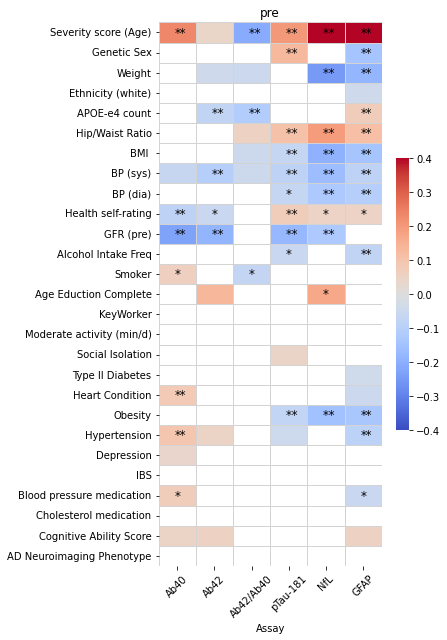

In [1256]:
for pp in ['pre']:#,'post',]: 
    
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in SIMOA_assays],['simp'],vars['pre_comorb'],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table.T.style.format()
    tables['pre_int_'+pp]=table
    tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    # Create a mask for the p-values
    mask=((pvals.T)[rows,:]>0.2).astype(bool)

    # Set the figure size
    fig=plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()
    fig.savefig('pre_int_'+pp+'.svg',dpi=300, bbox_inches = "tight")

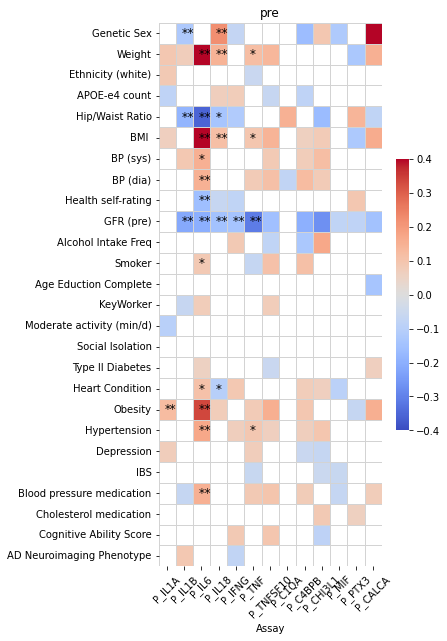

In [1257]:
for pp in ['pre']:#,'post',]: 
    
    assays = OLINK_assays_final # SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    
    (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp'],vars['pre_comorb'][1:],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table.T.style.format()
    tables['pre_int_'+pp]=table
    tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'_OLINK.xlsx')
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    mask=((pvals.T)[rows,:]>0.2).astype(bool)

    # Set the figure size
    fig=plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()
    fig.savefig('pre_int_OLINK'+pp+'.svg',dpi=300, bbox_inches = "tight")


In [1258]:
# # CA9
# for pp in ['pre']:#,'post',]: 

# assays = ['P_CA9', 'P_ATP5IF1'] # SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']

# (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp_ext'],vars['pre_comorb'][1:] ,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

# table=table.rename(columns=cols_translate)
# table.T.style.format()
# tables['pre_int_'+pp]=table
# tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
# rows=(pvals<1).sum(axis=0)>0
# betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
# betas_in=betas_in.iloc[:,rows].T
# mask=((pvals.T)[rows,:]>0.2).astype(bool)

# # Set the figure size
# fig=plt.figure(figsize=(5,10))

# # Create the heatmap
# sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

# for i in range(6):
# for j in range(mask.shape[0]):
#     if pvals[:,rows][i,j] <0.05:
#         plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

# for i in range(6):
# for j in range(mask.shape[0]):
#     if sigs[:,rows][i,j] == 1:
#         plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)



# # Set the x-axis and y-axis labels using cols_translate
# plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
# plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



# # Set the title
# plt.title(pp)

# # Show the plot
# plt.show()
# fig.savefig('pre_int_CA9_'+pp+'.svg',dpi=300, bbox_inches = "tight")



In [1259]:
# for pp in ['pre']:#,'post',]: 
    
#     assays = ['P_CA9', 'P_ATP5IF1'] # SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    
#     (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp'],vars['pre_comorb'][1:] ,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

#     table=table.rename(columns=cols_translate)
#     table.T.style.format()
#     tables['pre_int_'+pp]=table
#     tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
#     rows=(pvals<1).sum(axis=0)>0
#     betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
#     betas_in=betas_in.iloc[:,rows].T
#     mask=((pvals.T)[rows,:]>0.2).astype(bool)

#     # Set the figure size
#     fig=plt.figure(figsize=(5,10))

#     # Create the heatmap
#     sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

#     for i in range(6):
#         for j in range(mask.shape[0]):
#             if pvals[:,rows][i,j] <0.05:
#                 plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

#     for i in range(6):
#         for j in range(mask.shape[0]):
#             if sigs[:,rows][i,j] == 1:
#                 plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
#     # Set the x-axis and y-axis labels using cols_translate
#     plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
#     plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



#     # Set the title
#     plt.title(pp)

#     # Show the plot
#     plt.show()
#     fig.savefig('pre_int_CA9_'+pp+'.svg',dpi=300, bbox_inches = "tight")


In [1260]:
# SIMOA OLINK
# for pp in ['pre']: 
    
#     assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    
#     (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp'],vars['OLINK_pre'] ,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

#     table=table.rename(columns=cols_translate)
#     table.T.style.format()
#     tables['pre_int_'+pp]=table
#     tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
#     rows=(pvals<1).sum(axis=0)>0
#     betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
#     betas_in=betas_in.iloc[:,rows].T
#     mask=((pvals.T)[rows,:]>0.2).astype(bool)

#     # Set the figure size
#     fig=plt.figure(figsize=(5,10))

#     # Create the heatmap
#     sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

#     for i in range(6):
#         for j in range(mask.shape[0]):
#             if pvals[:,rows][i,j] <0.05:
#                 plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

#     for i in range(6):
#         for j in range(mask.shape[0]):
#             if sigs[:,rows][i,j] == 1:
#                 plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
#     # Set the x-axis and y-axis labels using cols_translate
#     plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
#     plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



#     # Set the title
#     plt.title(pp)

#     # Show the plot
#     plt.show()
#     fig.savefig('pre_int_Simoa_OLINK_'+pp+'.svg',dpi=300, bbox_inches = "tight")

## Disease

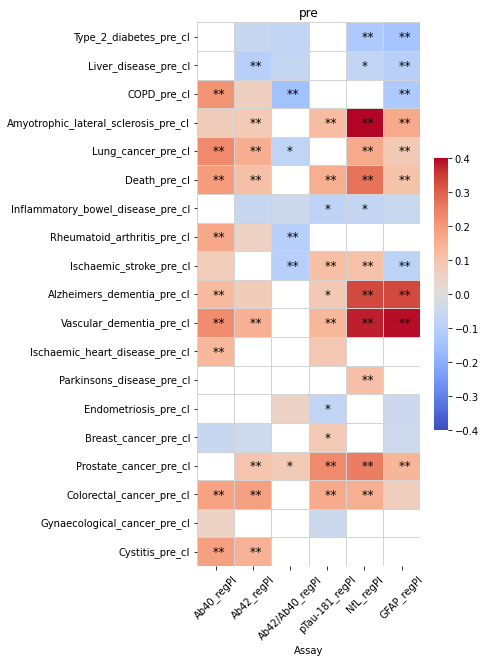

In [1261]:
for pp in ['pre']: 
    
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    
    (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp'],vars['diseases_pre'] ,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table.T.style.format()
    tables['pre_int_'+pp]=table
    tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    mask=((pvals.T)[rows,:]>0.2).astype(bool)

    # Set the figure size
    fig=plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()
    fig.savefig('pre_int_CA9_'+pp+'.svg',dpi=300, bbox_inches = "tight")

## AD Variants

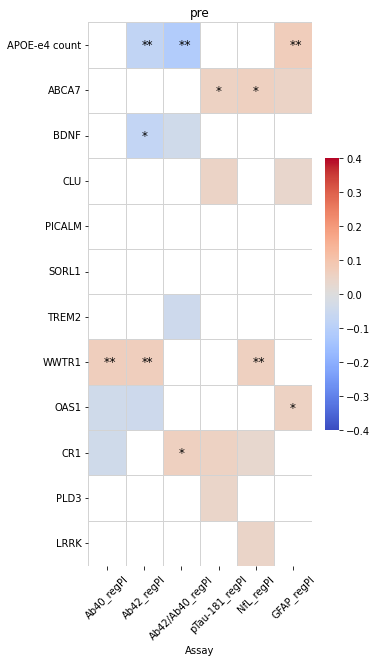

In [1270]:
for pp in ['pre']: 
    
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    
    (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp'],vars['AD_variants'] ,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table.T.style.format()
    tables['pre_int_'+pp]=table
    tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    mask=((pvals.T)[rows,:]>0.2).astype(bool)

    # Set the figure size
    fig=plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()
    fig.savefig('pre_int_CA9_'+pp+'.svg',dpi=300, bbox_inches = "tight")

## PRS

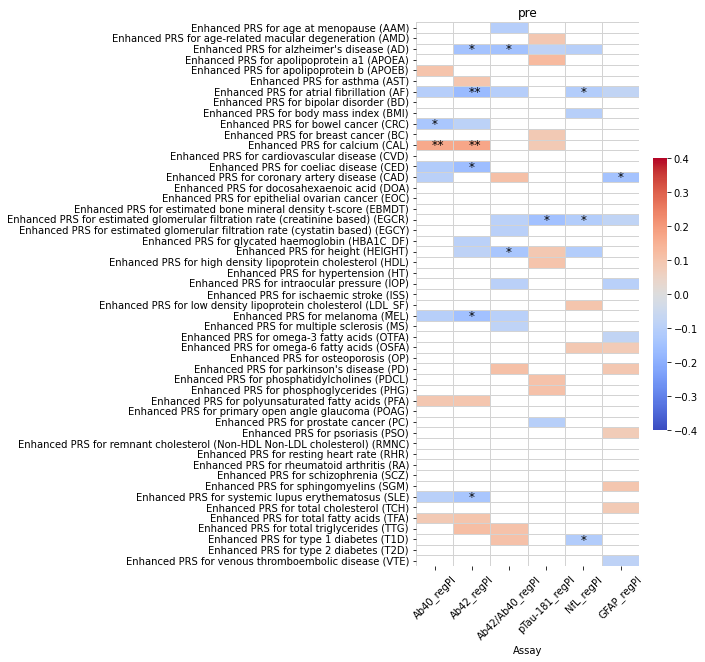

In [1271]:
for pp in ['pre']: 
    
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    
    (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp'],vars['PRS'] ,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table.T.style.format()
    tables['pre_int_'+pp]=table
    tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    mask=((pvals.T)[rows,:]>0.2).astype(bool)

    # Set the figure size
    fig=plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, (PRS[1].values), rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()
    fig.savefig('pre_int_CA9_'+pp+'.svg',dpi=300, bbox_inches = "tight")

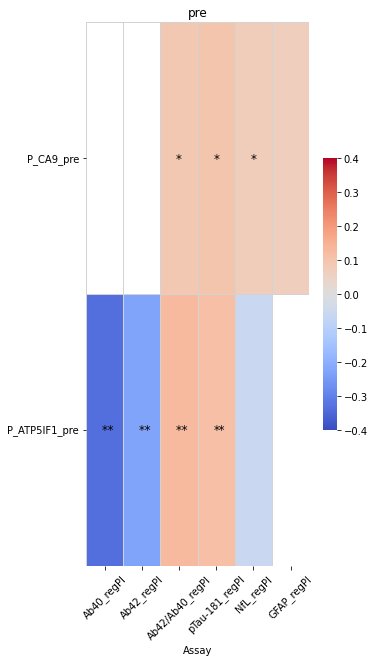

In [1281]:
for pp in ['pre']: 
    
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    
    (table,pvals,pvals_corr,sigs,betas,r)=model_table(outpts_pre,[a + '_' + pp+'_cl' for a in assays],['simp_APOE'],['P_CA9_pre', 'P_ATP5IF1_pre']  ,beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table.T.style.format()
    tables['pre_int_'+pp]=table
    tables['pre_int_'+pp].T.to_excel('tables/within_int_'+pp+'.xlsx')
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    mask=((pvals.T)[rows,:]>0.2).astype(bool)

    # Set the figure size
    fig=plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", vmin=-0.4,vmax=0.4,mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


    
    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()
    fig.savefig('pre_int_CA9_'+pp+'.svg',dpi=300, bbox_inches = "tight")


In [146]:
# table=table.rename(index=lambda x: re.sub('_regPl_','',x))
# table=table.rename(columns=cols_translate)
# table.T.style.format()

## Predicting  post from pre

In [147]:

assays_regPl=['Ab40_regPl',
 'Ab42_regPl',
 'Ab42/Ab40_regPl',
 'pTau-181_regPl',
 'NfL_regPl',
 'GFAP_regPl',
 'P_NEFL',
 'P_GFAP',
 'P_TREM2',
 'P_AXL',
 'P_TYRO3',
 'P_MIF',
 'P_C1QA',
 'P_C4BPB',
 'P_IL6',
 'P_IL18']

#vars={}
#ext='-2.0'
#vars['pre']=[ a + ext for a in ['4080','4079','21002','Hip/Waist',\
# #   '21001','Alcohol','738','Smoking_bin','709','Obesity',\
#      '6350','20018', '894' ,'adni_mean_cl','cog_vars_alz','cog_vars_gi','GeneralHealth','Activity']]\
#    +['APOE_score','845-2.0','Age-2.0','GFR_Cys_pre_cl','depression','heart_cond','hypertension','Deprivation'\
#       ,'Ethnicity(White)','A33vA34','A33vA44','Diabetes','IBS','Chol_meds','KeyWorker',\
#       'WorkingThroughCOVID','31-0.0','BP_meds','Case_vax_prior_bin','Age-2.0_f']
# ext='-3.0'
# vars['post']=[ a + ext for a in ['4080','4079','21002','Hip/Waist',\
#    '21001','Alcohol','738','Smoking_bin','709','Obesity',\
#      '6350','20018', '894' ,'adni_mean_cl','cog_vars_alz','cog_vars_gi','GeneralHealth','Activity']]\
#    +['APOE_score','845-2.0','Age-3.0','GFR_Cys_post_cl','depression','heart_cond','hypertension','Deprivation'\
#       ,'Ethnicity(White)','A33vA34','A33vA44','Diabetes','IBS','Chol_meds','KeyWorker',\
#       'WorkingThroughCOVID','31-0.0','BP_meds','Case_vax_prior_bin','Age-3.0_f']

# ext='_diff'
# vars['diff']=[ a + ext for a in ['4080','4079','21002','Hip/Waist',\
#    '21001','Alcohol','738','Smoking_bin','709','Obesity',\
#      '6350','20018', '894' ,'adni_mean_cl','cog_vars_alz','cog_vars_gi','GeneralHealth','Activity']]
# vars['OLINK_pre']=[ pp+'_pre_cl' for pp in OLINK_assays_final]
# vars['OLINK_post']=[ pp+'_post_cl' for pp in OLINK_assays_final]
# vars['OLINK_diff']=[ pp+'_diff_cl' for pp in OLINK_assays_final]
# vars['diseases_pre']=[a+'_pre_cl' for a in diseases]
# vars['diseases_post']=[a+'_post_cl' for a in diseases]

In [148]:
outpts={}

In [149]:
#['modpre','modpre_ext','modpre_APOE','modpre_GFR'] +OLINK_assays_final vars['pre_comorb']+ 

In [150]:
# # note different primary analysis were performed as follows - 
# # SIMOA_assays - simp () - modpre, modpre_ext:  with interactions across vars['pre_comorb']
# #                         - modpre_ext, 
# #                        - modpre_APOE, modpre_GFR,: interactions not reported
# # ['cog_vars_gi','adni_mean','GeneralHealth'] - simp, modpre,  interactions not reported
# # diseases - 'disease', model=modpre, interactions not reported
# # OLINK_assays_final, model=modpre, interactions 
# # data_in='PCR' -  PCR sensitivity analysis

# # subgroup analyses : co-morbidities, sex
# ext='-3.0'

# a='post_cl'
# c=''

# for b in OLINK_assays_final: # SIMOA_assays+ OLINK_assays_final ['cog_vars_gi','adni_mean','GeneralHealth']: # diseases: # SIMOA_assays: # vars['park']: # ['cog_vars_gi','adni_mean','GeneralHealth']: #+ OLINK_assays_final:  ['cog_vars_gi','adni_mean'] diseases:#  : # [-2:]:#+  ['cog_vars_gi','adni_mean']: #  + diseases SIMOA_assays + OLINK_assays + diseases +  SIMOA_assays  # ['Ab42','Ab40','Ab42/Ab40','GFAP','pTau-181','NfL']:
#     print(b)
#     for data_in in ['simp']: # ['PCR']: #,'red']:# 'simp','disease'
#         for model in ['modpre']: # ['modpre','modpre_ext','modpre_APOE','modpre_GFR']: # 'modpre',#_riskfactors']:#,'modpre']: # 'modpre','modpre_ext',
#             IDP=b+"_"+c+a # " regPl_
#             IDP_pre=b+"_" +c+'pre_cl'#"cl" # " regPl_
#             IDP_diff=b+"_" +c+'diff_cl'
#             # matched data only (no missing for IDP)
#             els=all_matched
#             # ensure that matched case and controls exist for IDP
#             matched=data.loc[:,IDP_diff].dropna().index
#             matched=data.loc[data.loc[matched,'matched_eid'].dropna().values,IDP_diff].notna()
#             ids=matched[matched].index

#             els=all_matched.copy()
#             els[:]=False
#             els[ids]=True 

#             ids=(all_case&els)
#             ids=ids[ids].index
#             ids2=(all_control&els)
#             ids2=ids2[ids2].index

#             idels=(ids==ids) #(np.abs((data.loc[ids,'Activity-3.0'].values-data.loc[ids2,'Activity-3.0'].values))<2000) #&  (data.loc[ids,'Smoking_bin-2.0'].values==data.loc[ids2,'Smoking_bin-2.0'].values) # & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # (np.abs((data.loc[ids,'Hip/Waist-2.0'].values-data.loc[ids2,'Hip/Waist-2.0'].values))<20) #& 
#             els[:]=False


#             if data_in =='red':
#                 idels= idels&(np.abs(data.loc[ids,'APOE_score'].values-data.loc[ids2,'APOE_score'].values))<2
# #(data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values) & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) & (np.abs((data.loc[ids,'Hip/Waist-2.0'].values-data.loc[ids2,'Hip/Waist-2.0'].values))<20) #& 
#             elif data_in == 'disease':
#                 # special case for OLINK disease risk models
#                 idels = idels & (data.loc[ids,'matched_age_mean']<73)
#             elif data_in == 'PCR':
#                 idels = idels & (data.loc[ids,'COVID']=='COVID') 
#             else:
#                 idels=(ids==ids)

#             els[ids[idels]]=True
#             els[ids2[idels]]=True  
            
#             for age_f in ['','age_f_']: 
#                 base_model =  " Q('"+ IDP + "')   ~   Q('"+ IDP_pre + "') + Q('Age"+ext+"') + Q('22001-0.0')   + Q('assessment_sep')+ Q('assessment_sep^2')   "

#                 if model == 'modpre_ext':
#                     # base_model = base_model + "+ C(Q('APOE_score')) + C(Q('Smoking_bin-2.0')) + Q('Hip/Waist-2.0') + Q('4079-2.0') "
#                     #base_model = base_model + "+ C(Q('Diabetes'))+ C(Q('Smoking_bin-2.0')) + C(Q('BP_meds'))+ Q('21002-2.0') + Q('hypertension')+Q('709-3.0')+C(KeyWorker) + C(Q('APOE_score')) "
#                     base_model = base_model + "+ Q('21002-2.0') + Q('Activity-2.0')+Q('709-3.0')+C(KeyWorker)  "

#                 if model == 'modpre_APOE':
#                     # base_model = base_model + "+ C(Q('APOE_score')) + C(Q('Smoking_bin-2.0')) + Q('Hip/Waist-2.0') + Q('4079-2.0') "
#                     #base_model = base_model + "+ C(Q('APOE')) +  C(Q('Smoking_bin"+ext+"'))"
#                     base_model = base_model + "+ (Q('A33vA34')) + (Q('A33vA44')) +(Q('A33vA32')) +  Q('Hip/Waist-2.0') +  C(Q('Diabetes2')) + Q('GeneralHealth-2.0') +  C(Q('Smoking_bin"+ext+"'))"

#                 if model == 'modpre_riskfactors':
#                     # base_model = base_model + "+ C(Q('APOE_score')) + C(Q('Smoking_bin-2.0')) + Q('Hip/Waist-2.0') + Q('4079-2.0') "
#                     base_model = base_model + "+  Q('Hip/Waist-2.0') +  C(Q('Diabetes2'))"

#                 if model == 'modpre_GFR':
#                     # base_model = base_model + "+ C(Q('APOE_score')) + C(Q('Smoking_bin-2.0')) + Q('Hip/Waist-2.0') + Q('4079-2.0') "
#                     base_model = base_model + "+  Q('GFR_Cys_pre_cl') "
 
#             # interactons
#             #=['APOE_score','Case_vax_prior_bin','Diabetes','KeyWorker','BP_meds','Activity-3.0']
#             # vars['diseases_pre']: #vars['OLINK_diff']: # vars['pre']: ['Age-3.0_f']: # ['pre']: # ['Activity-3.0']:#  vars['post'][-2:]:
            

#                 if age_f == '':
#                     case_var="Case_bin"
#                     case_var_hosp=" (Case_hosp_bin_only)  + (Case_nohosp_bin_only) "
#                 else:
#                     base_model=base_model.replace('Age'+'-3.0','Age-3.0_f')
#                     case_var="Case_bin*Q('Age-3.0_f')"
#                     case_var_hosp=" (Case_hosp_bin_only)*Q('Age-3.0_f')  + (Case_nohosp_bin_only)*Q('Age-3.0_f') "
                
                
#                 if model=='modpre':
#                     # sensitivity analyses for comorbidities
                    
#                     for inter in   ['adni_mean_diff_cl','cog_vars_gi_diff_cl','GeneralHealth_diff_cl'] + vars['pre_comorb']+ ['vac_prior_first_pos']:  #['hearing-2.0']: # ['vac_prior_first_pos'] vars['diseases_pre']:#vars['OLINK_pre']: # vars['pre_comorb']:
#                         if data[inter].dtype==bool :
#                             final_model=base_model + " +  C(Q('" + inter + "'))*"+case_var
#                             #query_var = "C(Q('" + inter + "'))[T.True]"
#                             final_model_conf=base_model + " +  C(Q('" + inter + "')) + "+case_var

#                             #query_var_conf = "C(Q('" + inter + "'))[T.True]"
#                         else:
#                             # remove age when assessing age-related-vulnerability
#                             if (inter[-2:]=='_f') & (age_f==''): 
#                                 final_model=base_model.replace('Age'+ext,inter)
#                                 final_model = final_model + " +  Q('" + inter + "'):"+case_var+ " +  "+case_var
#                                 final_model_conf = final_model + " +  "+case_var
                                
#                                 #query_var = "Q('" + inter + "')"
#                                 #final_model_conf=base_model + " +  Q('" + inter + "') + "+case_var                               
#                             else:    
#                                 final_model=base_model + " +  Q('" + inter + "')*"+case_var
#                                 #query_var = "Q('" + inter + "')"
#                                 final_model_conf=base_model + " +  Q('" + inter + "') + "+case_var
#                                 #query_var_conf = "Q('" + inter + "')"
                
                    
#                         outpts[IDP+'_'+inter +'_int_'+age_f+data_in + '_' + model]=  ols_simp(formula=final_model,data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
#                         outpts[IDP+'_'+inter +'_conf_'+age_f+data_in + '_' + model]=  ols_simp(formula=final_model_conf,data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")


#                 outpts[IDP+'_'+age_f+data_in + '_' + model]=ols_simp(formula=base_model + " + " + case_var ,data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
#                 outpts[IDP+'_'+age_f+data_in + '_' + model +'_hosp_only']=ols_simp(formula=base_model  + " + " + case_var_hosp ,data=data[els],pre=IDP_pre,case='Case_hosp_bin_only').fit()
#                 outpts[IDP+'_'+age_f+data_in + '_' + model +'_basxtime']=ols_simp(formula= base_model +  " + Case_bin +  Q('"+ IDP_pre + "')*Q('assessment_sep')" ,data=data[els],pre=IDP_pre).fit()
            
#             outpts[IDP+'_simp_modpre_f']=ols_simp(formula="   Q('"+ IDP + "')   ~   Case_bin*Q('Age-3.0_f')  + Q('assessment_sep')+ Q('assessment_sep^2') +  Q('22001-0.0') +  Q('"+ IDP_pre + "')    ", data=data[els],pre=IDP_pre).fit() # +  Q('"+bbd['gSex']+"')++ C(PlateID_"+a+")
   

In [151]:
# Additional inflammatory proteins of interest
#for a in ['IL12B', 'OPG', 'CXCL11',  'CSF1', 'CCL23', 'CCL25', 'TNFRSF9', 'TGF',  'VEGFA','CD38']:
#    print(find_vars(data,a))

### Basic model results

In [470]:
vars['pre_comorb']

['Age-2.0_f',
 '22001-0.0',
 '21002-2.0',
 'Ethnicity(White)',
 'APOE_score',
 'Hip/Waist-2.0',
 '21001-2.0',
 '4080-2.0',
 '4079-2.0',
 'GeneralHealth-2.0',
 'GFR_Cys_pre_cl',
 'Alcohol-2.0',
 'Smoking_bin-2.0',
 '845-2.0',
 'KeyWorker',
 'Activity-2.0',
 'isolation-2.0',
 'Diabetes2',
 'Heart_Cond',
 'Obesity-2.0',
 'hypertension',
 'depression',
 'IBS',
 'BP_meds',
 'Chol_meds',
 'cog_vars_gi-2.0',
 'adni_mean_cl-2.0']

In [471]:

outpts=calc_pre_post_models(data,all_matched,outpts, SIMOA_assays,data_ins=['simp'],models=['modpre'],inter_vars= vars['pre_comorb']+['adni_mean_pre_cl','cog_vars_gi_pre_cl','GeneralHealth_pre_cl'] + ['adni_mean_diff_cl','cog_vars_gi_diff_cl','GeneralHealth_diff_cl'] + ['vac_prior_first_pos'] + vars['OLINK_pre'] +    vars['diseases_pre'],a='post_cl',c='',ext='-3.0')


Ab40_regPl
Ab42_regPl
Ab42/Ab40_regPl
pTau-181_regPl
NfL_regPl
GFAP_regPl


In [339]:

model='_simp_modpre'
age_f=''
vars_show=['Case_bin','Age-3.0','22001-0.0','assessment_sep','assessment_sep^']

#model='modpre'
#outpts[IDP+age_f+data_in + '_' + model].pvalues/2
(table,pvals,pvals_corr,sigs,betas,resultst)=model_table(outpts,[a + '_post_cl' for a in SIMOA_assays],[model],vars_show,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=False,FPR='col')
table=table.rename(columns=cols_translate)
table=table.T.rename(columns=cols_translate).T
table.style.format()

,n,Case/Control status,Age (pandemic),Genetic Sex,Assessment Interval (d),assessment_sep^
Assay,,,,,,
Ab40_regPl_p,1211,0.0216 (p=0.818),0.1686 (p=1.000),-0.0347 (p=0.074),0.0325 (p=0.593),0.0157 (p=0.545)
Ab42_regPl_p,1209,-0.0353 (p=0.054),0.0247 (p=0.864),-0.0341 (p=0.062),0.0636 (p=0.690),-0.0338 (p=0.396)
Ab42/Ab40_regPl_p,1196,-0.0601 (p=6.6e-04**),-0.0576 (p=0.002**),-0.0046 (p=0.404),0.0570 (p=0.700),-0.0663 (p=0.271)
pTau-181_regPl_p,1162,-0.0099 (p=0.658),0.1375 (p=3.5e-08**),0.0984 (p=3.6e-05**),0.3086 (p=0.014*),-0.3093 (p=0.986)
NfL_regPl_p,1156,-0.0086 (p=0.686),0.1093 (p=8.9e-08**),-0.0239 (p=0.909),0.1455 (p=0.076),-0.0881 (p=0.808)
GFAP_regPl_p,1156,-0.0079 (p=0.638),0.1398 (p=5.9e-13**),-0.0607 (p=4.5e-04**),0.1401 (p=0.147),-0.1496 (p=0.121)


In [486]:
table=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/basic_model.xlsx')
table.style.format()

,n,Case/Control status,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,
Aβ40,1211,0.0216 (p=0.182),-0.0347 (p=0.148),0.1686 (p=2.1e-11**),0.0325 (p=0.815),0.0157 (p=0.910),0.5052 (p=7.4e-82**)
Aβ42,1217,-0.0352 (p=0.057),-0.0322 (p=0.152),0.0285 (p=0.211),0.0534 (p=0.682),-0.0149 (p=0.909),0.6286 (p=2.1e-135**)
Aβ42/Aβ40,1196,-0.0601 (p=6.6e-04**),-0.0046 (p=0.809),-0.0576 (p=0.003**),0.0570 (p=0.600),-0.0663 (p=0.541),0.7441 (p=5.8e-213**)
pTau-181,1195,-0.0092 (p=0.648),0.1007 (p=5.0e-05**),0.1433 (p=1.9e-08**),0.2723 (p=0.056),-0.2747 (p=0.053),0.4758 (p=6.9e-69**)
NfL,1219,-0.0053 (p=0.620),-0.0228 (p=0.191),0.1193 (p=5.6e-09**),0.1752 (p=0.083),-0.1177 (p=0.243),0.7401 (p=8.0e-200**)
GFAP,1223,-0.0042 (p=0.601),-0.0573 (p=6.4e-04**),0.1408 (p=8.1e-14**),0.1583 (p=0.099),-0.1592 (p=0.096),0.7468 (p=1.1e-229**)


In [342]:
# import numpy as np
# from statsmodels.stats.meta_analysis import combine_effects

# # dummy data
# mean_effect = betas
# var_effect = np.array([0.2025,1.2100,0.0900,0.2025,0.3844,0.5625,0.0676,0.0225,1.8225])
# idx = ['lab1','lab2','lab3','lab4','lab5','lab6','lab7','lab8','lab9']

# # meta-analysis and forest plot
# results = combine_effects(mean_effect, var_effect, method_re="chi2", use_t=True, row_names=idx)
# print(results.summary_frame())
# fig = results.plot_forest()

In [390]:
### Results table

(table,pvals,pvals_corr,sigs,betas,resultstable)=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre'],['Case_bin','Age-3.0','22001-0.0','assessment_sep'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()
#table.to_excel('tables/basic_model.xlsx')
table.style.format()

,n,Case/Control status,Age (y),Genetic Sex,Assessment Interval (d)
Assay,,,,,
Aβ40,1211,0.0216 (p=0.182),0.1686 (p=2.1e-11**),-0.0347 (p=0.148),0.0325 (p=0.815)
Aβ42,1209,-0.0353 (p=0.054),0.0247 (p=0.272),-0.0341 (p=0.125),0.0636 (p=0.621)
Aβ42/Aβ40,1196,-0.0601 (p=6.6e-04**),-0.0576 (p=0.003**),-0.0046 (p=0.809),0.0570 (p=0.600)
pTau-181,1162,-0.0099 (p=0.658),0.1375 (p=7.1e-08**),0.0984 (p=7.3e-05**),0.3086 (p=0.029**)
NfL,1156,-0.0086 (p=0.686),0.1093 (p=1.8e-07**),-0.0239 (p=0.181),0.1455 (p=0.152)
GFAP,1156,-0.0079 (p=0.681),0.1398 (p=5.9e-13**),-0.0607 (p=4.5e-04**),0.1401 (p=0.147)


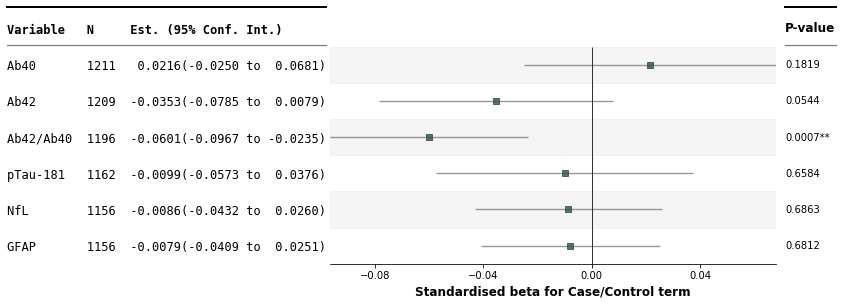

In [391]:
ff=fp.forestplot(resultstable['Case_bin'],  # the dataframe with results data
              estimate="betas_norm",  # col containing estimated effect size 
              ll="ci_l_norm", hl="ci_u_norm",  # columns containing conf. int. lower and higher limits
              varlabel="Assay",  # column containing variable label
             
                            
              pval='pvals',
                 starpval=True,
                 thresholds=[0.02,0.05],
                 symbols=['**','*'],
              annote=["n", "est_ci"],
              decimal_precision=4,
              annoteheaders=["N", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              #ylabel="Confidence interval",  # y-label title
              xlabel="Standardised beta for Case/Control term",  # x-label title
              table=True,
              color_alt_rows=True,figsize=(8,4.5),kwargs={"xlinecolor": ".5"})
offset=0.3
ff.set_ylim((ff.get_ylim()[0], ff.get_ylim()[1]+offset))
fig=plt.gcf()
fig.savefig('basic_fig.svg', format="svg",dpi=300, bbox_inches = "tight")

In [628]:
resultstable

{'Case_bin':                Assay     n     betas  betas_norm        pc      ci_l  \
 Assay                                                                  
 Ab40            Ab40  1211  0.736508    0.021562  0.852507 -0.854283   
 Ab42            Ab42  1209 -0.101748   -0.035302 -1.574756 -0.226128   
 Ab42/Ab40  Ab42/Ab40  1196 -0.001569   -0.060098 -2.074514 -0.002525   
 pTau-181    pTau-181  1162 -0.007347   -0.009871 -1.129949 -0.042668   
 NfL              NfL  1156 -0.006858   -0.008566 -0.268609 -0.034564   
 GFAP            GFAP  1156 -0.007028   -0.007926 -0.160194 -0.036292   
 
            ci_l_norm      ci_u  ci_u_norm     pvals  
 Assay                                                
 Ab40       -0.025010  2.327298   0.068134  0.181940  
 Ab42       -0.078456  0.022631   0.007852  0.054383  
 Ab42/Ab40  -0.096720 -0.000613  -0.023476  0.000659  
 pTau-181   -0.057327  0.027975   0.037586  0.658359  
 NfL        -0.043175  0.020848   0.026043  0.686337  
 GFAP       -0.04

### Percentage change hospitalisation vs non-hospitalisation and Lateral-Flow exclusion

In [392]:
outpts['Ab42/Ab40_regPl_post_cl_simp_modpre_hosp_only'].params

Intercept                      2.290562e-02
Q('Ab42/Ab40_regPl_pre_cl')    7.303970e-01
Q('Age-3.0')                  -1.070804e-04
Q('22001-0.0')                -1.189786e-04
Q('assessment_sep')            1.345223e-06
Q('assessment_sep^2')         -5.329747e-10
Case_hosp_bin_only            -4.146585e-03
Case_nohosp_bin_only          -1.479144e-03
dtype: float64

In [393]:
-5.482921793487978*(-1.479144e-03/-4.146585e-03)

-1.9558337459154898

In [394]:
outpts['Ab42/Ab40_regPl_post_cl_simp_modpre_hosp_only'].pc

-5.482921793487978

In [395]:
model='_simp_modpre_hosp_only'
age_f=''
vars_show=['Case_no','Case_hosp','Age-3.0','22001-0.0','assessment_sep','assessment_sep^']

#model='modpre'
#outpts[IDP+age_f+data_in + '_' + model].pvalues/2
(table,pvals,pvals_corr,sigs,betas,resultst)=model_table(outpts,[a + '_post_cl' for a in SIMOA_assays],[model],vars_show,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=False,FPR='col')
table=table.rename(columns=cols_translate)
table=table.T.rename(columns=cols_translate).T
table.to_excel('tables/basic_hosp.xlsx')
table.style.format()

,n,Case_no,Case_hosp,Age (pandemic),Genetic Sex,Assessment Interval (d),assessment_sep^
Assay,,,,,,,
Ab40_regPl_p,1211,0.0234 (p=0.838),-0.0082 (p=0.365),0.1687 (p=1.000),-0.0347 (p=0.074),0.0327 (p=0.593),0.0155 (p=0.545)
Ab42_regPl_p,1209,-0.0322 (p=0.072),-0.0200 (p=0.181),0.0247 (p=0.864),-0.0341 (p=0.062),0.0638 (p=0.690),-0.0340 (p=0.395)
Ab42/Ab40_regPl_p,1196,-0.0557 (p=0.001**),-0.0290 (p=0.060),-0.0575 (p=0.002**),-0.0045 (p=0.405),0.0572 (p=0.701),-0.0665 (p=0.270)
pTau-181_regPl_p,1162,-0.0163 (p=0.750),0.0331 (p=0.086),0.1371 (p=3.8e-08**),0.0981 (p=3.8e-05**),0.3100 (p=0.014*),-0.3107 (p=0.986)
NfL_regPl_p,1156,-0.0136 (p=0.779),0.0258 (p=0.072),0.1090 (p=9.4e-08**),-0.0238 (p=0.909),0.1454 (p=0.076),-0.0879 (p=0.808)
GFAP_regPl_p,1156,-0.0098 (p=0.559),0.0093 (p=0.581),0.1398 (p=6.0e-13**),-0.0607 (p=4.5e-04**),0.1399 (p=0.147),-0.1495 (p=0.121)


In [396]:
SIMOA_assays[1:3]

['Ab42_regPl', 'Ab42/Ab40_regPl']

In [397]:
# Include only those with  PCR
#outpts=calc_pre_post_models(data,all_matched,outpts, SIMOA_assays,data_ins=['simp'],models=['modpre'],inter_vars= vars['pre_comorb']+['adni_mean_diff_cl','cog_vars_gi_diff_cl','GeneralHealth_diff_cl'] + ['vac_prior_first_pos'] + vars['OLINK_pre'] +    vars['diseases_pre'],a='post_cl',c='',ext='-3.0')

outpts=calc_pre_post_models(data,all_matched,outpts, SIMOA_assays,data_ins=['PCR'],models=['modpre'],inter_vars= [],a='post_cl',c='',ext='-3.0')


Ab40_regPl
614
614
Ab42_regPl
617
617
Ab42/Ab40_regPl
606
606
pTau-181_regPl
606
606
NfL_regPl
618
618
GFAP_regPl
620
620


In [398]:

model='_PCR_modpre'
age_f=''
vars_show=['Case_bin','Age-3.0','22001-0.0','assessment_sep','assessment_sep^']

#model='modpre'
#outpts[IDP+age_f+data_in + '_' + model].pvalues/2
(table,pvals,pvals_corr,sigs,betas,resultst)=model_table(outpts,[a + '_post_cl' for a in SIMOA_assays],[model],vars_show,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=False,FPR='col')
table=table.rename(columns=cols_translate)
table=table.T.rename(columns=cols_translate).T
table.to_excel('tables/basic_PCR.xlsx')
table.style.format()

,n,Case/Control status,Age (pandemic),Genetic Sex,Assessment Interval (d),assessment_sep^
Assay,,,,,,
Ab40_regPl_p,903,0.0301 (p=0.862),0.1611 (p=1.000),-0.0306 (p=0.136),-0.0059 (p=0.486),0.0516 (p=0.625)
Ab42_regPl_p,907,-0.0167 (p=0.261),0.0244 (p=0.821),-0.0296 (p=0.129),-0.0376 (p=0.403),0.0748 (p=0.687)
Ab42/Ab40_regPl_p,888,-0.0730 (p=4.9e-04**),-0.0781 (p=3.9e-04**),-0.0054 (p=0.404),0.0132 (p=0.541),-0.0425 (p=0.370)
pTau-181_regPl_p,888,-0.0274 (p=0.835),0.1603 (p=2.9e-08**),0.1050 (p=1.2e-04**),0.2250 (p=0.085),-0.2347 (p=0.924)
NfL_regPl_p,909,0.0150 (p=0.216),0.1005 (p=4.3e-06**),-0.0234 (p=0.889),0.1827 (p=0.049*),-0.1442 (p=0.904)
GFAP_regPl_p,910,-0.0115 (p=0.545),0.1329 (p=1.1e-09**),-0.0405 (p=0.036*),0.1134 (p=0.309),-0.1193 (p=0.283)


### Age-Related Vulnerabililty

In [644]:
### Results table Age-related vulnerability

(table,pvals,pvals_corr,sigs,betas,resultstable_age_f)=model_table(outpts,assays_regPl[:6],['_post_cl_age_f_simp_modpre'],['Case_bin','Age-3.0','Case_bin:','22001-0.0','assessment_sep','pre'],beta_dirs=[-1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age-Related Vulnerability'})
table=table.rename(columns={'Case_bin:':'ARV : Case/Control status'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.style.format()
table.to_excel('tables/basic_model_age_f.xlsx')
table.style.format()

,n,Case/Control status,Age-Related Vulnerability,ARV : Case/Control status,Genetic Sex,Assessment Interval (d),Baseline protein
Assay,,,,,,,
Aβ40,1211,0.0534 (p=0.947),0.2037 (p=5.5e-09**),-0.0570 (p=0.081),-0.0391 (p=0.105),0.0660 (p=0.635),0.5014 (p=4.7e-80**)
Aβ42,1217,0.0053 (p=0.568),0.0711 (p=0.026*),-0.0719 (p=0.030*),-0.0331 (p=0.141),0.0598 (p=0.647),0.6281 (p=4.0e-135**)
Aβ42/Aβ40,1196,-0.0541 (p=0.019*),-0.0517 (p=0.057),-0.0105 (p=0.372),-0.0033 (p=0.861),0.0454 (p=0.677),0.7449 (p=3.2e-214**)
pTau-181,1195,-0.0592 (p=0.961),0.1041 (p=0.003**),0.0881 (p=0.017**),0.0960 (p=1.1e-04**),0.3041 (p=0.032**),0.4750 (p=2.1e-69**)
NfL,1219,-0.0265 (p=0.864),0.0854 (p=0.001**),0.0383 (p=0.099),-0.0244 (p=0.164),0.1954 (p=0.054),0.7524 (p=2.9e-213**)
GFAP,1223,-0.0049 (p=0.584),0.1173 (p=2.9e-06**),0.0015 (p=0.478),-0.0559 (p=9.9e-04**),0.1727 (p=0.074),0.7609 (p=9.8e-239**)


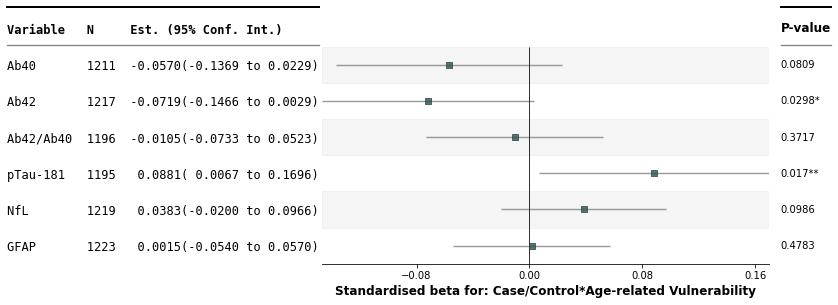

In [645]:
ff=fp.forestplot(resultstable_age_f['Case_bin:'],  # the dataframe with results data
              estimate="betas_norm",  # col containing estimated effect size 
              ll="ci_l_norm", hl="ci_u_norm",  # columns containing conf. int. lower and higher limits
              varlabel="Assay",  # column containing variable label
              pval='pvals',
                 starpval=True,
                 thresholds=[0.02,0.05],
                 symbols=['**','*'],
              decimal_precision=4,
              annote=["n", "est_ci"],
              annoteheaders=["N", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              #ylabel="Confidence interval",  # y-label title
              xlabel="Standardised beta for: Case/Control*Age-related Vulnerability",  # x-label title
              table=True,
              color_alt_rows=True,figsize=(8,4.5),kwargs={"xlinecolor": ".5"})
offset=0.3
ff.set_ylim((ff.get_ylim()[0], ff.get_ylim()[1]+offset))
#plt.show()
fig=plt.gcf()
fig.savefig('age_f_fig.svg', format="svg",dpi=300, bbox_inches = "tight")

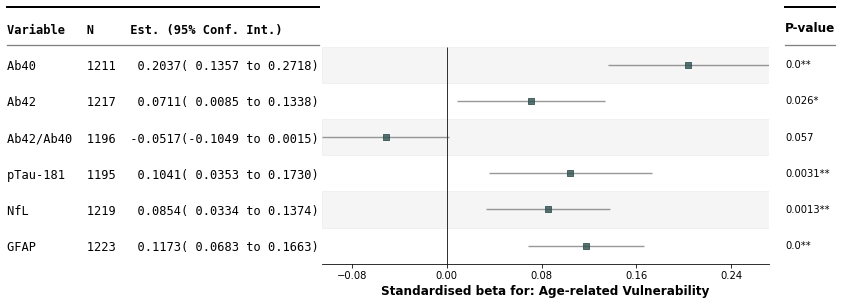

In [643]:
ff=fp.forestplot(resultstable_age_f['Age-3.0'],  # the dataframe with results data
              estimate="betas_norm",  # col containing estimated effect size 
              ll="ci_l_norm", hl="ci_u_norm",  # columns containing conf. int. lower and higher limits
              varlabel="Assay",  # column containing variable label
                 thresholds=[0.02,0.05],
                 symbols=['**','*'],
              pval='pvals',
              annote=["n", "est_ci"],
              annoteheaders=["N", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              #ylabel="Confidence interval",  # y-label title
              xlabel="Standardised beta for: Age-related Vulnerability",  # x-label title
              table=True,
              decimal_precision=4,
              color_alt_rows=True,figsize=(8,4.5),kwargs={"xlinecolor": ".5"})
offset=0.3
ff.set_ylim((ff.get_ylim()[0], ff.get_ylim()[1]+offset))

fig=plt.gcf()
fig.savefig('age_f_age_fig.svg', format="svg",dpi=300, bbox_inches = "tight")

In [403]:

model='_PCR_modpre'
age_f='_age_f'
vars_show=['Case_bin','Case_bin:','Age-3.0','22001-0.0','assessment_sep','assessment_sep^']

#model='modpre'
#outpts[IDP+age_f+data_in + '_' + model].pvalues/2
(table,pvals,pvals_corr,sigs,betas,resultst)=model_table(outpts,[a + '_post_cl' for a in SIMOA_assays],[age_f +  model],vars_show,beta_dirs=[-1,-1,-1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=False,FPR='col')
table=table.rename(columns=cols_translate)
table=table.T.rename(columns=cols_translate).T
table.to_excel('tables/basic_PCR_age_f.xlsx')
table.style.format()

,n,Case/Control status,ARV : Case/Control status,Age (pandemic),Genetic Sex,Assessment Interval (d),assessment_sep^
Assay,,,,,,,
Ab40_regPl_p,903,0.0709 (p=0.968),-0.0747 (p=0.059),0.2061 (p=1.000),-0.0338 (p=0.113),0.0203 (p=0.550),0.0254 (p=0.562)
Ab42_regPl_p,907,0.0305 (p=0.802),-0.0846 (p=0.029*),0.0758 (p=0.978),-0.0322 (p=0.110),-0.0273 (p=0.430),0.0655 (p=0.665)
Ab42/Ab40_regPl_p,888,-0.0751 (p=0.007**),0.0051 (p=0.553),-0.0760 (p=0.011**),-0.0054 (p=0.405),0.0040 (p=0.513),-0.0325 (p=0.400)
pTau-181_regPl_p,888,-0.0842 (p=0.985),0.1013 (p=0.017*),0.1106 (p=0.003**),0.1024 (p=1.7e-04**),0.2604 (p=0.056),-0.2707 (p=0.951)
NfL_regPl_p,909,0.0135 (p=0.304),0.0033 (p=0.460),0.0858 (p=0.002**),-0.0240 (p=0.894),0.2009 (p=0.035*),-0.1630 (p=0.929)
GFAP_regPl_p,910,-0.0144 (p=0.707),0.0045 (p=0.445),0.1124 (p=5.5e-05**),-0.0395 (p=0.979),0.1225 (p=0.137),-0.1318 (p=0.881)


### example differences for 75 yo

In [405]:
# example differences for 75 yo

IDP='pTau-181_regPl_post_cl'
age_f=''
model='modpre'
data_in='simp'

# model settings
BL=0.075
age=75
BMI=25
gap=4*365
sex=1

m_case=(outpts[IDP+'_'+age_f+data_in + '_' + model].params*np.array([1,BL,age,sex,gap,gap**2,1])).sum()
m_control=(outpts[IDP+'_'+age_f+data_in + '_' + model].params*np.array([1,BL,age,sex,gap,gap**2,0])).sum()

# empirical % difference
print(100*(m_case-m_control)/0.075)
# modelled difference
print(outpts[IDP+'_'+age_f+data_in + '_' + model].pc)
print("Modelled Control")
print(100*(0.075-m_control)/0.075)
print("Modelled Case")
print(100*(0.075-m_case)/0.075)

-9.795671372654063
-1.1299492838047225
Modelled Control
-503.89453294774665
Modelled Case
-494.0988615750925


In [406]:
# example differences for 75 yo

IDP='Ab40_regPl'

model='modpre'
data_in='simp'



model_diffs={}
model_vals={}

for IDP in assays_regPl[:6]:
    

    # model settings for average participant
    # Baseline value
    age=75
    els= all_matched & ((data.loc[:,'Age-3.0']-age).abs()<2) & (data.loc[:,'22001-0.0']==0)
    BL=data.loc[els,IDP+'_pre_cl'].mean()
    dm=10**(data.loc[:,'Age-3.0']*0.0524-3.27)
    age_f_val=(10**(age*0.0524-3.27))/np.mean(dm)
    # 4 year gap between pre and post
    gap=4*365
    sex=0

    for age_f in ['','age_f_']:

        for cc in [0,1]:
            if cc==0:
                case='_control'
            else:   
                case='_case'

            if age_f == '':
                betas = np.array([1,BL,age,sex,gap,gap**2,cc]) 
            else:
                betas = np.array([1,BL,age_f_val,sex,gap,gap**2,cc,cc*age_f_val])

            model_vals[IDP+age_f+case]=(outpts[IDP+'_post_cl_'+age_f+data_in + '_' + model].params*betas).sum()

        m_case=model_vals[IDP+age_f+'_case']
        m_control=model_vals[IDP+age_f+'_control']

        # empirical % difference

        model_diffs[IDP+'_'+age_f+'pc'] = (100*(m_case-m_control)/m_control)
    
        # # modelled difference
        # print(outpts[IDP+'_post_cl'+'_'+age_f+data_in + '_' + model].pc)
        # print("Modelled Control")
        # print(100*(BL-m_control)/BL)
        # print("Modelled Case")
        # print(100*(BL-m_case)/BL)

In [407]:
model_diffs

{'Ab40_regPl_pc': 0.7586610119779659,
 'Ab40_regPl_age_f_pc': -1.2000945537174428,
 'Ab42_regPl_pc': -1.5777512202165074,
 'Ab42_regPl_age_f_pc': -4.750741086009692,
 'Ab42/Ab40_regPl_pc': -2.3289626043751976,
 'Ab42/Ab40_regPl_age_f_pc': -2.7169261017925783,
 'pTau-181_regPl_pc': -1.0144884480616874,
 'pTau-181_regPl_age_f_pc': 8.495766618444305,
 'NfL_regPl_pc': -0.22807625760268063,
 'NfL_regPl_age_f_pc': 1.0667300174557774,
 'GFAP_regPl_pc': -0.14095231857127813,
 'GFAP_regPl_age_f_pc': 0.06598128316028995}

In [408]:
age_f_val

2.6607734189268126

In [409]:
ii=np.abs(data.loc[:,'Age-3.0']-75).argmin()
data.loc[:,'Age-3.0_f'].values[ii]

2.6651748201763574

In [410]:
data.loc[all_matched,'Ab42_regPl_pre_cl'].mean()

6.46483201574957

### Interactions 

In [411]:
# vars_show=['Case_bin',"Q('Age-3.0')","Q('assessment_sep')","Q('Hip/Waist-2.0')","C(Q('Diabetes2'))[T.True]"]
# (table,pvals,pvals_corr,sigs,betas)=model_table(outpts,[a + '_cl' for a in assays],['_modpre_age_f_riskfactors'],vars_show,beta_name_add=beta_name,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=False,FPR='col')
# table=table.rename(columns=cols_translate)
# table=table.T.rename(columns=cols_translate).T
# table.T.style.format()

In [412]:
IDP='pTau-181_regPl_post_cl'
IDP='Ab42/Ab40_regPl_post_cl'
outpts[IDP+'_simp_modpre'].pc

-2.074513645699812

In [413]:
# Example model

IDP='Ab42/Ab40_regPl_post_cl'
age_f=''
model='modpre'
data_in='simp'

# model settings
BL=0.075
age=75
BMI=25
gap=4*365
sex=1

m_case=(outpts[IDP+'_'+age_f+data_in + '_' + model].params*np.array([1,BL,age,sex,gap,gap**2,+0.5])).sum()
m_control=(outpts[IDP+'_'+age_f+data_in + '_' + model].params*np.array([1,BL,age,sex,gap,gap**2,-0.5])).sum()

# modelled % difference
print(100*(m_case-m_control)/0.075)
print("Modelled Control")
print(100*(0.075-m_control)/0.075)
print("Modelled Case")
print(100*(0.075-m_case)/0.075)

-2.0918646538643135
Modelled Control
4.093224278431636
Modelled Case
6.185088932295949


In [414]:
(-1.108086e-07*365)/-1.712936e-03

0.023611587940238283

In [415]:
IDP='Ab42/Ab40_regPl_post_cl'
age_f=''
model='modpre'
data_in='simp'
outpts[IDP+'_'+age_f+data_in + '_' + model].pvalues/2


Intercept                       8.815115e-12
Q('Ab42/Ab40_regPl_pre_cl')    2.876061e-213
Q('Age-3.0')                    1.711795e-03
Q('22001-0.0')                  4.044117e-01
Q('assessment_sep')             2.999180e-01
Q('assessment_sep^2')           2.705289e-01
Case_bin                        6.590327e-04
dtype: float64

In [416]:
mean_assess_sep=data.loc[all_matched,'assessment_sep'].mean()

In [417]:
mean_pre=data.loc[all_matched,'Ab42/Ab40_regPl_pre_cl'].mean()

In [418]:
 no_case_effect=2.412239e-02+0.0755620358816737*7.331141e-01 + 70*(-1.010822e-04) -2.130467e-04 - 1179*(2.001884e-07)

In [419]:
mean_pre/(no_case_effect)

1.049572413836087

In [420]:
mean_pre/(no_case_effect-1.556185e-03)

1.0727609284078714

In [421]:
# percentage change with Case
IDP='Ab42/Ab40_regPl_post_cl'
a='Case_bin'
case="Q('" + a + "')"
print('PC for simple model: ' + str(outpts[IDP+'_simp_modpre'].pc))
#print(outpts_pre[IDP+'_'+a+'_simp'].pvalues)
#print('PC for ext model: ' + str(outpts[IDP+'_simp_modpre_ext'].pc))
#print(outpts_pre[IDP+'_simp'].pvalues)

PC for simple model: -2.074513645699812


### Change heatmaps

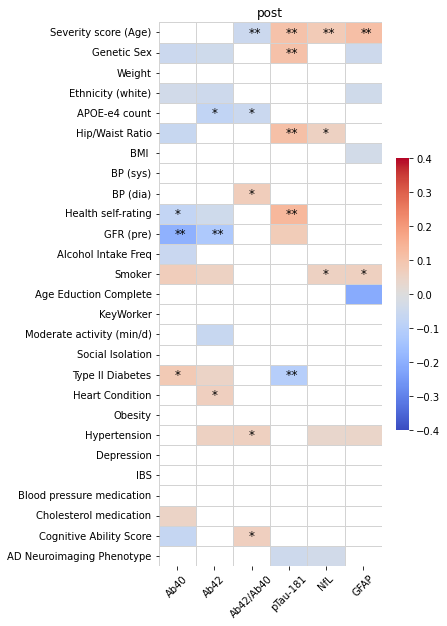

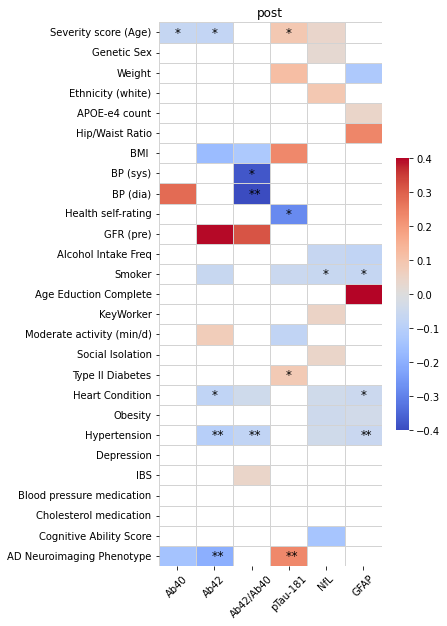

Text(0.5, 1.0, 'post')

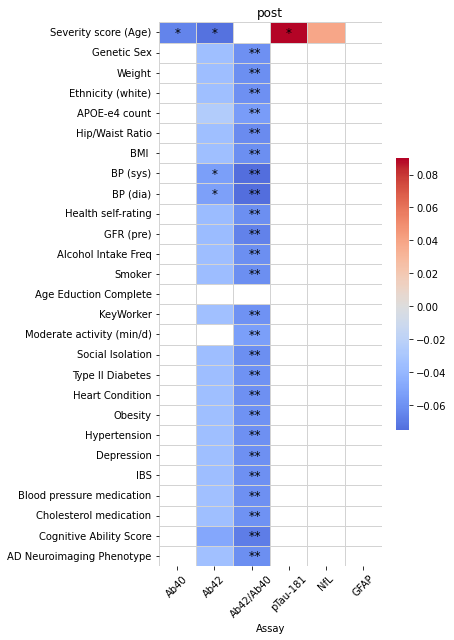

In [490]:

pp='post'
vars_show=vars['pre_comorb']


for beta_name in ['','Case']:
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    (table,pvals,pvals_corr,sigs,betas,sdf)=model_table(outpts,[a + '_' + pp+'_cl' for a in assays],['int_simp_modpre'],vars_show,beta_name_add=beta_name,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table=table.T.rename(columns=cols_translate).T
    table.index=[a[:-6] for a in assays]
    table.T.style.format()
    tables['pre_int_'+beta_name]=table.T
    table.T.to_excel('tables/post_int_'+beta_name+'.xlsx')
    
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    #     ccs=data.loc[all_matched,[a+'_pre_cl' for a in assays]+vars_show].corr().iloc[6:,:6]
    #     ccs=ccs.rename(index=cols_translate)
    #     ccs_good_labels=ccs.index[rows]
    #     ccs_good=ccs.values[rows]
    #     ccs_good.shape
    mask=((pvals.T)[rows,:]>0.2).astype(bool)


    # Set the figure size
    fig=plt.figure(figsize=(5,10))

    # Create the heatmap
    plot=sns.heatmap(betas_in, annot=False, vmin=-0.4,vmax=0.4,fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


#     for i in np.arange(6):

#         for j in range(mask.shape[0]):
#             if sigs[:,rows][i,j] == 1:
#                 plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()
    #ff=plt.gcf()
    fig.savefig('post_int_'+beta_name+'.svg',dpi=300, bbox_inches = "tight")

(table,pvals,pvals_corr,sigs,betas,sdf)=model_table(outpts,[a + '_' + pp+'_cl' for a in assays],['conf_simp_modpre'],vars_show,beta_name_only='Case_bin',beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='row')
table=table.rename(columns=cols_translate)
table=table.T.rename(columns=cols_translate).T
table.T.style.format()
tables['pre_conf']=table

rows=(pvals<1).sum(axis=0)>0
betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
betas_in=betas_in.iloc[:,rows].T

mask=((pvals.T)[rows,:]>0.2).astype(bool)

# Set the figure size
plt.figure(figsize=(5,10))

# Create the heatmap
sns.heatmap(betas_in, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

for i in range(6):
    for j in range(mask.shape[0]):
        if pvals[:,rows][i,j] <0.05:
            plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

for i in range(6):
    for j in range(mask.shape[0]):
        if sigs[:,rows][i,j] == 1:
            plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)
#Set the x-axis and y-axis labels using cols_translate
plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)

# Set the title
plt.title(pp)

# Show the plot
#out=plt.show()
#ff=plt.gcf()
#ff.savefig('test.pdf')

In [423]:
(table,pvals,pvals_corr,sigs,betas,sdf)=model_table(outpts,[a + '_' + pp+'_cl' for a in assays],['int_simp_modpre'],vars_show,beta_name_add='',beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')
table

,n,Age-2.0_f,22001-0.0,21002-2.0,Ethnicity(White),APOE_score,Hip/Waist-2.0,21001-2.0,4080-2.0,4079-2.0,...,Diabetes2,Heart_Cond,Obesity-2.0,hypertension,depression,IBS,BP_meds,Chol_meds,cog_vars_gi-2.0,adni_mean_cl-2.0
Assay,,,,,,,,,,,,,,,,,,,,,
Ab40_regPl_p,1194,0.2038 (p=1.000),-0.0504 (p=0.068),0.0625 (p=0.953),-0.0351 (p=0.144),-0.0118 (p=0.381),-0.0612 (p=0.068),0.0543 (p=0.943),0.0009 (p=0.983),-0.0352 (p=0.365),...,0.0820 (p=0.019*),0.0392 (p=0.263),0.0228 (p=0.503),0.0332 (p=0.343),0.0042 (p=0.906),0.0367 (p=0.295),0.0380 (p=0.289),0.0488 (p=0.165),-0.0672 (p=0.095),0.0319 (p=0.344)
Ab42_regPl_p,1193,0.0654 (p=0.979),-0.0529 (p=0.045*),0.0229 (p=0.745),-0.0452 (p=0.069),-0.0838 (p=0.010*),-0.0200 (p=0.301),0.0236 (p=0.769),0.0135 (p=0.722),0.0119 (p=0.744),...,0.0486 (p=0.133),0.0564 (p=0.081),-0.0124 (p=0.695),0.0703 (p=0.029*),0.0024 (p=0.942),0.0041 (p=0.900),0.0425 (p=0.199),0.0229 (p=0.483),-0.0184 (p=0.618),0.0342 (p=0.271)
Ab42/Ab40_regPl_p,1180,-0.0520 (p=0.030**),0.0002 (p=0.503),-0.0187 (p=0.263),-0.0044 (p=0.432),-0.0546 (p=0.037*),0.0269 (p=0.796),-0.0181 (p=0.253),0.0206 (p=0.519),0.0716 (p=0.020*),...,-0.0284 (p=0.299),0.0336 (p=0.221),-0.0195 (p=0.466),0.0603 (p=0.027*),0.0001 (p=0.998),-0.0154 (p=0.572),0.0283 (p=0.312),-0.0170 (p=0.538),0.0656 (p=0.035*),0.0146 (p=0.582)
pTau-181_regPl_p,1146,0.1009 (p=0.002**),0.1137 (p=5.3e-04**),-0.0212 (p=0.712),-0.0257 (p=0.774),-0.0012 (p=0.512),0.0952 (p=0.012**),-0.0613 (p=0.962),-0.0739 (p=0.077),-0.0161 (p=0.688),...,-0.0763 (p=0.032*),0.0213 (p=0.551),-0.0399 (p=0.250),-0.0356 (p=0.316),0.0144 (p=0.690),-0.0161 (p=0.652),-0.0081 (p=0.825),-0.0367 (p=0.310),0.0318 (p=0.437),-0.0396 (p=0.250)
NfL_regPl_p,1141,0.0633 (p=0.011**),-0.0423 (p=0.954),-0.0538 (p=0.972),-0.0268 (p=0.859),0.0220 (p=0.226),0.0715 (p=0.011**),-0.0491 (p=0.972),0.0192 (p=0.534),0.0139 (p=0.636),...,0.0176 (p=0.498),0.0234 (p=0.369),0.0172 (p=0.496),0.0325 (p=0.209),-0.0316 (p=0.227),-0.0319 (p=0.220),0.0111 (p=0.673),0.0056 (p=0.831),0.0104 (p=0.729),-0.0343 (p=0.171)
GFAP_regPl_p,1141,0.1036 (p=7.9e-05**),-0.0480 (p=0.047*),-0.0407 (p=0.122),-0.0422 (p=0.077),0.0137 (p=0.618),0.0196 (p=0.502),-0.0405 (p=0.092),0.0279 (p=0.336),0.0015 (p=0.957),...,0.0015 (p=0.951),0.0225 (p=0.365),-0.0009 (p=0.971),0.0436 (p=0.077),0.0225 (p=0.366),-0.0126 (p=0.613),0.0182 (p=0.471),0.0014 (p=0.957),-0.0290 (p=0.325),-0.0225 (p=0.349)


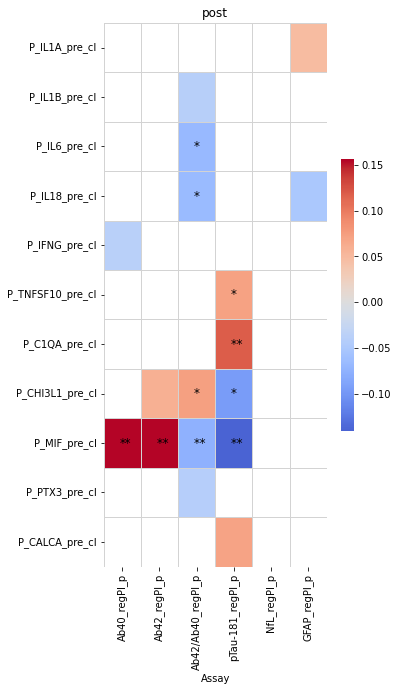

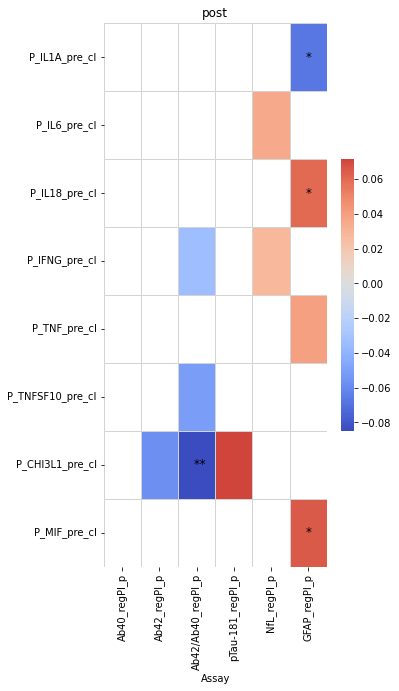

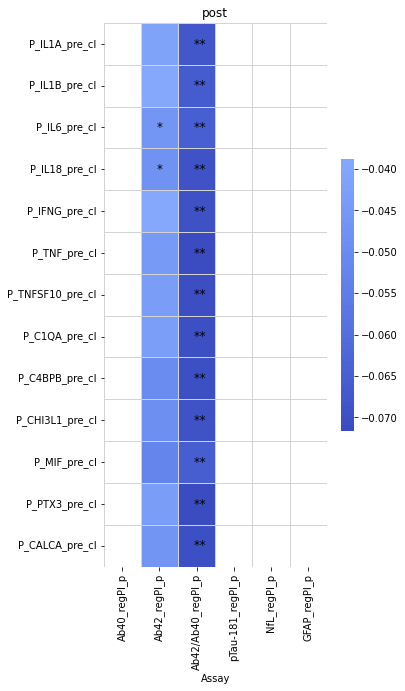

In [424]:
pp='post'
vars_show=vars['OLINK_pre']

for beta_name in ['','Case']:
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    (table,pvals,pvals_corr,sigs,betas,sdf)=model_table(outpts,[a + '_' + pp+'_cl' for a in assays],['int_simp_modpre'],vars_show,beta_name_add=beta_name,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')
    table=table.rename(columns=cols_translate)
    table=table.T.rename(columns=cols_translate).T
    table.T.style.format()

    rows=(pvals<0.2).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    #els=(pvals<0.05)
    #ccs_good_labels=ccs.index[rows]
    #ccs_good=ccs.values[rows]
    #ccs_good.shape
    mask=((pvals.T)[rows,:]>0.2).astype(bool)


    # Set the figure size
    plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


#     for i in np.arange(6):

#         for j in range(mask.shape[0]):
#             if sigs[:,rows][i,j] == 1:
#                 plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    # Set the x-axis and y-axis labels using cols_translate
    #plt.yticks(np.arange(mask.shape[0])+.5, ccs.index[rows], rotation=0)
    #plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()

#vars_show=vars['pre']
assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
(table,pvals,pvals_corr,sigs,betas,sdf)=model_table(outpts,[a + '_' + pp+'_cl' for a in assays],['conf_simp_modpre'],vars_show,beta_name_only='Case_bin',beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')
table=table.rename(columns=cols_translate)
print   (table.T.style.format())
table=table.T.rename(columns=cols_translate).T
table.T.style.format()
#     ccs=data.loc[all_matched,[a+'_pre_cl' for a in assays]+vars_show].corr().iloc[6:,:6]
#     ccs=ccs.rename(index=cols_translate)

rows=(pvals<0.2).sum(axis=0)>0
betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
betas_in=betas_in.iloc[:,rows].T
#els=(pvals<0.05)
#ccs_good_labels=ccs.index[rows]
#ccs_good=ccs.values[rows]
#ccs_good.shape
mask=((pvals.T)[rows,:]>0.2).astype(bool)


# Set the figure size
plt.figure(figsize=(5,10))

# Create the heatmap
sns.heatmap(betas_in, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

for i in range(6):
    for j in range(mask.shape[0]):
        if pvals[:,rows][i,j] <0.05:
            plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

for i in range(6):
    for j in range(mask.shape[0]):
        if sigs[:,rows][i,j] == 1:
            plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


#     for i in np.arange(6):

#         for j in range(mask.shape[0]):
#             if sigs[:,rows][i,j] == 1:
#                 plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

# Set the x-axis and y-axis labels using cols_translate
#plt.yticks(np.arange(mask.shape[0])+.5, ccs.index[rows], rotation=0)
#plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



# Set the title
plt.title(pp)

# Show the plot
plt.show()

In [ ]:
find_vars(data,'30680')
find_vars(data,'21104')
find_vars(data,'130778')
data['104670-0.0'].notna().sum()
calcium=['30680-0.0','']

251

In [425]:
# percent change calculations
IDPs=['Ab42/Ab40_regPl_pre_cl']


pc_stats=pd.DataFrame()

for IDP_base in [SIMOA_assays[2]]: 
    # pre-post change
    
    IDP=IDP_base+'_pre_cl'
    IDP_post=IDP_base+'_post_cl'
    els=all_matched
    els=all_case&(data.loc[:,IDP_pre].notnull())#&(data.loc[:,'Gender_pre']=='Female') #&(data['Diabetes']==False)&(data['BP_meds']==False)&(data['Heart_Cond']==False) #&(data.loc[:,'matched_age_mean']>60) #&elsA44 # & (data.loc[:,'COVID']=='COVID') #&(data.loc[:,'A4'].notna()) #(&&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
    ids=data.loc[els,'matched_eid'].dropna().values
    ids=data.loc[ids,IDP_pre].notnull().index
    ids2=data.loc[ids,'matched_eid'].values
    idels=(data.loc[ids,'KeyWorker'].values==data.loc[ids,'KeyWorker'].values)#  & (data.loc[ids,'Diabetes'].values==data.loc[ids2,'Diabetes'].values)&  (data.loc[ids,'Chol_meds'].values==data.loc[ids2,'Chol_meds'].values)  & (data.loc[ids,'BP_meds'].values==data.loc[ids2,'BP_meds'].values) # & (np.abs((data.loc[ids,'709-2.0'].values-data.loc[ids2,'709-2.0'].values))<2) #& 
    idels=(ids==ids)
    els[:]=False
    els[ids[idels]]=True
    els[ids2[idels]]=True 
  
    # calculate percentage effect for A34 vs A33
    A3A3_m=data.loc[els&(data['APOE']=='A3A3'),IDP].mean()
    A3A4_m=data.loc[els&(data['APOE']=='A3A4'),IDP].mean()
    A4A4_m=data.loc[els&(data['APOE']=='A4A4'),IDP].mean()
    print('A33-A34 basic: ' + str(100*(A3A4_m-A3A3_m)/A3A3_m))
    print('A33-A44 basic: ' + str(100*(A4A4_m-A3A3_m)/A3A3_m))
    for b in ['Diabetes','Smoking_bin-2.0','22001-0.0','31-0.0','BP_meds','Chol_meds','Obesity-2.0']:
        
        A=data.loc[els&(data[b]==True),IDP].mean()
        B=data.loc[els&(data[b]==False),IDP].mean()

        print(b+ ' basic: ' + str(100*(A-B)/B))
    for b in ['Case']:
        A=data.loc[els&(data[b]=='sars'),IDP].mean()
        B=data.loc[els&(data[b]=='ctr'),IDP].mean()  
        print(b+ 'pre basic: ' + str(100*(A-B)/B))
    for b in ['Case']:
        A=data.loc[els&(data[b]=='sars'),re.sub('pre','post',IDP)].mean()
        B=data.loc[els&(data[b]=='ctr'),re.sub('pre','post',IDP)].mean()  
        print(b+ 'post basic: ' + str(100*(A-B)/B))
        
    #a='APOE'
    #print('APOE - model: ' +str(100*(outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A3]"]-outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A4]"])/data.loc[els,IDP].mean()))
    #outpts_pre[IDP+'_'+a+'_simp'].params

    # calculate percentage change for A34 vs A33

    IDP='Ab42/Ab40_regPl_post_cl'
    # raw
    A3A3_m=data.loc[els&(data['Case']=='ctr'),IDP].mean()
    A3A4_m=data.loc[els&(data['Case']=='sars'),IDP].mean()
    
    print(100*(A3A3_m-A3A4_m)/A3A3_m)

    # model based
    
    
    print('Case_bin - model')
    print(outpts[IDP+'_simp_modpre'].pc)

    print('APOE model 2')
    IDP='Ab42/Ab40_regPl_pre_cl'
    a='APOE'
    #print(100*(outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A3]"]-outpts_pre[IDP+'_'+a+'_simp'].params["C(Q('APOE'))[T.A3A4]"])/data.loc[els,IDP].mean())
    #outpts_pre[IDP+'_'+a+'_simp'].params

    # pc by age
    # Calculate aging effect
    a='Age-2.0'
    print('Aging per year')
    print(outpts_pre[IDP+'_'+a+'_simp'].pc)


    # pc for Case/Control

  
    #print(outpts_pre['Ab42/Ab40_regPl_pre_cl_Case_bin_simp_modpre'].pc)
    #print(outpts['Ab42/Ab40_regPl_post_cl_ext_modpre'].pc)

A33-A34 basic: -3.667992561442906
A33-A44 basic: -12.188395827695311
Diabetes basic: -2.578203000346062
Smoking_bin-2.0 basic: -5.461931885594838
22001-0.0 basic: -2.02842771214232
31-0.0 basic: -2.067236057839684
BP_meds basic: -2.842279550218115
Chol_meds basic: -2.6065754652933975
Obesity-2.0 basic: -0.8622574173975649
Casepre basic: -2.3550571671181992
Casepost basic: -3.6968730350085446
3.6968730350085446
Case_bin - model
-2.074513645699812
APOE model 2
Aging per year
-0.5202841806922764


In [426]:
IDP='Ab42/Ab40_regPl_pre_cl'
# pc by age
# Calculate aging effect
a='Age-2.0'
print('Aging per year')
print(outpts_pre[IDP+'_'+a+'_simp'].pc)

Aging per year
-0.5202841806922764


In [427]:
b='22001-0.0'
A=data.loc[all_matched&(data[b]==True),IDP].mean()
B=data.loc[all_matched&(data[b]==False),IDP].mean()
print(A)
print(B)

0.074751815172912
0.07635971611445043


### Inflammation tables

In [440]:
outpts=calc_pre_post_models(data,all_matched,outpts, OLINK_assays_final,data_ins=['simp'],models=['modpre'],inter_vars= ['adni_mean_diff_cl','cog_vars_gi_diff_cl','GeneralHealth_diff_cl'] + ['vac_prior_first_pos'] + vars['pre_comorb'],a='post_cl',c='',ext='-3.0')


P_IL1A
P_IL1B
P_IL6
P_IL18
P_IFNG
P_TNF
P_TNFSF10
P_C1QA
P_C4BPB
P_CHI3L1
P_MIF
P_PTX3
P_CALCA


In [489]:
# change across sessions

table=model_table(outpts, vars['OLINK_post'],['_simp_modpre'],['Case_bin','Age-3.0','22001-0.0','assessment_sep'],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1],FPR='col',alpha=0.05,rem_txt=9)
table=table.rename(columns=cols_translate)
table.index=[a[2:-8] for a in vars['OLINK_post']]
table.style.format()
tables['inflam_change_basic']=table
table.to_excel('tables/inflam_change_basic.xlsx')
table

,n,Case/Control status,Age (pandemic),Genetic Sex,Assessment Interval (d)
IL1A,452,-0.0591 (p=0.202),-0.0048 (p=0.921),-0.0271 (p=0.564),-0.5046 (p=0.072)
IL1B,466,-0.0807 (p=0.081),-0.0480 (p=0.314),-0.0104 (p=0.826),-0.4275 (p=0.134)
IL6,485,0.0119 (p=0.752),0.0828 (p=0.038*),0.0086 (p=0.821),0.4223 (p=0.064)
IL18,507,-0.0155 (p=0.628),-0.0104 (p=0.750),0.1726 (p=3.3e-07**),0.2255 (p=0.256)
IFNG,470,-0.0676 (p=0.127),0.0219 (p=0.634),-0.0770 (p=0.088),-0.0678 (p=0.801)
TNF,470,-0.0167 (p=0.699),0.0539 (p=0.230),-0.0004 (p=0.993),-0.1501 (p=0.563)
TNFSF10,521,-0.1055 (p=0.002**),-0.0822 (p=0.019*),-0.0263 (p=0.448),0.2927 (p=0.165)
C1QA,521,-0.0220 (p=0.449),0.0609 (p=0.043*),0.0229 (p=0.436),0.1424 (p=0.427)
C4BPB,501,-0.0035 (p=0.915),-0.0637 (p=0.060),-0.1451 (p=2.2e-05**),0.0681 (p=0.741)
CHI3L1,526,0.0352 (p=0.277),0.1430 (p=3.2e-05**),0.0416 (p=0.203),0.3763 (p=0.054)


In [442]:
# change across sessions hosp

table=model_table(outpts, vars['OLINK_post'],['_simp_modpre_hosp_only'],['Case_nohosp','Case_hosp','Age-3.0','22001-0.0','assessment_sep','pre'],beta_dirs=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1],FPR='col',alpha=0.05,rem_txt=9)
table=table.rename(columns=cols_translate)
table.index=[a[2:-8] for a in vars['OLINK_post']]
table.style.format()
tables['inflam_change_basic']=table
table.to_excel('tables/inflam_change_basic_hosp.xlsx')
table

,n,Case_nohosp,Case_hosp,Age (pandemic),Genetic Sex,Assessment Interval (d),Baseline protein
IL1A,452,-0.0612 (p=0.187),0.0019 (p=0.967),-0.0049 (p=0.919),-0.0271 (p=0.565),-0.5081 (p=0.071),0.0890 (p=0.059)
IL1B,466,-0.0743 (p=0.109),-0.0368 (p=0.427),-0.0479 (p=0.316),-0.0103 (p=0.827),-0.4223 (p=0.139),0.0406 (p=0.408)
IL6,485,-0.0098 (p=0.794),0.0963 (p=0.010*),0.0823 (p=0.038*),0.0086 (p=0.820),0.4007 (p=0.078),0.5404 (p=5.9e-37**)
IL18,507,-0.0165 (p=0.607),0.0025 (p=0.937),-0.0105 (p=0.749),0.1727 (p=3.4e-07**),0.2244 (p=0.259),0.6413 (p=3.0e-62**)
IFNG,470,-0.0672 (p=0.130),-0.0094 (p=0.833),0.0219 (p=0.635),-0.0770 (p=0.089),-0.0692 (p=0.798),0.2778 (p=1.3e-09**)
TNF,470,-0.0213 (p=0.623),0.0189 (p=0.662),0.0539 (p=0.230),-0.0004 (p=0.993),-0.1549 (p=0.551),0.3237 (p=1.3e-12**)
TNFSF10,521,-0.1025 (p=0.003**),-0.0249 (p=0.469),-0.0822 (p=0.020*),-0.0263 (p=0.448),0.2930 (p=0.165),0.6192 (p=6.5e-56**)
C1QA,521,-0.0236 (p=0.417),0.0044 (p=0.879),0.0609 (p=0.044*),0.0229 (p=0.436),0.1408 (p=0.433),0.7384 (p=4.6e-91**)
C4BPB,501,-0.0076 (p=0.819),0.0169 (p=0.609),-0.0638 (p=0.059),-0.1451 (p=2.3e-05**),0.0650 (p=0.752),0.6470 (p=6.9e-61**)
CHI3L1,526,0.0293 (p=0.365),0.0298 (p=0.355),0.1429 (p=3.3e-05**),0.0416 (p=0.203),0.3727 (p=0.056),0.6165 (p=2.7e-57**)


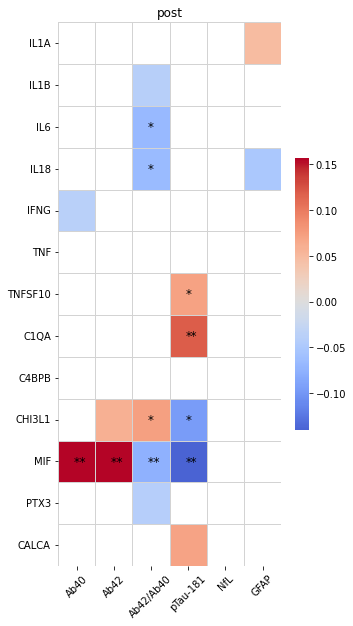

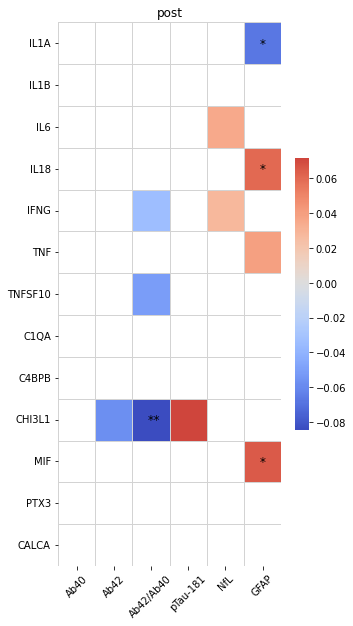

In [443]:
pp='post'
vars_show= vars['OLINK_pre']

for beta_name in ['','Case']:
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    (table,pvals,pvals_corr,sigs,betas,sdf)=model_table(outpts,[a + '_' + pp+'_cl' for a in assays],['int_simp_modpre'],vars_show,beta_name_add=beta_name,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table=table.T.rename(columns=cols_translate).T
    table=table.rename(columns={a:a[2:-7] for a in vars['OLINK_pre']})
    table.index=[a[:-6] for a in assays]
    tables['pre_int_OLINK_'+beta_name]=table.T
    table.T.to_excel('tables/pre_int_OLINK_'+beta_name+'.xlsx')
    
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    #els=(pvals<0.05)
    #ccs_good_labels=ccs.index[rows]
    #ccs_good=ccs.values[rows]
    #ccs_good.shape
    mask=((pvals.T)[rows,:]>0.2).astype(bool)


    # Set the figure size
    plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


#     for i in np.arange(6):

#         for j in range(mask.shape[0]):
#             if sigs[:,rows][i,j] == 1:
#                 plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()


In [444]:
# Prior Inflammatory levels effects on cases and control.
beta_name=''
tables['pre_int_OLINK_'+beta_name]

,Ab40,Ab42,Ab42/Ab40,pTau-181,NfL,GFAP
n,820,818,809,788,782,782
IL1A,0.0225 (p=0.700),0.0440 (p=0.867),0.0325 (p=0.834),0.0358 (p=0.202),0.0137 (p=0.335),0.0485 (p=0.109)
IL1B,0.0747 (p=0.954),0.1063 (p=0.996),-0.0401 (p=0.122),-0.1026 (p=0.990),0.0256 (p=0.212),-0.0038 (p=0.901)
IL6,0.0624 (p=0.933),-0.0037 (p=0.462),-0.0682 (p=0.019*),-0.0760 (p=0.963),-0.0771 (p=0.994),-0.0144 (p=0.626)
IL18,0.0666 (p=0.941),0.0241 (p=0.729),-0.0664 (p=0.023*),-0.0489 (p=0.872),-0.0278 (p=0.812),-0.0505 (p=0.092)
IFNG,-0.0382 (p=0.189),-0.0230 (p=0.282),-0.0093 (p=0.392),0.0095 (p=0.414),-0.0158 (p=0.687),-0.0024 (p=0.937)
TNF,0.0110 (p=0.604),0.0342 (p=0.813),0.0154 (p=0.682),0.0304 (p=0.234),-0.0097 (p=0.624),-0.0230 (p=0.438)
TNFSF10,-0.0258 (p=0.262),0.0082 (p=0.587),0.0624 (p=0.975),0.0711 (p=0.040*),0.0014 (p=0.482),0.0121 (p=0.673)
C1QA,-0.0316 (p=0.457),-0.0450 (p=0.251),0.0121 (p=0.716),0.1186 (p=0.005**),0.0046 (p=0.883),0.0041 (p=0.891)
C4BPB,0.0250 (p=0.541),0.0370 (p=0.327),0.0135 (p=0.674),-0.0280 (p=0.503),0.0267 (p=0.382),0.0052 (p=0.860)


In [445]:
# Prior Inflammatory levels effects on cases and control.
beta_name='Case'

tables['pre_int_OLINK_'+beta_name]

,Ab40,Ab42,Ab42/Ab40,pTau-181,NfL,GFAP
n,820,818,809,788,782,782
IL1A,0.0068 (p=0.564),0.0246 (p=0.734),0.0284 (p=0.802),-0.0762 (p=0.962),-0.0031 (p=0.538),-0.0673 (p=0.026*)
IL1B,0.0183 (p=0.668),-0.0034 (p=0.465),0.0029 (p=0.535),0.0101 (p=0.406),-0.0059 (p=0.575),0.0216 (p=0.461)
IL6,-0.0145 (p=0.361),-0.0300 (p=0.214),-0.0133 (p=0.340),0.0297 (p=0.238),0.0354 (p=0.121),-0.0162 (p=0.575)
IL18,0.0361 (p=0.807),0.0410 (p=0.857),0.0043 (p=0.553),0.0182 (p=0.332),0.0138 (p=0.325),0.0600 (p=0.040*)
IFNG,0.0320 (p=0.771),0.0001 (p=0.501),-0.0336 (p=0.159),0.0021 (p=0.481),0.0277 (p=0.196),0.0304 (p=0.321)
TNF,0.0602 (p=0.928),0.0488 (p=0.899),0.0066 (p=0.581),-0.0297 (p=0.764),-0.0063 (p=0.582),0.0392 (p=0.182)
TNFSF10,0.0321 (p=0.787),0.0044 (p=0.547),-0.0511 (p=0.055),-0.1327 (p=0.999),0.0016 (p=0.479),-0.0321 (p=0.263)
C1QA,-0.0005 (p=0.991),0.0079 (p=0.840),0.0009 (p=0.977),-0.0313 (p=0.460),0.0033 (p=0.916),0.0124 (p=0.680)
C4BPB,0.0073 (p=0.857),-0.0040 (p=0.915),-0.0022 (p=0.944),-0.0239 (p=0.562),-0.0153 (p=0.612),0.0134 (p=0.645)


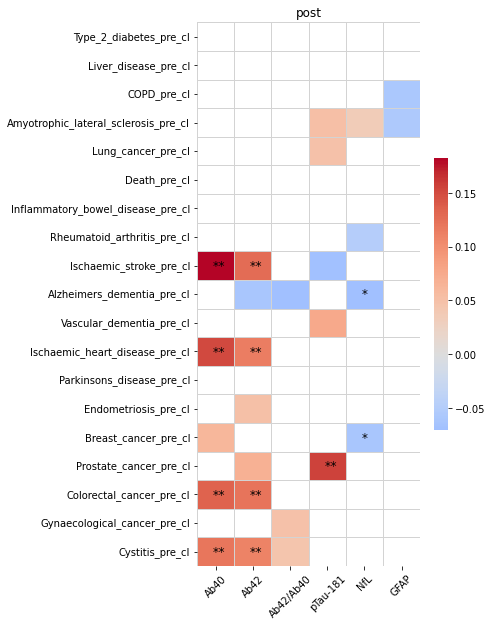

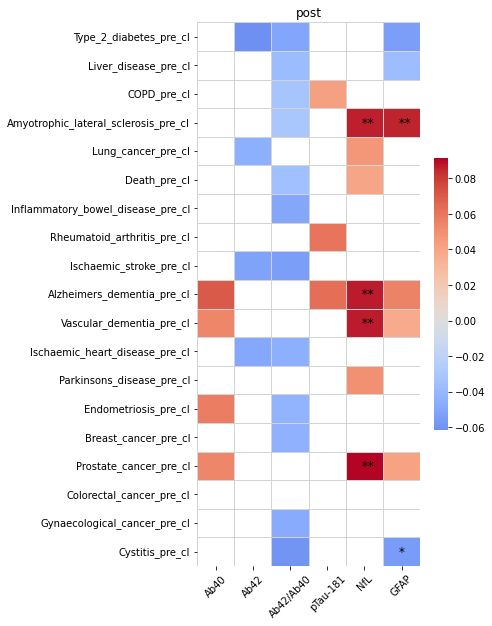

In [446]:
pp='post'
vars_show= vars['diseases_pre']

for beta_name in ['','Case']:
    assays =  SIMOA_assays # ['Ab40_regPl', 'Ab42_regPl', 'Ab42/Ab40_regPl', 'pTau-181_regPl', 'NfL_regPl', 'GFAP_regPl']# + ['P_TREM2','P_AXL','P_TYRO3','P_MIF','P_C1QA', 'P_C4BPB','P_IL6','P_IL18']
    (table,pvals,pvals_corr,sigs,betas,sdf)=model_table(outpts,[a + '_' + pp+'_cl' for a in assays],['int_simp_modpre'],vars_show,beta_name_add=beta_name,beta_dirs=[-1,-1,-1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=True,FPR='col')

    table=table.rename(columns=cols_translate)
    table=table.T.rename(columns=cols_translate).T
    table=table.rename(columns={a:a[2:-7] for a in vars['OLINK_pre']})
    table.index=[a[:-6] for a in assays]
    tables['pre_int_diseases_'+beta_name]=table.T
    table.T.to_excel('tables/pre_int_diseases_'+beta_name+'.xlsx')
    
    rows=(pvals<1).sum(axis=0)>0
    betas_in=pd.DataFrame(betas,index=table.index,columns=table.columns[1:])
    betas_in=betas_in.iloc[:,rows].T
    #els=(pvals<0.05)
    #ccs_good_labels=ccs.index[rows]
    #ccs_good=ccs.values[rows]
    #ccs_good.shape
    mask=((pvals.T)[rows,:]>0.2).astype(bool)


    # Set the figure size
    plt.figure(figsize=(5,10))

    # Create the heatmap
    sns.heatmap(betas_in, annot=False, fmt=".2f", mask=mask, cmap="coolwarm",  linewidths=0.5, linecolor='lightgrey', cbar=True,  cbar_kws={"shrink": 0.5},center=0)

    for i in range(6):
        for j in range(mask.shape[0]):
            if pvals[:,rows][i,j] <0.05:
                plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    for i in range(6):
        for j in range(mask.shape[0]):
            if sigs[:,rows][i,j] == 1:
                plt.text(i + 0.5, j + 0.5, "   *", ha='center', va='center', color='black', fontsize=12)


#     for i in np.arange(6):

#         for j in range(mask.shape[0]):
#             if sigs[:,rows][i,j] == 1:
#                 plt.text(i + 0.5, j + 0.5, "*", ha='center', va='center', color='black', fontsize=12)

    # Set the x-axis and y-axis labels using cols_translate
    plt.yticks(np.arange(mask.shape[0])+.5, betas_in.index[rows], rotation=0)
    plt.xticks(np.arange(len(assays))+0.5,[a[:-6] for a in assays],rotation=45)



    # Set the title
    plt.title(pp)

    # Show the plot
    plt.show()



### Extended Model results


In [447]:
outpts=calc_pre_post_models(data,all_matched,outpts, SIMOA_assays,data_ins=['simp'],models=['modpre_ext'],inter_vars= [],a='post_cl',c='',ext='-3.0')


Ab40_regPl
Ab42_regPl
Ab42/Ab40_regPl
pTau-181_regPl
NfL_regPl
GFAP_regPl


In [448]:
outpts['pTau-181_regPl_post_cl_simp_modpre_ext'].pvalues

Intercept                     2.043901e-03
C(KeyWorker)[T.True]          3.492982e-01
Q('pTau-181_regPl_pre_cl')    1.130566e-59
Q('Age-3.0')                  1.243828e-10
Q('22001-0.0')                8.189514e-03
Q('assessment_sep')           1.400280e-01
Q('assessment_sep^2')         1.375971e-01
Q('21002-2.0')                3.965163e-01
Q('Activity-2.0')             5.407816e-01
Q('709-3.0')                  1.866968e-01
Case_bin                      5.125150e-01
dtype: float64

In [449]:
# percentage change with Case
IDP='Ab42/Ab40_regPl_post_cl'
a='Case_bin'
case="Q('" + a + "')"
print('PC for simple model: ' + str(outpts[IDP+'_simp_modpre'].pc))
#print(outpts_pre[IDP+'_'+a+'_simp'].pvalues)
print('PC for ext model: ' + str(outpts[IDP+'_simp_modpre_ext'].pc))
#print(outpts_pre[IDP+'_simp'].pvalues)

PC for simple model: -2.074513645699812
PC for ext model: -1.8816784578694374


In [450]:
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_ext'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre','21002-2.0','Activity-2.0','709-3.0','KeyWorker'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/ext_model.xlsx')
table.style.format()

,n,Case/Control status,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein,Weight,Moderate activity (min/d),Number in Household,KeyWorker
Assay,,,,,,,,,,,
Aβ40,1050,0.0229 (p=0.187),-0.0665 (p=0.028*),0.1660 (p=1.5e-08**),-0.0140 (p=0.926),0.0666 (p=0.659),0.5031 (p=4.6e-70**),0.0626 (p=0.018*),0.0081 (p=0.376),-0.0162 (p=0.722),-0.0172 (p=0.747)
Aβ42,1056,-0.0236 (p=0.168),-0.0444 (p=0.123),0.0372 (p=0.166),0.0902 (p=0.532),-0.0442 (p=0.759),0.6162 (p=8.7e-111**),0.0393 (p=0.916),-0.0074 (p=0.381),-0.0106 (p=0.342),-0.0168 (p=0.247)
Aβ42/Aβ40,1038,-0.0556 (p=0.004**),0.0080 (p=0.741),-0.0408 (p=0.077),0.1460 (p=0.225),-0.1529 (p=0.203),0.7399 (p=8.3e-179**),-0.0139 (p=0.281),-0.0079 (p=0.351),0.0183 (p=0.798),-0.0031 (p=0.440)
pTau-181,1040,-0.0172 (p=0.744),0.0828 (p=0.008**),0.1893 (p=1.2e-10**),0.2277 (p=0.140),-0.2289 (p=0.138),0.4729 (p=1.1e-59**),-0.0259 (p=0.802),-0.0160 (p=0.730),0.0369 (p=0.093),0.0246 (p=0.175)
NfL,1058,-0.0071 (p=0.651),-0.0012 (p=0.955),0.1315 (p=6.7e-09**),0.1782 (p=0.096),-0.1120 (p=0.294),0.7348 (p=4.9e-172**),-0.0497 (p=0.989),-0.0174 (p=0.830),-0.0163 (p=0.799),0.0381 (p=0.018*)
GFAP,1061,0.0002 (p=0.496),-0.0465 (p=0.023*),0.1469 (p=3.8e-12**),0.1106 (p=0.277),-0.1038 (p=0.306),0.7440 (p=1.7e-198**),-0.0472 (p=0.990),0.0056 (p=0.373),-0.0001 (p=0.501),0.0103 (p=0.276)


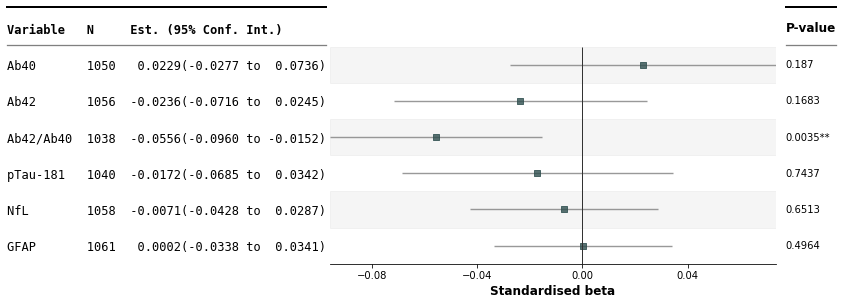

In [451]:
ff=fp.forestplot(resultstable_ext['Case_bin'],  # the dataframe with results data
              estimate="betas_norm",  # col containing estimated effect size 
              ll="ci_l_norm", hl="ci_u_norm",  # columns containing conf. int. lower and higher limits
              varlabel="Assay",  # column containing variable label
              thresholds=[0.0001,0.02,0.05],
              symbols=['***','**','*'],
              decimal_precision=4,
              pval='pvals',
              annote=["n", "est_ci"],
              annoteheaders=["N", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              #ylabel="Confidence interval",  # y-label title
              xlabel="Standardised beta",  # x-label title
              table=True,
              color_alt_rows=True,figsize=(8,4.5),kwargs={"xlinecolor": ".5"})
offset=0.3
ff.set_ylim((ff.get_ylim()[0], ff.get_ylim()[1]+offset))

fig=plt.gcf()
fig.savefig('ext_fig.svg', format="svg",dpi=300, bbox_inches = "tight")

In [452]:
(table,pvals,pvals_corr,sigs,betas,resultstable_f)=model_table(outpts,assays_regPl[:6],['_post_cl_age_f_simp_modpre_ext'],['Case_bin','Age-3.0','Case_bin:','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre','21002-2.0','Activity-2.0','709-3.0','KeyWorker'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age-Related Vulnerability'})
table=table.rename(columns={'Case_bin:':'Age-Related Vulnerability: Case/Control status'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/ext_model_age_f.xlsx')
table.style.format()

,n,Case/Control status,Age-Related Vulnerability,ARV : Case/Control status,Genetic Sex,Assessment Interval (d),Assessment Interval^2,Baseline protein,Weight,Moderate activity (min/d),Number in Household,KeyWorker
Assay,,,,,,,,,,,,
Aβ40,1050,0.0643 (p=0.037*),0.2028 (p=6.2e-08**),-0.0684 (p=0.114),-0.0687 (p=0.024*),0.0087 (p=0.954),0.0430 (p=0.388),0.5005 (p=4.1e-69**),0.0626 (p=0.018*),0.0063 (p=0.403),-0.0314 (p=0.879),-0.0240 (p=0.825)
Aβ42,1056,0.0333 (p=0.835),0.0854 (p=0.014*),-0.0967 (p=0.019*),-0.0439 (p=0.127),0.0897 (p=0.535),-0.0440 (p=0.380),0.6166 (p=1.000),0.0390 (p=0.915),-0.0069 (p=0.389),-0.0174 (p=0.247),-0.0210 (p=0.195)
Aβ42/Aβ40,1038,-0.0485 (p=0.046*),-0.0439 (p=0.137),-0.0126 (p=0.716),0.0106 (p=0.661),0.1324 (p=0.272),-0.1401 (p=0.122),0.7379 (p=1.000),-0.0149 (p=0.265),-0.0069 (p=0.368),0.0188 (p=0.811),-0.0031 (p=0.440)
pTau-181,1040,-0.0818 (p=0.987),0.1241 (p=9.4e-04**),0.1143 (p=0.009**),0.0813 (p=0.009**),0.2539 (p=0.099),-0.2573 (p=0.953),0.4739 (p=9.6e-61**),-0.0268 (p=0.811),-0.0189 (p=0.766),0.0246 (p=0.182),0.0218 (p=0.201)
NfL,1058,-0.0262 (p=0.847),0.0878 (p=0.001**),0.0365 (p=0.235),-0.0005 (p=0.980),0.1891 (p=0.079),-0.1253 (p=0.878),0.7498 (p=1.5e-183**),-0.0485 (p=0.987),-0.0188 (p=0.848),-0.0297 (p=0.941),0.0341 (p=0.031*)
GFAP,1061,-0.0019 (p=0.531),0.1123 (p=1.6e-05**),0.0074 (p=0.800),-0.0418 (p=0.042*),0.1163 (p=0.257),-0.1134 (p=0.866),0.7594 (p=2.2e-207**),-0.0478 (p=0.990),0.0047 (p=0.393),-0.0174 (p=0.833),0.0046 (p=0.395)


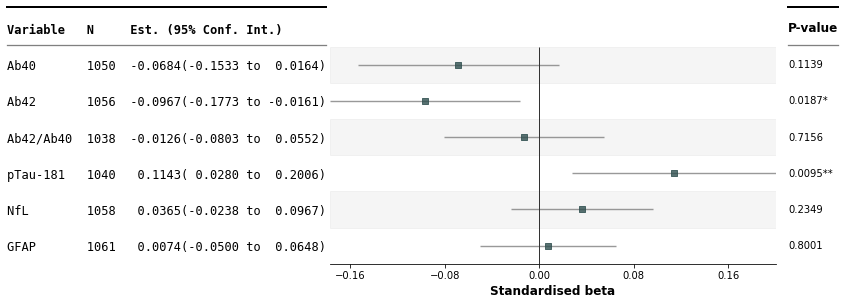

In [453]:
ff=fp.forestplot(resultstable_f['Case_bin:'],  # the dataframe with results data
              estimate="betas_norm",  # col containing estimated effect size 
              ll="ci_l_norm", hl="ci_u_norm",  # columns containing conf. int. lower and higher limits
              varlabel="Assay",  # column containing variable label
              thresholds=[0.0001,.015,0.05],
              decimal_precision=4,
              symbols=['***','**','*'],
              pval='pvals',
              annote=["n", "est_ci"],
              annoteheaders=["N", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              #ylabel="Confidence interval",  # y-label title
              xlabel="Standardised beta",  # x-label title
              table=True,
              color_alt_rows=True,figsize=(8,4.5),kwargs={"xlinecolor": ".5"})
offset=0.3
ff.set_ylim((ff.get_ylim()[0], ff.get_ylim()[1]+offset))

fig=plt.gcf()
fig.savefig('age_f_ext_fig.svg', format="svg",dpi=300, bbox_inches = "tight")

### APOE model results

In [454]:

outpts=calc_pre_post_models(data,all_matched,outpts, SIMOA_assays,data_ins=['simp'],models=['modpre_APOE'],inter_vars= [],a='post_cl',c='',ext='-3.0')


Ab40_regPl
Ab42_regPl
Ab42/Ab40_regPl
pTau-181_regPl
NfL_regPl
GFAP_regPl


In [455]:

model='_simp_modpre_APOE'
age_f=''
vars_show=['Case_bin','Age-3.0','22001-0.0','assessment_sep','A33vA34','A33vA44','A33vA32','Smok']

#model='modpre'
#outpts[IDP+age_f+data_in + '_' + model].pvalues/2
(table,pvals,pvals_corr,sigs,betas,resultst)=model_table(outpts,[a + '_post_cl' for a in assays],[model],vars_show,beta_dirs=[-1,-1,-1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],returndata=True,diff_models=False,FPR='col')
table=table.rename(columns=cols_translate)
table=table.T.rename(columns=cols_translate).T
table.to_excel('tables/basic_APOE.xlsx')
table.style.format()

,n,Case/Control status,Age (pandemic),Genetic Sex,Assessment Interval (d),A33vA34,A33vA44,A33vA32,Smok
Assay,,,,,,,,,
Ab40_regPl_p,1164,0.0195 (p=0.790),0.1582 (p=1.000),-0.0481 (p=0.077),-0.0077 (p=0.478),-0.0046 (p=0.427),0.0135 (p=0.711),-0.0038 (p=0.439),-0.0014 (p=0.955)
Ab42_regPl_p,1171,-0.0397 (p=0.041*),0.0320 (p=0.910),-0.0334 (p=0.147),0.0300 (p=0.588),-0.0300 (p=0.101),-0.0264 (p=0.125),0.0251 (p=0.857),-0.0082 (p=0.719)
Ab42/Ab40_regPl_p,1150,-0.0642 (p=4.4e-04**),-0.0482 (p=0.010**),0.0076 (p=0.612),0.0874 (p=0.779),-0.0240 (p=0.113),-0.0322 (p=0.048*),0.0213 (p=0.859),0.0083 (p=0.668)
pTau-181_regPl_p,1148,-0.0055 (p=0.588),0.1516 (p=5.6e-09**),0.1301 (p=1.1e-04**),0.3302 (p=0.012*),-0.0120 (p=0.681),0.0360 (p=0.074),0.0033 (p=0.449),0.0134 (p=0.590)
NfL_regPl_p,1172,-0.0103 (p=0.722),0.1229 (p=4.9e-09**),0.0027 (p=0.456),0.2107 (p=0.022*),0.0132 (p=0.234),0.0268 (p=0.065),-0.0179 (p=0.840),0.0281 (p=0.111)
GFAP_regPl_p,1176,-0.0023 (p=0.556),0.1404 (p=3.1e-13**),-0.0456 (p=0.975),0.1855 (p=0.030*),0.0301 (p=0.040*),-0.0022 (p=0.553),-0.0361 (p=0.982),0.0251 (p=0.134)


In [456]:
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_APOE'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre','A34','A44','A32','Smoking','Diabetes','Hip/Waist'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/APOE_model.xlsx')
table.style.format()

,n,Case/Control status,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein,APOE-e3e4,APOE-e4e4,APOE-e3e2,Smoking,Diabetes,Hip/Waist
Assay,,,,,,,,,,,,,
Aβ40,1164,0.0195 (p=0.210),-0.0481 (p=0.155),0.1582 (p=1.4e-09**),-0.0077 (p=0.957),0.0602 (p=0.674),0.5008 (p=2.0e-77**),-0.0046 (p=0.573),0.0135 (p=0.289),-0.0038 (p=0.561),-0.0014 (p=0.523),0.0773 (p=8.9e-04**),-0.0128 (p=0.642)
Aβ42,1171,-0.0397 (p=0.041*),-0.0334 (p=0.295),0.0320 (p=0.180),0.0300 (p=0.825),0.0107 (p=0.937),0.6180 (p=8.7e-125**),-0.0300 (p=0.101),-0.0264 (p=0.125),0.0251 (p=0.857),-0.0082 (p=0.359),0.0288 (p=0.892),0.0066 (p=0.579)
Aβ42/Aβ40,1150,-0.0642 (p=4.4e-04**),0.0076 (p=0.777),-0.0482 (p=0.020*),0.0874 (p=0.442),-0.1002 (p=0.377),0.7334 (p=3.6e-195**),-0.0240 (p=0.113),-0.0322 (p=0.048*),0.0213 (p=0.859),0.0083 (p=0.666),-0.0449 (p=0.011**),0.0156 (p=0.711)
pTau-181,1148,-0.0055 (p=0.588),0.1301 (p=2.1e-04**),0.1516 (p=1.1e-08**),0.3302 (p=0.025*),-0.3361 (p=0.022*),0.4720 (p=1.6e-64**),-0.0120 (p=0.681),0.0360 (p=0.074),0.0033 (p=0.449),0.0134 (p=0.295),-0.0338 (p=0.909),0.0504 (p=0.082)
NfL,1172,-0.0103 (p=0.722),0.0027 (p=0.911),0.1229 (p=9.8e-09**),0.2107 (p=0.044*),-0.1547 (p=0.137),0.7345 (p=5.4e-188**),0.0132 (p=0.234),0.0268 (p=0.065),-0.0179 (p=0.840),0.0281 (p=0.056),0.0395 (p=0.014*),0.0427 (p=0.050*)
GFAP,1176,-0.0023 (p=0.556),-0.0456 (p=0.050),0.1404 (p=6.2e-13**),0.1855 (p=0.061),-0.1882 (p=0.057),0.7459 (p=7.8e-220**),0.0301 (p=0.040*),-0.0022 (p=0.553),-0.0361 (p=0.982),0.0251 (p=0.067),0.0101 (p=0.276),0.0219 (p=0.183)


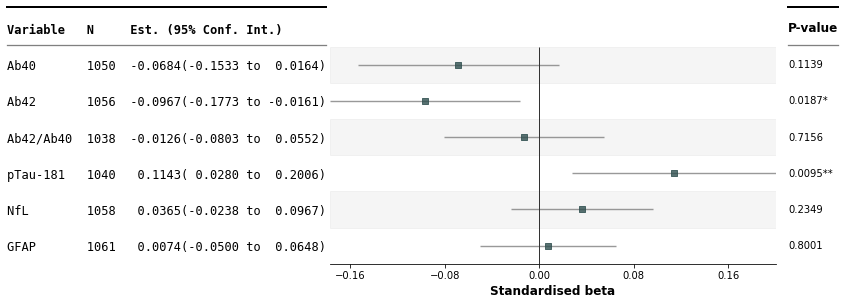

In [457]:
ff=fp.forestplot(resultstable_f["Case_bin:"],  # the dataframe with results data
              estimate="betas_norm",  # col containing estimated effect size 
              ll="ci_l_norm", hl="ci_u_norm",  # columns containing conf. int. lower and higher limits
              varlabel="Assay",  # column containing variable label
              thresholds=[0.0001,.015,0.05],
              decimal_precision=4,
              symbols=['***','**','*'],
              pval='pvals',
              annote=["n", "est_ci"],
              annoteheaders=["N", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              #ylabel="Confidence interval",  # y-label title
              xlabel="Standardised beta",  # x-label title
              table=True,
              color_alt_rows=True,figsize=(8,4.5),kwargs={"xlinecolor": ".5"})
offset=0.3
ff.set_ylim((ff.get_ylim()[0], ff.get_ylim()[1]+offset))
plt.show()

In [458]:
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_age_f_simp_modpre_APOE'],['Case_bin','Age-3.0','Case_bin:','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre','A34','A44','A32','Smoking','Diabetes','Hip/Waist','GeneralHealth-2.0'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,1,0,0,0,0,0,0,0,0,0,0,0,0],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(columns={'Age (pandemic)':'Age-Related Vulnerability'})
table=table.rename(columns={'Case_bin:':'Age-Related Vulnerability: Case/Control status'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/APOE_model_age_f.xlsx')
table.style.format()

,n,Case/Control status,Age (y),ARV : Case/Control status,Genetic Sex,Assessment Interval (d),Assessment Interval^2,Baseline protein,APOE-e3e4,APOE-e4e4,APOE-e3e2,Smoking,Diabetes,Hip/Waist,Health self-rating
Assay,,,,,,,,,,,,,,,
Aβ40,1164,0.0460 (p=0.087),0.1865 (p=1.7e-07**),-0.0466 (p=0.867),-0.0593 (p=0.079),0.0200 (p=0.889),0.0320 (p=0.823),0.4975 (p=6.9e-76**),-0.0063 (p=0.800),0.0164 (p=0.500),-0.0079 (p=0.753),-0.0014 (p=0.953),0.0758 (p=0.002**),-0.0244 (p=0.484),-0.0418 (p=0.094)
Aβ42,1171,0.0025 (p=0.531),0.0743 (p=0.025*),-0.0742 (p=0.030*),-0.0360 (p=0.257),0.0360 (p=0.791),0.0046 (p=0.973),0.6178 (p=1.3e-124**),-0.0309 (p=0.189),-0.0255 (p=0.267),0.0223 (p=0.343),-0.0094 (p=0.682),0.0261 (p=0.262),0.0032 (p=0.922),-0.0158 (p=0.502)
Aβ42/Aβ40,1150,-0.0541 (p=0.023*),-0.0405 (p=0.150),-0.0178 (p=0.296),0.0106 (p=0.694),0.0780 (p=0.494),-0.0908 (p=0.424),0.7333 (p=7.5e-196**),-0.0238 (p=0.230),-0.0327 (p=0.091),0.0216 (p=0.277),0.0077 (p=0.688),-0.0455 (p=0.021*),0.0180 (p=0.517),0.0026 (p=0.898)
pTau-181,1148,-0.0521 (p=0.934),0.1146 (p=0.001**),0.0817 (p=0.028*),0.1222 (p=4.7e-04**),0.3558 (p=0.015**),-0.3613 (p=0.014**),0.4711 (p=5.7e-65**),-0.0122 (p=0.631),0.0376 (p=0.130),0.0035 (p=0.891),0.0155 (p=0.533),-0.0324 (p=0.198),0.0448 (p=0.211),0.0650 (p=0.011**)
NfL,1172,-0.0320 (p=0.903),0.0847 (p=0.002**),0.0393 (p=0.098),-0.0057 (p=0.818),0.2266 (p=0.031*),-0.1713 (p=0.101),0.7479 (p=1.2e-201**),0.0131 (p=0.472),0.0282 (p=0.112),-0.0189 (p=0.298),0.0287 (p=0.104),0.0408 (p=0.024*),0.0316 (p=0.217),0.0254 (p=0.162)
GFAP,1176,-0.0012 (p=0.520),0.1165 (p=5.6e-06**),-0.0012 (p=0.516),-0.0528 (p=0.025*),0.1970 (p=0.048*),-0.2024 (p=0.042*),0.7598 (p=3.4e-228**),0.0290 (p=0.093),-0.0006 (p=0.973),-0.0377 (p=0.030*),0.0263 (p=0.119),0.0112 (p=0.514),0.0086 (p=0.722),0.0359 (p=0.038*)


In [459]:
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_age_f_simp_modpre_APOE'],['Case_bin','Age-3.0','Case_bin:','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre','A34','A44','A32','Smoking','Diabetes','Hip/Waist','GeneralHealth-2.0'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,1,0,0,0,0,0,0,0,0,0,0,0,0],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(columns={'Age (pandemic)':'Age-Related Vulnerability'})
table=table.rename(columns={'Case_bin:':'Age-Related Vulnerability: Case/Control status'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/APOE_model_age_f.xlsx')
table.style.format()

,n,Case/Control status,Age (y),ARV : Case/Control status,Genetic Sex,Assessment Interval (d),Assessment Interval^2,Baseline protein,APOE-e3e4,APOE-e4e4,APOE-e3e2,Smoking,Diabetes,Hip/Waist,Health self-rating
Assay,,,,,,,,,,,,,,,
Aβ40,1164,0.0460 (p=0.087),0.1865 (p=1.7e-07**),-0.0466 (p=0.867),-0.0593 (p=0.079),0.0200 (p=0.889),0.0320 (p=0.823),0.4975 (p=6.9e-76**),-0.0063 (p=0.800),0.0164 (p=0.500),-0.0079 (p=0.753),-0.0014 (p=0.953),0.0758 (p=0.002**),-0.0244 (p=0.484),-0.0418 (p=0.094)
Aβ42,1171,0.0025 (p=0.531),0.0743 (p=0.025*),-0.0742 (p=0.030*),-0.0360 (p=0.257),0.0360 (p=0.791),0.0046 (p=0.973),0.6178 (p=1.3e-124**),-0.0309 (p=0.189),-0.0255 (p=0.267),0.0223 (p=0.343),-0.0094 (p=0.682),0.0261 (p=0.262),0.0032 (p=0.922),-0.0158 (p=0.502)
Aβ42/Aβ40,1150,-0.0541 (p=0.023*),-0.0405 (p=0.150),-0.0178 (p=0.296),0.0106 (p=0.694),0.0780 (p=0.494),-0.0908 (p=0.424),0.7333 (p=7.5e-196**),-0.0238 (p=0.230),-0.0327 (p=0.091),0.0216 (p=0.277),0.0077 (p=0.688),-0.0455 (p=0.021*),0.0180 (p=0.517),0.0026 (p=0.898)
pTau-181,1148,-0.0521 (p=0.934),0.1146 (p=0.001**),0.0817 (p=0.028*),0.1222 (p=4.7e-04**),0.3558 (p=0.015**),-0.3613 (p=0.014**),0.4711 (p=5.7e-65**),-0.0122 (p=0.631),0.0376 (p=0.130),0.0035 (p=0.891),0.0155 (p=0.533),-0.0324 (p=0.198),0.0448 (p=0.211),0.0650 (p=0.011**)
NfL,1172,-0.0320 (p=0.903),0.0847 (p=0.002**),0.0393 (p=0.098),-0.0057 (p=0.818),0.2266 (p=0.031*),-0.1713 (p=0.101),0.7479 (p=1.2e-201**),0.0131 (p=0.472),0.0282 (p=0.112),-0.0189 (p=0.298),0.0287 (p=0.104),0.0408 (p=0.024*),0.0316 (p=0.217),0.0254 (p=0.162)
GFAP,1176,-0.0012 (p=0.520),0.1165 (p=5.6e-06**),-0.0012 (p=0.516),-0.0528 (p=0.025*),0.1970 (p=0.048*),-0.2024 (p=0.042*),0.7598 (p=3.4e-228**),0.0290 (p=0.093),-0.0006 (p=0.973),-0.0377 (p=0.030*),0.0263 (p=0.119),0.0112 (p=0.514),0.0086 (p=0.722),0.0359 (p=0.038*)


### GFR model

In [460]:
outpts=calc_pre_post_models(data,all_matched,outpts, SIMOA_assays,data_ins=['simp'],models=['modpre_GFR'],inter_vars= [],a='post_cl',c='',ext='-3.0')


Ab40_regPl
Ab42_regPl
Ab42/Ab40_regPl
pTau-181_regPl
NfL_regPl
GFAP_regPl


In [461]:
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_simp_modpre_GFR'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre','GFR'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/GFR_model.xlsx')
table.style.format()

,n,Case/Control status,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein,GFR
Assay,,,,,,,,
Aβ40,684,0.0137 (p=0.332),0.0110 (p=0.733),0.0993 (p=0.005**),0.0931 (p=0.617),-0.0252 (p=0.892),0.4580 (p=1.6e-38**),-0.1806 (p=1.000)
Aβ42,688,-0.0378 (p=0.100),-0.0237 (p=0.428),-0.0008 (p=0.981),-0.1134 (p=0.515),0.1732 (p=0.319),0.6227 (p=1.7e-75**),-0.0767 (p=0.010**)
Aβ42/Aβ40,676,-0.0666 (p=0.005**),-0.0304 (p=0.248),-0.0404 (p=0.171),-0.1205 (p=0.424),0.1170 (p=0.437),0.7235 (p=2.0e-111**),0.0475 (p=0.952)
pTau-181,674,-0.0174 (p=0.705),0.1099 (p=0.001**),0.1867 (p=4.2e-07**),0.1161 (p=0.548),-0.1405 (p=0.467),0.4667 (p=2.5e-37**),0.0466 (p=0.100)
NfL,688,0.0046 (p=0.423),-0.0222 (p=0.349),0.1283 (p=1.0e-05**),0.1293 (p=0.348),-0.0695 (p=0.612),0.7285 (p=3.7e-107**),-0.0071 (p=0.608)
GFAP,691,-0.0154 (p=0.758),-0.0652 (p=0.004**),0.1437 (p=1.1e-07**),0.1275 (p=0.328),-0.1126 (p=0.386),0.7460 (p=2.7e-129**),0.0111 (p=0.324)


### DiseaseModel

In [462]:
outpts=calc_pre_post_models(data,all_matched,outpts, diseases,data_ins=['disease'],models=['modpre'],inter_vars= [],a='post_cl',c='',ext='-3.0')


Type_2_diabetes
Liver_disease
COPD
Amyotrophic_lateral_sclerosis
Lung_cancer
Death
Inflammatory_bowel_disease
Rheumatoid_arthritis
Ischaemic_stroke
Alzheimers_dementia
Vascular_dementia
Ischaemic_heart_disease
Parkinsons_disease
Endometriosis
Breast_cancer
Prostate_cancer
Colorectal_cancer
Gynaecological_cancer
Cystitis


In [463]:
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,diseases,['_post_cl_disease_modpre'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],beta_vars=[1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True,rem_txt=35)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/disease_model.xlsx')
table.style.format()


,n,Case/Control status,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,
Type_2_diabetes,619,0.0482 (p=0.015**),0.0599 (p=0.010**),0.0446 (p=0.058),-0.1306 (p=0.321),0.1721 (p=0.190),0.8050 (p=4.9e-139**)
Liver_disease,619,0.0463 (p=0.048*),0.0648 (p=0.026*),0.0885 (p=0.003**),0.2311 (p=0.163),-0.2303 (p=0.163),0.6764 (p=3.1e-80**)
COPD,619,0.0707 (p=0.001**),0.0376 (p=0.105),0.1435 (p=8.4e-07**),0.0265 (p=0.848),0.0139 (p=0.919),0.7301 (p=1.9e-97**)
Amyotrophic_lateral_sclerosis,619,0.0438 (p=0.108),-0.0233 (p=0.513),0.1595 (p=2.8e-05**),-0.2734 (p=0.193),0.3334 (p=0.112),0.4211 (p=2.1e-26**)
Lung_cancer,619,0.0757 (p=0.007**),0.0602 (p=0.050*),0.1397 (p=6.9e-05**),-0.1279 (p=0.482),0.1145 (p=0.529),0.5741 (p=2.7e-51**)
Death,619,0.0527 (p=0.014**),0.1011 (p=5.8e-05**),0.1554 (p=3.1e-06**),-0.1556 (p=0.277),0.2257 (p=0.114),0.6707 (p=1.6e-67**)
Inflammatory_bowel_disease,619,-0.0040 (p=0.554),0.0385 (p=0.188),0.0906 (p=0.003**),0.1780 (p=0.303),-0.1352 (p=0.433),0.6663 (p=6.2e-81**)
Rheumatoid_arthritis,619,0.0089 (p=0.372),-0.0317 (p=0.252),0.1492 (p=1.2e-06**),-0.2746 (p=0.092),0.2990 (p=0.066),0.6612 (p=4.5e-78**)
Ischaemic_stroke,619,0.0705 (p=0.003**),0.0862 (p=9.4e-04**),0.1447 (p=2.1e-06**),-0.0022 (p=0.988),0.0660 (p=0.657),0.6804 (p=4.1e-79**)


### ADNI and cog model


In [464]:
outpts=calc_pre_post_models(data,all_matched,outpts, ['adni_mean','cog_vars_gi','GeneralHealth'],data_ins=['simp'],models=['modpre'],inter_vars= [],a='post_cl',c='',ext='-3.0')


adni_mean
cog_vars_gi
GeneralHealth


In [465]:
# table of basic model results

(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,['adni_mean','cog_vars_gi','GeneralHealth'],['_post_cl_simp_modpre'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/ADNI_model.xlsx')
table.style.format()

,n,Case/Control status,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,
adn,1013,0.0108 (p=0.279),0.0128 (p=0.246),0.0758 (p=7.2e-05**),0.1358 (p=0.103),-0.1325 (p=0.216),0.8033 (p=1.3e-232**)
cog_v,675,-0.0432 (p=0.034*),0.0107 (p=0.672),-0.1145 (p=7.2e-06**),-0.1083 (p=0.230),0.0386 (p=0.792),0.7464 (p=2.0e-125**)
General,1195,-0.0552 (p=0.006**),-0.0281 (p=0.103),0.0187 (p=0.406),-0.0085 (p=0.474),-0.0001 (p=0.999),0.6459 (p=1.3e-142**)


In [466]:
outpts['cog_vars_gi_post_cl_simp_modpre'].pc

-1.9887407386851317

In [467]:
outpts['GeneralHealth_post_cl_simp_modpre'].pc

-2.391726967621914

In [473]:
# Age Interaction
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,['adni_mean','cog_vars_gi','GeneralHealth'],['_post_cl_age_f_simp_modpre'],['Case_bin','Case_bin:','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/ADNI_model_age_f.xlsx')
table.style.format()

,n,Case/Control status,ARV : Case/Control status,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,,
adn,1013,-0.0252 (p=0.833),0.0626 (p=0.025*),0.0103 (p=0.582),0.0435 (p=0.050*),0.1551 (p=0.149),-0.1527 (p=0.155),0.8009 (p=5.9e-232**)
cog_v,675,-0.0271 (p=0.209),-0.0276 (p=0.250),0.0187 (p=0.436),-0.1090 (p=9.1e-04**),-0.1451 (p=0.322),0.0728 (p=0.619),0.7457 (p=1.000)
General,1195,-0.0644 (p=0.019*),0.0161 (p=0.664),-0.0298 (p=0.182),0.0180 (p=0.715),-0.0011 (p=0.993),-0.0064 (p=0.961),0.6458 (p=1.000)


In [474]:
# ADNI (pre)) interaction with proteins

#[IDP+'_'+inter +'_int_'+age_f+data_in + '_' + model]
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_adni_mean_pre_cl_int_simp_modpre'],['Case_bin','adni',':Case','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/ADNI_int_model.xlsx')
table.style.format()

,n,Case/Control status,adni,:Case,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,,,
Aβ40,1194,-0.1112 (p=0.900),0.0319 (p=0.172),-0.1459 (p=0.103),-0.0298 (p=0.891),0.1727 (p=1.0e-11**),0.0633 (p=0.651),-0.0113 (p=0.532),0.5026 (p=2.8e-80**)
Aβ42,1201,-0.2233 (p=0.003**),0.0373 (p=0.882),-0.2028 (p=0.015*),-0.0304 (p=0.089),0.0345 (p=0.131),0.0611 (p=0.642),-0.0210 (p=0.436),0.6278 (p=1.000)
Aβ42/Aβ40,1180,-0.1202 (p=0.039*),0.0146 (p=0.709),-0.0638 (p=0.363),-0.0070 (p=0.357),-0.0560 (p=0.005**),0.0429 (p=0.695),-0.0523 (p=0.316),0.7449 (p=1.000)
pTau-181,1177,0.2036 (p=0.011**),-0.0446 (p=0.902),0.2316 (p=0.012**),0.0984 (p=4.3e-05**),0.1404 (p=4.9e-08**),0.2648 (p=0.065),-0.2656 (p=0.968),0.4737 (p=1.4e-67**)
NfL,1202,0.0267 (p=0.336),-0.0358 (p=0.928),0.0328 (p=0.614),-0.0201 (p=0.873),0.1177 (p=1.1e-08**),0.1860 (p=0.068),-0.1266 (p=0.894),0.7428 (p=1.4e-198**)
GFAP,1205,0.0171 (p=0.387),-0.0245 (p=0.853),0.0236 (p=0.703),-0.0563 (p=1.000),0.1374 (p=5.3e-13**),0.1591 (p=0.101),-0.1598 (p=0.951),0.7483 (p=3.0e-226**)


In [475]:
 outpts['Ab42_regPl_post_cl_adni_mean_diff_cl_int_simp_modpre'].pvalues/2

Intercept                           9.524866e-06
Q('Ab42_regPl_pre_cl')             2.877036e-124
Q('Age-3.0')                        1.305748e-01
Q('22001-0.0')                      9.468769e-02
Q('assessment_sep')                 3.228099e-01
Q('assessment_sep^2')               4.424571e-01
Q('adni_mean_diff_cl')              6.235006e-02
Case_bin                            7.821621e-02
Q('adni_mean_diff_cl'):Case_bin     6.150049e-02
dtype: float64

In [476]:
# ADNI (diff) interaction with proteins

#[IDP+'_'+inter +'_int_'+age_f+data_in + '_' + model]
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_adni_mean_diff_cl_int_simp_modpre'],['Case_bin','adni',':Case','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/ADNI_int_model.xlsx')
table.style.format()

,n,Case/Control status,adni,:Case,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,,,
Aβ40,1110,0.0230 (p=0.181),-0.0114 (p=0.624),0.0303 (p=0.402),-0.0301 (p=0.885),0.1610 (p=1.4e-09**),0.0831 (p=0.568),-0.0322 (p=0.588),0.5089 (p=6.0e-76**)
Aβ42,1115,-0.0333 (p=0.078),-0.0514 (p=0.062),0.0519 (p=0.123),-0.0307 (p=0.095),0.0269 (p=0.261),0.0626 (p=0.646),-0.0196 (p=0.442),0.6300 (p=1.000)
Aβ42/Aβ40,1096,-0.0592 (p=0.001**),-0.0275 (p=0.166),0.0015 (p=0.959),-0.0092 (p=0.322),-0.0570 (p=0.006**),0.0283 (p=0.805),-0.0369 (p=0.373),0.7392 (p=1.000)
pTau-181,1090,-0.0067 (p=0.603),0.0798 (p=0.015**),-0.0699 (p=0.060),0.1064 (p=2.3e-05**),0.1322 (p=1.0e-06**),0.2306 (p=0.122),-0.2386 (p=0.945),0.4708 (p=1.1e-61**)
NfL,1116,-0.0037 (p=0.579),0.0488 (p=0.031*),-0.0308 (p=0.241),-0.0241 (p=0.907),0.1134 (p=1.3e-07**),0.1693 (p=0.110),-0.1090 (p=0.849),0.7418 (p=3.9e-184**)
GFAP,1119,-0.0072 (p=0.661),0.0128 (p=0.304),0.0013 (p=0.959),-0.0524 (p=0.999),0.1354 (p=8.7e-12**),0.1227 (p=0.222),-0.1245 (p=0.893),0.7478 (p=3.2e-210**)


In [477]:
# Cog vars (diff) interaction with proteins

#[IDP+'_'+inter +'_int_'+age_f+data_in + '_' + model]
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_cog_vars_gi_diff_cl_int_simp_modpre'],['Case_bin','cog',':Case','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,-1,0,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/cog_vars_gi_int_model.xlsx')
table.style.format()

,n,Case/Control status,cog,:Case,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,,,
Aβ40,779,0.0215 (p=0.235),0.0472 (p=0.865),-0.0100 (p=0.814),-0.0559 (p=0.969),0.1393 (p=7.1e-06**),0.3121 (p=0.080),-0.2983 (p=0.953),0.5283 (p=2.8e-57**)
Aβ42,780,-0.0398 (p=0.076),0.0706 (p=0.037*),-0.0385 (p=0.328),-0.0171 (p=0.270),-0.0033 (p=0.908),0.2630 (p=0.110),-0.2506 (p=0.064),0.6366 (p=1.000)
Aβ42/Aβ40,770,-0.0737 (p=6.7e-04**),0.0095 (p=0.386),-0.0237 (p=0.470),0.0281 (p=0.889),-0.0632 (p=0.008**),-0.0812 (p=0.552),0.0905 (p=0.746),0.7536 (p=1.000)
pTau-181,773,0.0023 (p=0.469),-0.0979 (p=0.011**),0.0544 (p=0.205),0.0882 (p=0.002**),0.1115 (p=3.6e-04**),-0.0970 (p=0.585),0.1544 (p=0.192),0.5020 (p=7.5e-50**)
NfL,786,-0.0050 (p=0.591),-0.0072 (p=0.408),0.0415 (p=0.180),-0.0566 (p=0.995),0.1144 (p=5.0e-06**),0.2225 (p=0.086),-0.1699 (p=0.905),0.7455 (p=7.4e-132**)
GFAP,787,0.0272 (p=0.095),-0.0396 (p=0.090),0.0432 (p=0.142),-0.0727 (p=1.000),0.1465 (p=5.4e-10**),0.2778 (p=0.024*),-0.2532 (p=0.980),0.7387 (p=4.3e-145**)


In [478]:
# General Heatlh (diff) interaction with proteins


(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,assays_regPl[:6],['_post_cl_GeneralHealth_diff_cl_conf_simp_modpre'],['Case_bin','GeneralHealth_diff_','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
table.to_excel('tables/GeneralHealth_int_model.xlsx')
table.style.format()

,n,Case/Control status,GeneralHealth_diff_,Genetic Sex,Age (y),Assessment Interval (d),Assessment Interval^2,Baseline protein
Assay,,,,,,,,
Aβ40,1192,0.0208 (p=0.193),0.0258 (p=0.141),-0.0295 (p=0.888),0.1674 (p=2.1e-11**),0.0341 (p=0.807),0.0132 (p=0.925),0.5043 (p=2.2e-80**)
Aβ42,1198,-0.0378 (p=0.046*),0.0203 (p=0.816),-0.0292 (p=0.099),0.0322 (p=0.920),0.0637 (p=0.628),-0.0245 (p=0.852),0.6272 (p=1.000)
Aβ42/Aβ40,1177,-0.0624 (p=4.9e-04**),0.0024 (p=0.551),-0.0052 (p=0.393),-0.0521 (p=0.004**),0.0642 (p=0.560),-0.0726 (p=0.508),0.7442 (p=1.000)
pTau-181,1176,-0.0067 (p=0.608),0.0022 (p=0.464),0.0958 (p=6.6e-05**),0.1394 (p=3.0e-08**),0.3138 (p=0.029**),-0.3148 (p=0.029**),0.4787 (p=1.3e-68**)
NfL,1200,-0.0074 (p=0.666),0.0049 (p=0.389),-0.0217 (p=0.893),0.1170 (p=5.0e-09**),0.2131 (p=0.035*),-0.1551 (p=0.125),0.7456 (p=9.5e-202**)
GFAP,1204,-0.0025 (p=0.560),0.0105 (p=0.263),-0.0577 (p=1.000),0.1376 (p=1.8e-13**),0.1981 (p=0.041*),-0.1983 (p=0.040*),0.7492 (p=8.3e-228**)


### Vaccination interaction

In [479]:
# vaccination
inter='vac_prior_first_pos'
IDP='Ab42_regPl_post_cl'
data_in='simp'
model='modpre'
outpts[IDP+'_'+inter +'_int_'+''+data_in + '_' + model].pvalues

Intercept                                    3.058120e-04
Q('vac_prior_first_pos')[T.True]             4.412553e-01
Q('Ab42_regPl_pre_cl')                       2.169692e-28
Q('Age-3.0')                                 3.741869e-01
Q('22001-0.0')                               5.011622e-01
Q('assessment_sep')                          5.568206e-01
Q('assessment_sep^2')                        7.207660e-01
Case_bin                                     3.058120e-04
Q('vac_prior_first_pos')[T.True]:Case_bin    4.412553e-01
dtype: float64

In [480]:
# inter='vac_prior_first_pos'
# IDP='Ab42_regPl_post_cl'
# data_in='simp'
# model='modpre_APOE'
# outpts[IDP+'_'+inter +'_conf_'+''+data_in + '_' + model].pvalues

### CA9

In [ ]:
# Change in MR-identified CA9 and ATP5IF variables with COVID

[IDP+'_'+inter +'_int_'+age_f+data_in + '_' + model]
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,['P_CA9', 'P_ATP5IF1'],['_post_cl_simp_modpre'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True,rem_txt=8)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
#table.to_excel('tables/GeneralHealth_int_model.xlsx')
table.style.format()

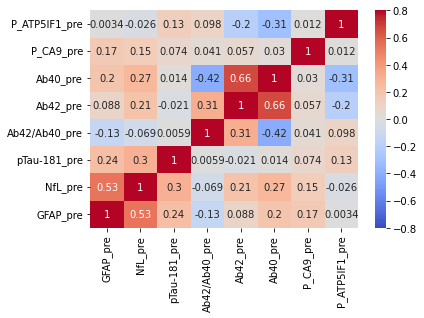

In [481]:

corr_map_pre= data.loc[all_matched,prot_els_pre[::-1]+vars['dev_pre']].corr()
corr_map_pre= data.loc[all_matched,prot_els_pre[::-1]+vars['dev_pre']].corr()
np.fill_diagonal(corr_map_post.values,1)
#np.fill_diagonal(corr_map_pre.values,-)
mask_m = np.tril(corr_map_post,k=1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True)
ax.invert_yaxis()

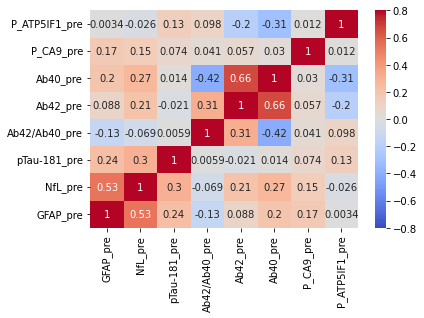

In [482]:

corr_map_pre= data.loc[all_matched,prot_els_post[::-1]+vars['dev_pre']].corr()
corr_map_pre= data.loc[all_matched,prot_els_pre[::-1]+vars['dev_pre']].corr()
np.fill_diagonal(corr_map_post.values,1)
#np.fill_diagonal(corr_map_pre.values,-)
mask_m = np.tril(corr_map_post,k=1)
ax=sns.heatmap(corr_map_pre,cmap="coolwarm",vmin=-.8,vmax=.8, annot=True)
ax.invert_yaxis()

In [ ]:
(table,pvals,pvals_corr,sigs,betas,resultstable_ext)=model_table(outpts,['adni_mean','cog_vars_gi','GeneralHealth'],['_post_cl_simp_modpre'],['Case_bin','22001-0.0','Age-3.0','assessment_sep','assessment_sep^2','pre'],beta_dirs=[1,-1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1],FPR='row',alpha=0.05,returndata=True)
table=table.rename(columns=cols_translate)
table=table.rename(columns={'Age (pandemic)':'Age (y)'})
table=table.rename(index={'Ab40':'Aβ40','Ab42':'Aβ42','Ab42/Ab40':'Aβ42/Aβ40','pTau-181':'pTau-181','NfL':'NfL','GFAP':'GFAP'})
# table.to_excel('tables/ADNI_model.xlsx')
table.style.format()

# Time plots and GPs 


In [ ]:
# from scipy.stats import norm
# tmp=np.zeros(11)
# tmp[8]=1
# np.dot(norm.pdf(np.arange(11),loc=5,scale=1),tmp)

0.0044318484119380075

In [ ]:
els=(data.loc[:,IDP].notnull())&all_matched #((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True 
els[ids2]=True

KeyError: '6348-3.0_diff'

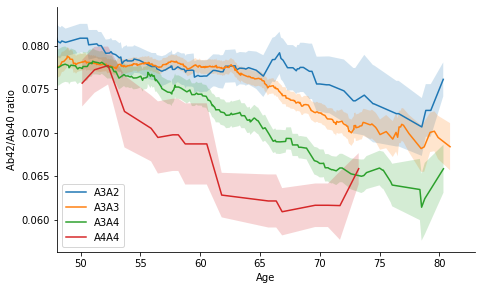

In [ ]:
IDP='Ab42/Ab40_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

In [847]:
find_vars(data,'REE')
#data.loc[:,'23526-2.0'].notna().sum()

[]

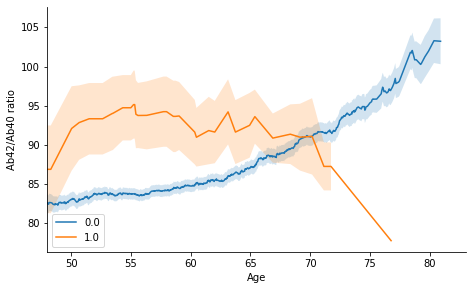

In [522]:
IDP='Ab40_regPl_pre_cl'
els=all_matched
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='Smoking_bin-2.0',time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

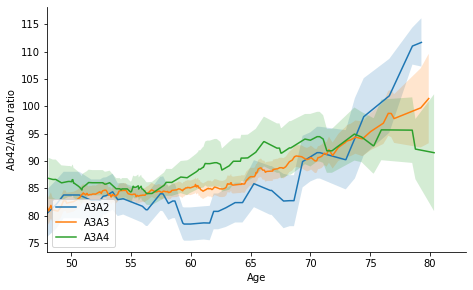

In [617]:
els=all_control
IDP='Ab40_regPl_pre_cl'
IPD='P_SERPINE1_pre_cl'
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

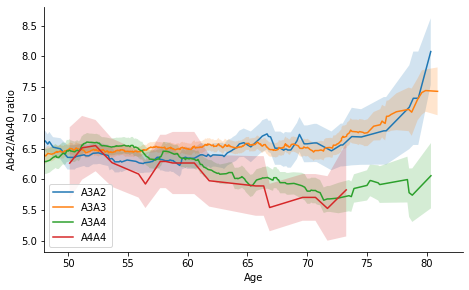

In [506]:
IDP='Ab42_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

In [ ]:
IDP='Ab42_regPl_pre_cl'
#sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
time_plot(data.loc[els,:],IDP,groupby='APOE',grps=['A3A2','A3A3','A3A4','A4A4'],time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
fig=plt.gcf()
fig.set_size_inches(7.5,4.5)

In [ ]:

def scatter_hist(x, y, ax, ax_histy):
    # no labels
    #ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    #ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.0025
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    #ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

In [ ]:
def all_plt(IDP,label,smth="3650d",loc="upper left",leg=False,pre='_pre',cl='_cl',titles=False,savename=''):
            
    if pre=='-2.0':
        post='-3.0'
    else:
        post='_post'
        
    #ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
    #ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

    els=(data.loc[:,IDP+pre+cl].notnull())&all_matched & all_case
    ids=data.loc[data.loc[els,'matched_eid'],IDP+pre+cl].dropna().index
    ids2=data.loc[ids,'matched_eid']
    els[:]=False
    els[ids]=True
    els[ids2]=True
    fig,axs = plt.subplots(1,3)
    fig.set_size_inches(18/1.5,5/1.5)
    ax1=time_plot(data.loc[els,:],IDP+pre+cl,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling=smth,xlim=[50,84],xlabel='Age',ylabel=label,title='pre-pandemic',ax=axs[0],loc=loc,leg=leg)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005],ax=axs[0])
    ax1.set_xlabel('')
    ylim1=ax1.get_ylim()
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    els=(data.loc[:,IDP+pre+cl].notnull())&all_matched & all_case
    ids=data.loc[data.loc[els,'matched_eid'],IDP+post+cl].dropna().index
    ids2=data.loc[ids,'matched_eid']
    els[:]=False
    els[ids]=True
    els[ids2]=True


    ax2=time_plot(data.loc[els,:],IDP+post+cl,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling=smth,xlim=[50,84],xlabel='Age',ylabel=label,title='post-pandemic',ax=axs[1],loc=loc,leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005],ax=axs[1])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlabel('Age')
    ax2.set_ylabel('')
    ylim2=ax2.get_ylim()
    
    ylim = [min(ylim1[0],ylim2[0]),max(ylim1[1],ylim2[1])]
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    
    els=(data.loc[:,IDP+pre+cl].notnull())&all_matched & all_case
    ids=data.loc[data.loc[els,'matched_eid'],IDP+'_diff'+cl].dropna().index
    ids2=data.loc[ids,'matched_eid']
    els[:]=False
    els[ids]=True
    els[ids2]=True
    
    ax=time_plot(data.loc[els,:],IDP+'_diff' + cl,groupby='Case',grps=['ctr','sars'],time='Age-3.0_d',rolling=smth,xlim=[50,84],xlabel='Age',ylabel=label,title='difference',ax=axs[2],loc=loc,leg=False)#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005],ax=axs[1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    ax.set_xlabel('')
    ax.set_ylabel('')
    if savename=='':
        sanename=label
        
    fig.savefig(savename+'.svg',dpi=300, bbox_inches = "tight")
    return(ax)

<Axes: title={'center': 'difference'}>

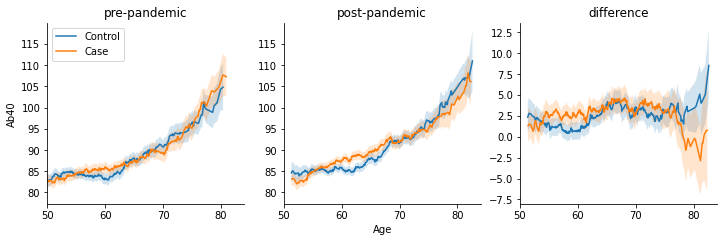

In [ ]:
all_plt('Ab40_regPl','Ab40',smth="2555d",loc='upper left', leg={"ctr":"Control",'sars':'Case','sars_hosp':"COVID-Hospitalised"})



<Axes: title={'center': 'difference'}>

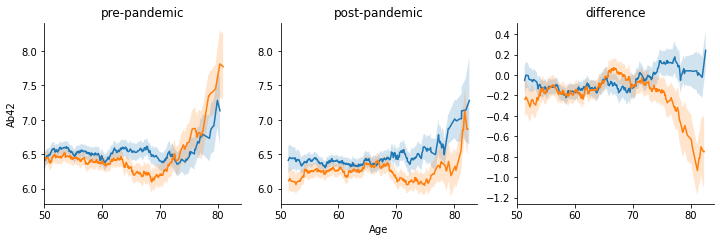

In [ ]:
all_plt('Ab42_regPl','Ab42',smth="2555d")

<Axes: title={'center': 'difference'}>

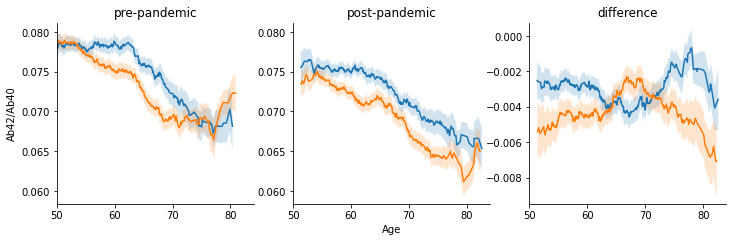

In [ ]:
all_plt('Ab42/Ab40_regPl','Ab42/Ab40',smth="2555d",loc='lower left',leg=False,savename='Ab_ratio')

<Axes: title={'center': 'difference'}>

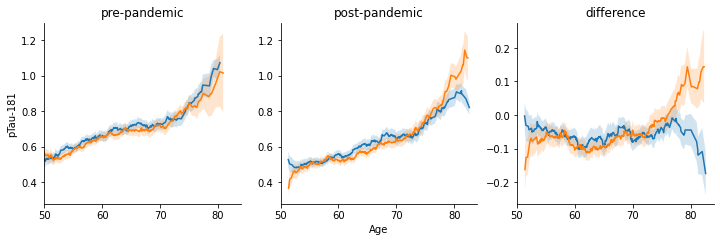

In [ ]:
all_plt('pTau-181_regPl','pTau-181',smth="2555d",loc=None,savename='pTau-181')

<Axes: title={'center': 'difference'}>

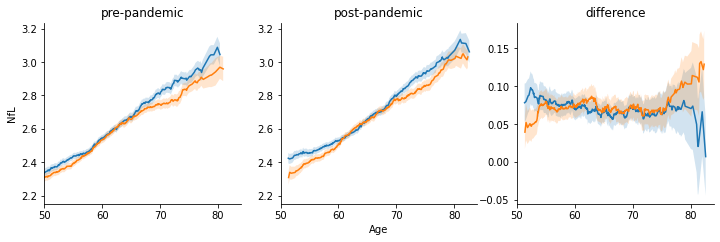

In [ ]:
all_plt('NfL_regPl','NfL',smth="3650d",loc="lower left")

<Axes: title={'center': 'difference'}>

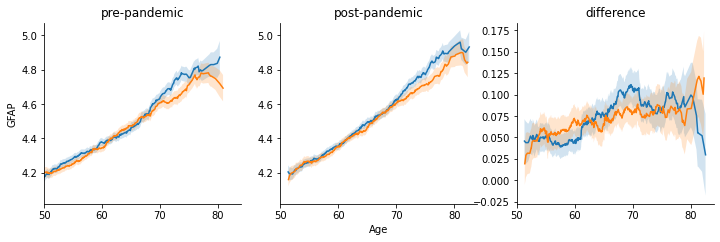

In [ ]:
all_plt('GFAP_regPl','GFAP',smth="3650d",loc="lower left")

<Axes: title={'center': 'difference'}>

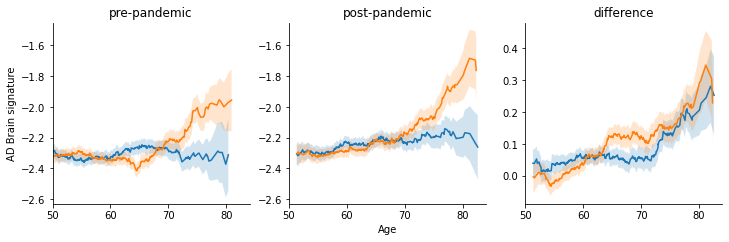

In [ ]:
all_plt('adni_mean_cl','AD Brain signature',smth="3650d",loc=None,pre='-2.0',cl='')

In [ ]:
data.loc[all_matched,'APOE'].value_counts()

APOE
A3A3    629
A3A4    233
A3A2    135
A4A4     20
A2A2      7
Name: count, dtype: int64

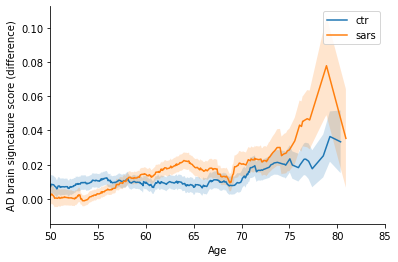

In [ ]:
IDP=IDP='adni_mean_diff'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='AD brain signcature score (difference)')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

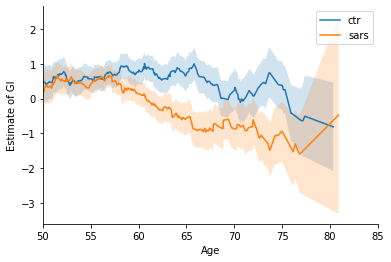

In [ ]:
IDP='cog_vars_gi_diff'

#ax1=sns.scatterplot(data=data,x='Age-3.0',y=IDP,hue='Case',alpha=0.15,label='_nolabel_')#.loc[data['APOE']=='A3A4'
#ax.legend(title='SARS-CoV-2 effects on pTau-181',  labels=['Control', 'SARS'])

els=(data.loc[:,IDP].notnull())&all_matched & all_case  #& ((data.loc[:,'COVID']=='COVID')) #& (data[IDPb]>mm)# &((data.loc[:,'COVID']=='COVID')) ##&(data.loc[:,'matched_age_mean']>75) # &(data.loc[:,time].notnull())
ids=data.loc[data.loc[els,'matched_eid'],IDP].dropna().index
ids2=data.loc[ids,'matched_eid']
els[:]=False
els[ids]=True
els[ids2]=True
ax=time_plot(data.loc[els,:],IDP,groupby='Case',grps=['ctr','sars'],time='Age-2.0_d',rolling="3860d",xlim=[50,85],xlabel='Age',ylabel='Estimate of GI')#,leg={"ctr":"Control",'sars':'SARS-CoV-2','sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2],labels[:2],loc='upper right')

In [654]:
(variants==1).sum(axis=0)

APOE1     269
APOE2     176
ABCA7      13
BDNF      373
CLU       489
PICALM    576
SORL1     112
TREM2      26
WWTR1     175
OAS1      609
CR1       125
PLD3      164
LRRK      277
dtype: int64

In [663]:
variants.keys()[4:6]

Index(['CLU', 'PICALM'], dtype='object')

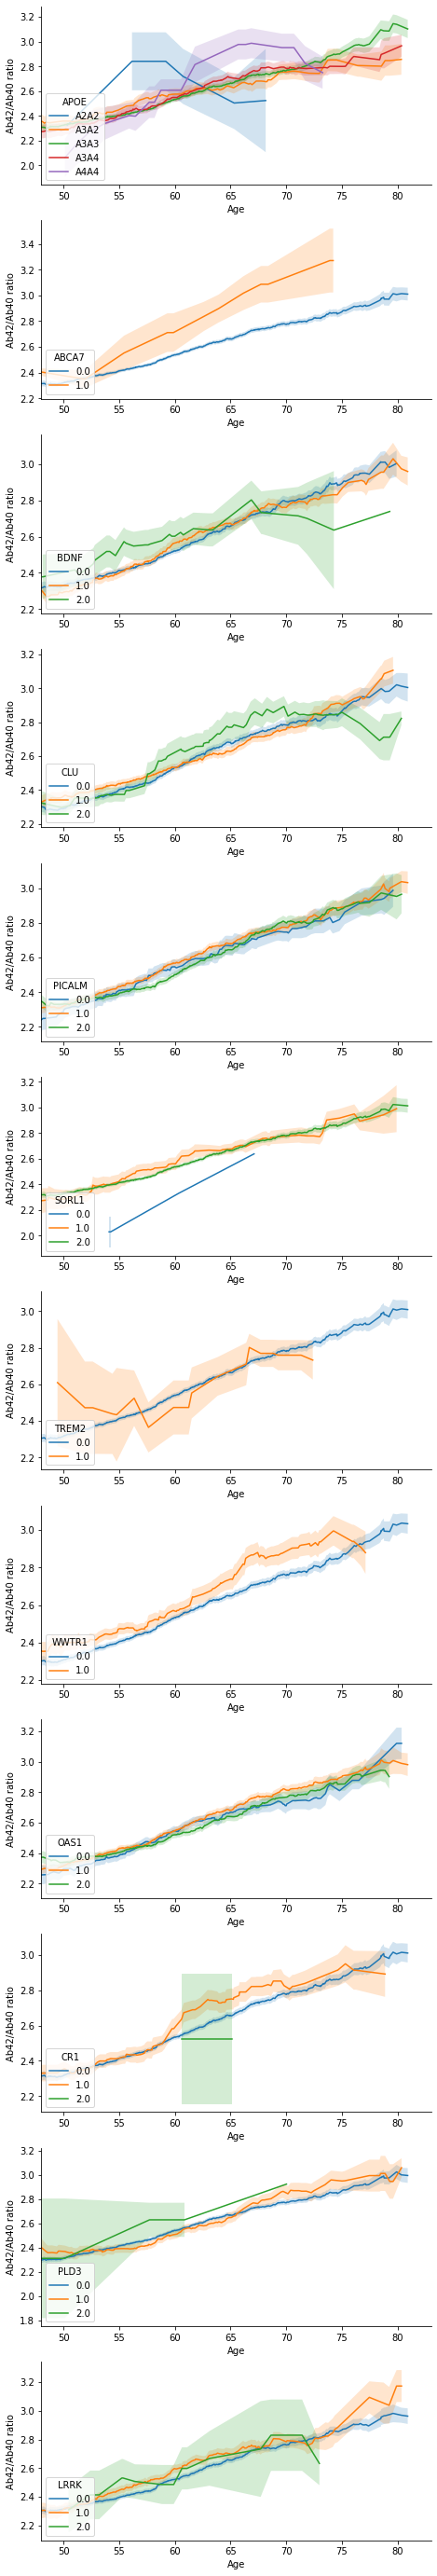

In [697]:
IDP='NfL_regPl_pre_cl'
els=(data.loc[:,IDP].notnull())&all_matched

vars=['APOE']+list(variants.keys()[2:])
fig,axs = plt.subplots(len(vars),1)
fig.set_size_inches(7.5,50)

for grp in range(len(vars)):

    grp_name=vars[grp]    
    #sns.scatterplot(data=data,x='Age-2.0',y='Ab42/Ab40_regPl_pre',hue='Case',alpha=0.3)#.loc[data['APOE']=='A3A4'
    ax=time_plot(data.loc[els,:],IDP,ax=axs[grp],groupby=grp_name,time='Age-2.0_d',rolling="3650d",xlim=[48,83],xlabel='Age',ylabel='Ab42/Ab40 ratio',loc='lower left',legendtitle=grp_name,leg=True)# {"A3A2":"APOE-ε2ε3","A3A3":"APOE-ε3ε3","A3A4":"APOE-ε3ε4","A4A4":"APOE-ε4ε4"})#,'sars_hosp':"COVID-Hospitalised"})#,ylim=[-0.01,0])#,ylim=[-0.01,0.005])
   
    #fig.set_size_inches(7.5,4.5)

In [ ]:
# # apply neuroimaging cleaning to proteomics 
# for a in prot_els_regPl:
#     CONF=['Age-3.0_f','assessment_sep','assessment_sep^2','Ethnicity(White)','Gender_pre']
#     naels=remove_outliers(remove_conf(data,a+'_post',CONF,flatten=False)).isna()
#     naels=(remove_outliers(remove_conf(data,a+'_pre',CONF,flatten=False)).isna())
#     for pref in ['_post_cl','_pre_cl']:
#         data.loc[:,a+pref]=data.loc[:,a+pref[:-3]]
#         data.loc[naels.squeeze(),a+pref]=np.nan
    
#     data.loc[:,a+'_diff_cl'] = data[a+'_post_cl']-data[a+'_pre_cl']
#     data.loc[:,a+'_pc_cl'] = 100*data[a+'_diff_cl']/data[a+'_pre_cl']

In [ ]:
# Calculate aging effect
a='Age-2.0'
IDP='adni_mean_cl-2.0'
print('Aging per year')
outpts_pre[IDP+'_'+a+'_simp'].pc

In [ ]:
#  cog_vars results 

table=model_table(outpts,['cog_vars_gi-3.0'],['_simp_modpre'],['Case'],beta_dirs=[-1,1,-1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,-1,0,0])
table=table.rename(columns=cols_translate)
# percent change
print(outpts['cog_vars_gi-3.0_simp_modpre'].pc)
table.style.format()



In [ ]:
# Calculate aging effect
a='Age-2.0'
IDP='cog_vars_gi-2.0'
print('Aging per year')
outpts_pre[IDP+'_'+a+'_simp'].pc

In [ ]:
#  cog_vars results


table=model_table(outpts,['cog_vars_gi-3.0_'+a+'_regPl' for a in ['Ab42','Ab40','Ab42/Ab40','pTau-181','NfL','GFAP']],['_simp_modpre_f'],['Case_bin','diff','pre'],beta_dirs=[-1,-1,-1,-1,-1,-1,-1,1,0,0,0,0,0,0,0,0,0],beta_vars=[1,1,1,0,0])
table=table.rename(columns=cols_translate)
table.style.format()

In [ ]:
# # memory management

# from pympler import asizeof
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 124.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

# import gc 
# gc.collect()
# import ctypes
# libc = ctypes.CDLL("libc.so.6") # clearing cache 
# libc.malloc_trim(0)

## 

## OLINK

In [ ]:
# PCA Analysis 
# # generate transformed data for all data (should do this in the loop)
# pc_com={}
# for a in [0, 2, 3]:
#     pc_com[a] = PCA(data=data.loc[common_eids,Plists[a]],ncomp=30, missing='fill-em')

# pc = PCA(data=OLINK.loc[remain_eids,Plists[0]],ncomp=100, missing='fill-em')


# proj_2= np.dot(pc_com[2].transformed_data,pc.eigenvecs)
# proj_3= np.dot(pc_com[3].transformed_data,pc.eigenvecs)
# proj_0= np.dot(pc_com[0].transformed_data,pc.eigenvecs)

# all_projs=np.c_[proj_2,proj_3,proj_0]

# cols_pc2=[ 'pc'+str(a) for a in range(100)]
# cols_pc3=[ 'pc'+str(a+100) for a in range(100)]
# cols_pc0=[ 'pc'+str(a+200) for a in range(100)]

# test_data=pd.DataFrame(data=all_projs,index=OLINK.index[common_eids],columns=cols_pc2 + cols_pc3 + cols_pc0)
# target=pd.DataFrame(data.loc[OLINK.index[common_eids],'Ab42_pre'])
# target=pd.concat([data.loc[OLINK.index[common_eids],prot_els_pre+prot_els_post+['Case']],test_data],axis=1)

# formulatxt= ''.join([ 'pc'+str(a)+' + ' for a in range(100)])[:-2]

# sklearn.model_selection.cross_val_score(HistGradientBoostingClassifier(), data.loc[:,prot_els_pre+['Age-2.0']], data.loc[:,'Gender_pre'], scoring='accuracy')
# print(sklearn.model_selection.cross_val_score(SMWrapper(SVC), test,data[cols_pc2], tmp['Ab40_pre'], scoring='r2'))

# sklearn.model_selection.cross_val_score(SMWrapper(sm.OLS), test_data[cols_pc2], target['Ab40_pre'], scoring='r2')
# sklearn.model_selection.cross_val_score(HistGradientBoostingClassifier(), target[prot_els_pre], (target['Gender_pre']), scoring='r2')
# sklearn.model_selection.cross_val_score(HistGradientBoostingRegressor(), target[prot_els_pre], (target['Ab42_post']), scoring='accuracy',cv=sklearn.model_selection.StratifiedKFold())
# print(sklearn.model_selection.cross_val_score(SMWrapper(smf.ols), X, y, scoring='r2'))

# pc_COVID = PCA(data=OLINK.loc[common_eids,:],ncomp=10, missing='fill-em')
# A=pc_COVID._adjusted_data